변수 설명

- 구, 동 ~ 도로명주소
    - 아파트의 주소
- 단지명 
    - 거래된 아파트 이름
- 전용면적 
    - 거래된 아파트의 면적
- 계약
- 혼인건수
    - 연도별(2017~2020) 강남구 혼인건수
- 인구밀도
    - 연도별(2017~2020) 강남구 인구밀도
- 아파트_거래건수
    - 월별 강남구 아파트 거래건수
- 소비자물가지수
    - 서울시 월별 소비자 물가지수
- 가계대출_십억원
    - 서울시 월별 가계대출
- 기준금리
    - 매월 한국은행 기준금리
- 경도, 위도
    - 거래된 아파트의 경도와 위도

In [ ]:
# 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm

plt.style.use('fivethirtyeight')
sns.set(font_scale = 1.0)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# font 적용
plt.rcParams['font.family'] = 'NanumGothic'
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
# 레티나 설정 : 글자가 흐릿하게 보이는 현상 방지
%config InlineBackend.figure_format = 'retina'

#전처리
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/CodeStates/CP1/강남_아파트_실거래가예측_최종_2017_2020.csv')

In [5]:
df = df[df['구'] == '강남구']#실수로 2017 데이터에 강북구 들어감.
df.head()

구    동 번지  본번  부번         도로명    단지명  전용면적(㎡)     계약년월  계약일  ...  \
0  강남구  삼성동  2   2   0  선릉로130길 19  서광아파트    59.67  2018-01    2  ...   
1  강남구  삼성동  2   2   0  선릉로130길 19  서광아파트    59.67  2018-01   24  ...   
2  강남구  삼성동  2   2   0  선릉로130길 19  서광아파트    84.93  2018-01   26  ...   
3  강남구  삼성동  2   2   0  선릉로130길 19  서광아파트    59.67  2018-02   13  ...   
4  강남구  삼성동  2   2   0  선릉로130길 19  서광아파트    84.93  2018-07   30  ...   

  1km내_지하철역수  지하철역_최소거리  1km내_문화시설수  문화시설_최소거리  1km내_공원수   공원_최소거리  1km내_학교수  \
0          6   0.433154          14   0.078366         1  0.999269         6   
1          6   0.433154          14   0.078366         1  0.999269         6   
2          6   0.433154          14   0.078366         1  0.999269         6   
3          6   0.433154          14   0.078366         1  0.999269         6   
4          6   0.433154          14   0.078366         1  0.999269         6   

    학교_최소거리  1km내_학원수   학원_최소거리  
0  0.383584       251  0.072215  
1  0.383584       251  0.072215  
2  0.383584       251  0.072215  
3  0.383584       251  0.072215  
4  0.383584       251  0.072215  

[5 rows x 35 columns]

In [6]:
df.describe()

본번            부번       전용면적(㎡)           계약일             층  \
count  18351.000000  18351.000000  18351.000000  18351.000000  18351.000000   
mean     496.565146      3.884475     92.379439     16.082230      9.262329   
std      307.051924      9.457477     41.518483      8.699817      7.443993   
min        2.000000      0.000000     12.100000      1.000000     -1.000000   
25%      188.000000      0.000000     59.970000      9.000000      4.000000   
50%      513.000000      0.000000     84.870000     16.000000      8.000000   
75%      736.000000      2.000000    115.240000     23.000000     12.000000   
max     1282.000000     76.000000    273.680000     31.000000     68.000000   

               건축년도          혼인건수          인구밀도      아파트_거래건수       소비자물가지수  \
count  18351.000000  18351.000000  18351.000000  18351.000000  18351.000000   
mean    1997.583401   2440.000381  13988.002452    567.289848     98.682280   
std       11.481012    236.602922    174.836745    280.464100      1.091034   
min     1974.000000   2046.000000  13773.000000     49.000000     97.088000   
25%     1987.000000   2338.000000  13859.000000    361.000000     97.456000   
50%     1999.000000   2519.000000  13929.000000    550.000000     98.977000   
75%     2006.000000   2677.000000  14203.000000    728.000000     99.733000   
max     2020.000000   2677.000000  14203.000000   1191.000000    100.700000   

       ...    1km내_지하철역수     지하철역_최소거리    1km내_문화시설수     문화시설_최소거리  \
count  ...  18351.000000  18351.000000  18351.000000  18351.000000   
mean   ...      1.942564      0.408780      5.520244      0.411444   
std    ...      1.315087      0.282545      3.654240      0.226099   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      1.000000      0.184735      2.000000      0.224889   
50%    ...      2.000000      0.388554      5.000000      0.379687   
75%    ...      3.000000      0.629401      9.000000      0.573407   
max    ...      7.000000      0.999331     16.000000      0.981981   

           1km내_공원수       공원_최소거리      1km내_학교수       학교_최소거리      1km내_학원수  \
count  18351.000000  18351.000000  18351.000000  18351.000000  18351.000000   
mean       0.654406      0.358254      9.217045      0.292909    467.185821   
std        0.664566      0.357599      4.677656      0.148186    457.134134   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      5.000000      0.188943    130.000000   
50%        1.000000      0.366128      8.000000      0.273527    247.000000   
75%        1.000000      0.665437     13.000000      0.363495    742.000000   
max        2.000000      0.999269     20.000000      0.886082   1653.000000   

            학원_최소거리  
count  18351.000000  
mean       0.111011  
std        0.070695  
min        0.000000  
25%        0.064573  
50%        0.098648  
75%        0.140734  
max        0.423109  

[8 rows x 28 columns]

In [7]:
df.dtypes

구              object
동              object
번지             object
본번              int64
부번              int64
도로명            object
단지명            object
전용면적(㎡)       float64
계약년월           object
계약일             int64
거래금액(만원)       object
층               int64
건축년도            int64
혼인건수            int64
인구밀도            int64
아파트_거래건수        int64
소비자물가지수       float64
가계대출_십억원      float64
기준금리          float64
X좌표           float64
Y좌표           float64
경도            float64
위도            float64
1km내_유치원수       int64
유치원_최소거리      float64
1km내_지하철역수      int64
지하철역_최소거리     float64
1km내_문화시설수      int64
문화시설_최소거리     float64
1km내_공원수        int64
공원_최소거리       float64
1km내_학교수        int64
학교_최소거리       float64
1km내_학원수        int64
학원_최소거리       float64
dtype: object

In [8]:
# 결측값 없음 확인
df.isnull().sum()

구             0
동             0
번지            0
본번            0
부번            0
도로명           0
단지명           0
전용면적(㎡)       0
계약년월          0
계약일           0
거래금액(만원)      0
층             0
건축년도          0
혼인건수          0
인구밀도          0
아파트_거래건수      0
소비자물가지수       0
가계대출_십억원      0
기준금리          0
X좌표           0
Y좌표           0
경도            0
위도            0
1km내_유치원수     0
유치원_최소거리      0
1km내_지하철역수    0
지하철역_최소거리     0
1km내_문화시설수    0
문화시설_최소거리     0
1km내_공원수      0
공원_최소거리       0
1km내_학교수      0
학교_최소거리       0
1km내_학원수      0
학원_최소거리       0
dtype: int64

In [9]:
# 계약년월 -> Datetime형으로 변환
# 거래금액 -> int 형으로 변환
df['거래금액(만원)'] = df['거래금액(만원)'].str.replace(',','').astype(int)
#print(df['거래금액(만원)'])
df['계약일'] = df['계약일'].astype(str)
df['계약일자']= df['계약년월'].str.cat(df['계약일'], sep='-')
df['계약일자'] = pd.to_datetime(df['계약일자'])
#df['계약일자']

In [10]:
apt_num_count= df['단지명'].value_counts().to_frame().reset_index()
apt_num_count.rename(columns = {'index' : 'apt', '단지명':'apt_count'},  inplace = True)
apt_num_count

apt  apt_count
0            은마        765
1          도곡렉슬        676
2    성원대치2단지아파트        403
3          까치마을        344
4      래미안대치팰리스        283
..          ...        ...
597      신동아듀크빌          1
598       상지카일룸          1
599    대우로얄카운티3          1
600     청담동마크노빌          1
601      포스틸빌라트          1

[602 rows x 2 columns]

In [11]:
df1 = df[df.isna().any(axis=1)]
df1['도로명'].value_counts()

# 영동대로138길 12 : 청담자이아파트
# 언주로 420 : 역삼자이아파트
# 개포로109길 69 : LG자이아파트 로 수정함.

df.loc[(df['도로명'] == '영동대로138길 12'), '단지명'] = '청담자이아파트'
df.loc[(df['도로명'] == '언주로 420'), '단지명'] = '역삼자이아파트'
df.loc[(df['도로명'] == '개포로109길 69'), '단지명'] = 'LG자이아파트'

In [12]:
df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

df["top10"] = df['단지명'].apply(lambda x: 1 if any(i in x for i in top10) else 0)

2020년 아파트 브랜드 순위를 기준으로, 해당 아파트가 브랜스 10권 아파트에 속하는지 여부
- https://saysensibility.tistory.com/1392
- http://www.gvalley.co.kr/news/articleView.html?idxno=583178

In [13]:
df["top10"] .value_counts()

0    14688
1     3663
Name: top10, dtype: int64

## 시계열(계약일자)에 따른 특징들의 변화
---
- 거래금액
- 거래지역(아파트 위치)
- 건축년도
- 혼인건수
- 인구밀도
- 아파트거래건수

In [14]:
# 시계열 데이터 시각화를 위하여, 시계열데이터를 인덱스로 설정
df_new = df.set_index('계약일자')

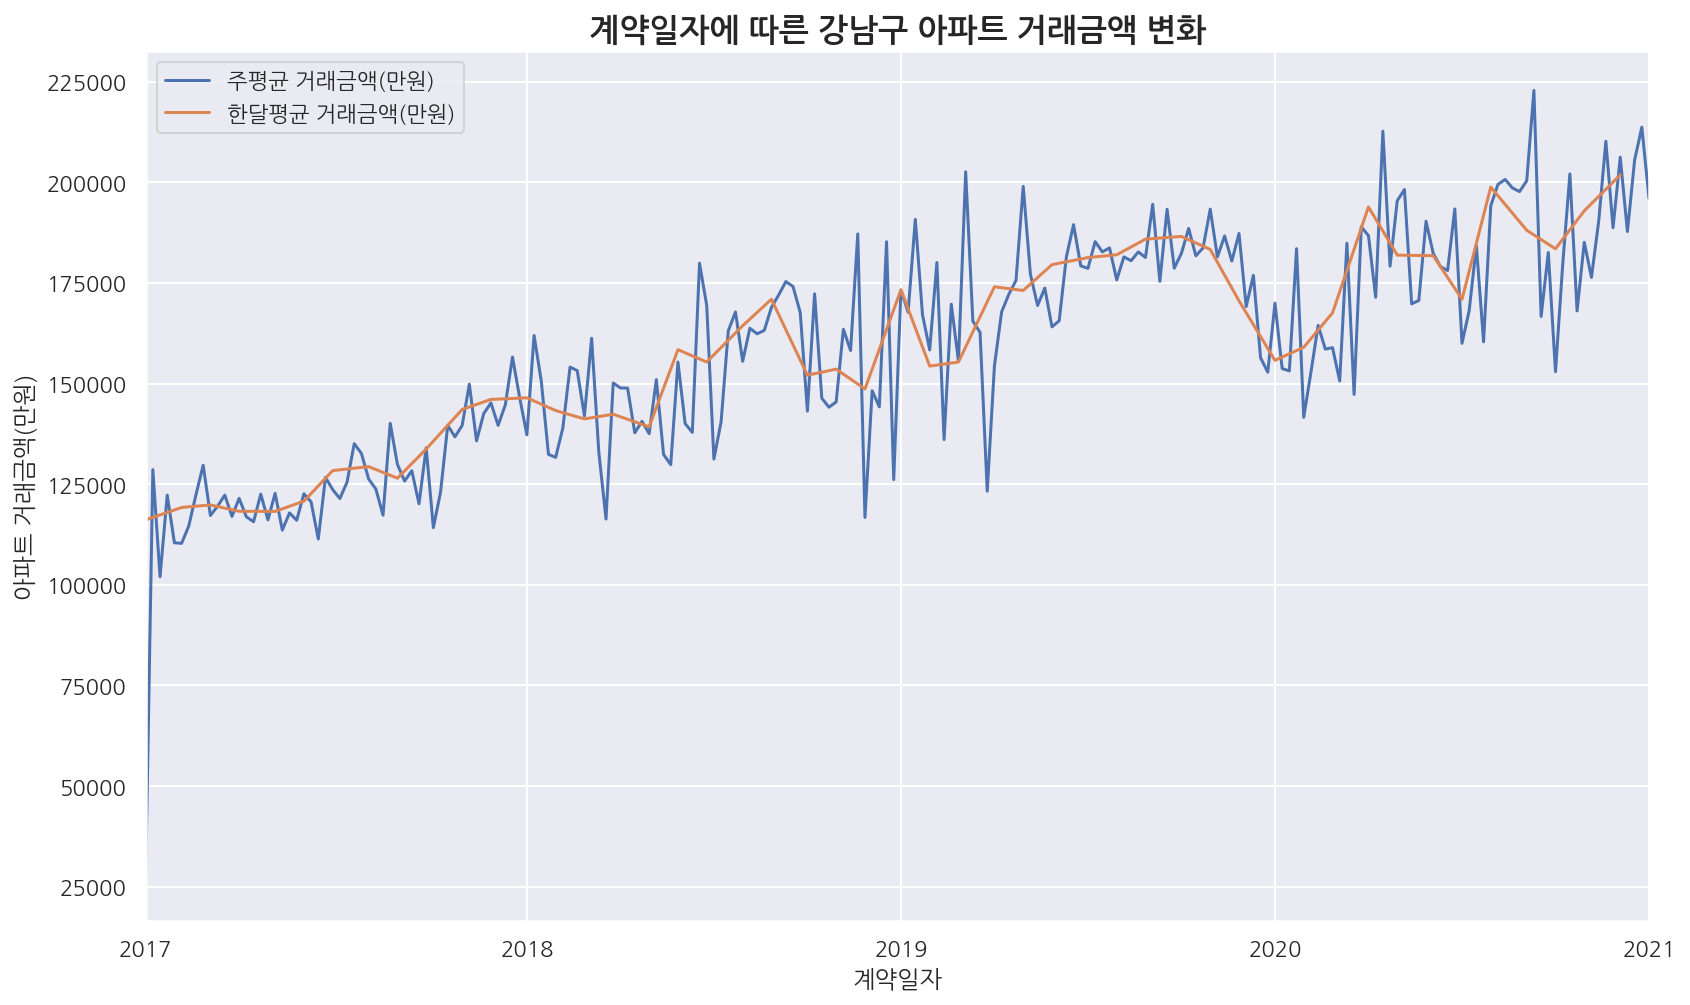

In [15]:
fig, ax = plt.subplots(figsize = (12,8))
거래금액_한달평균 = df_new['거래금액(만원)'].resample('M').mean()
거래금액_일주일평균 = df_new['거래금액(만원)'].resample('W').mean()
#df_new['거래금액(만원)'].plot(label='거래금액(만원)', ax=ax)
거래금액_일주일평균.plot(label='주평균 거래금액(만원)', ax=ax)
거래금액_한달평균.plot(label='한달평균 거래금액(만원)', ax=ax)
ax.set_ylabel('아파트 거래금액(만원)')
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('계약일자에 따른 강남구 아파트 거래금액 변화', loc='center', fontdict = title_font)
plt.legend()
plt.show()

계약일자에 따른 아파트 거래금액에 대한 선형 그래프가 복잡하여,  
일주일 단위와 한달 단위의 거래금액 평균을 계산하여 시각화 하였습니다.  
최근에 거래한 아파트일수록 점차 거래가격이 상승하는 것을 볼 수 있습니다.

## 강남구 동에 관한 시각화

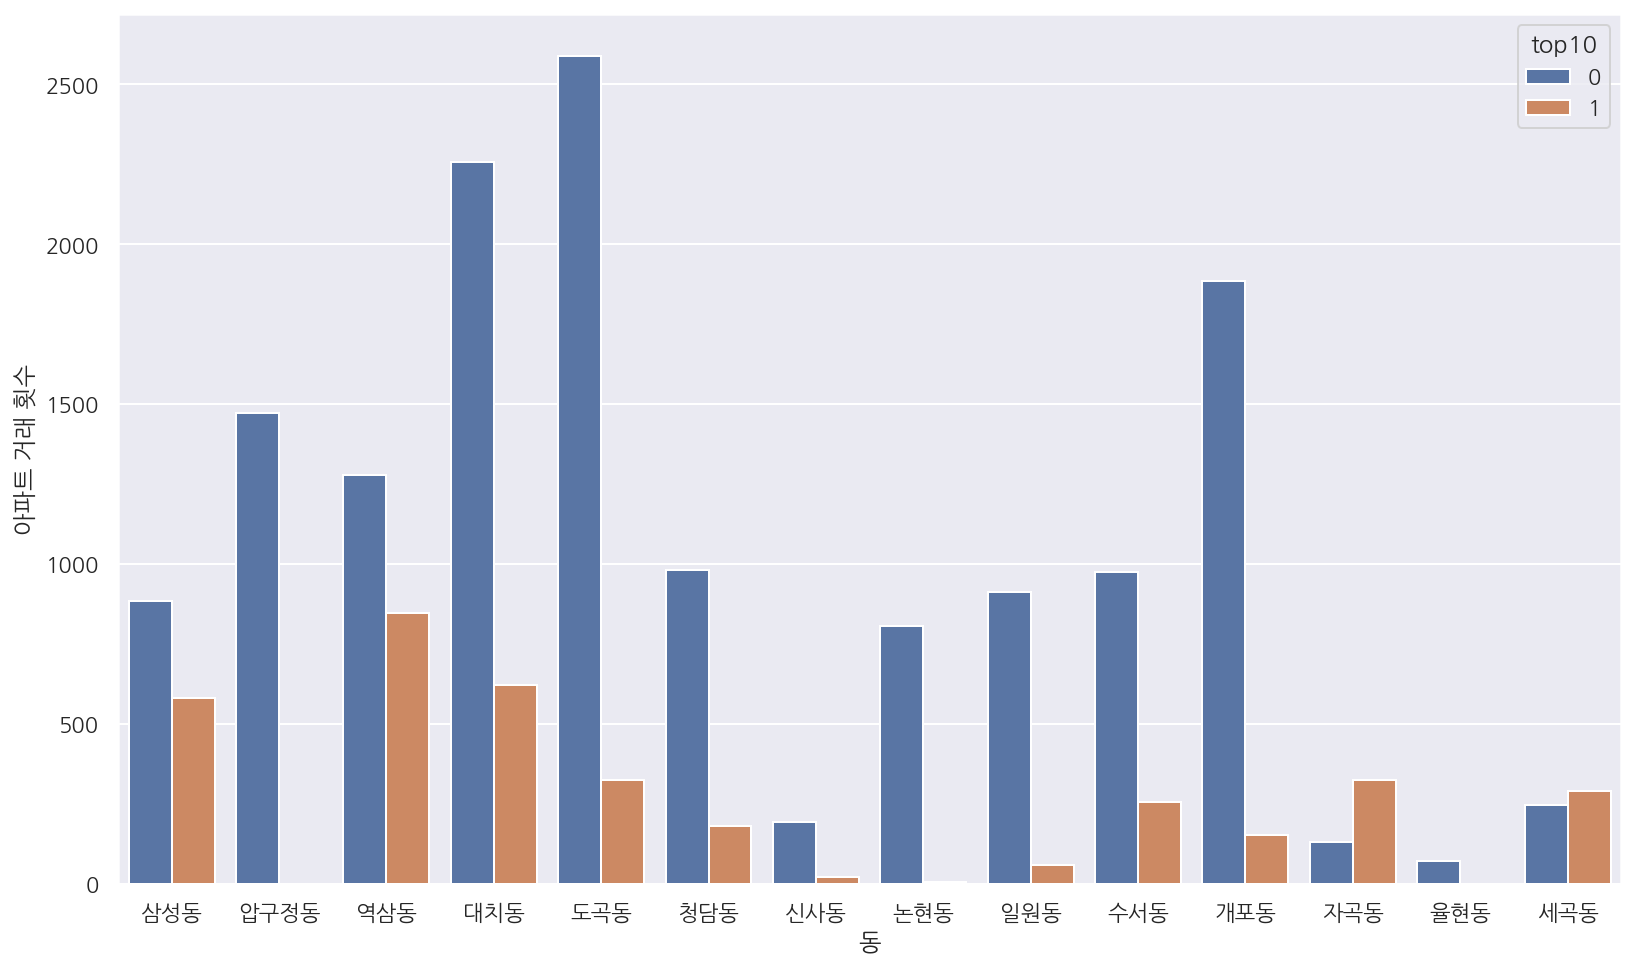

In [16]:
# top 10 아파트가 많은지
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot('동', hue='top10', data=df)
plt.ylabel('아파트 거래 횟수')

plt.show()

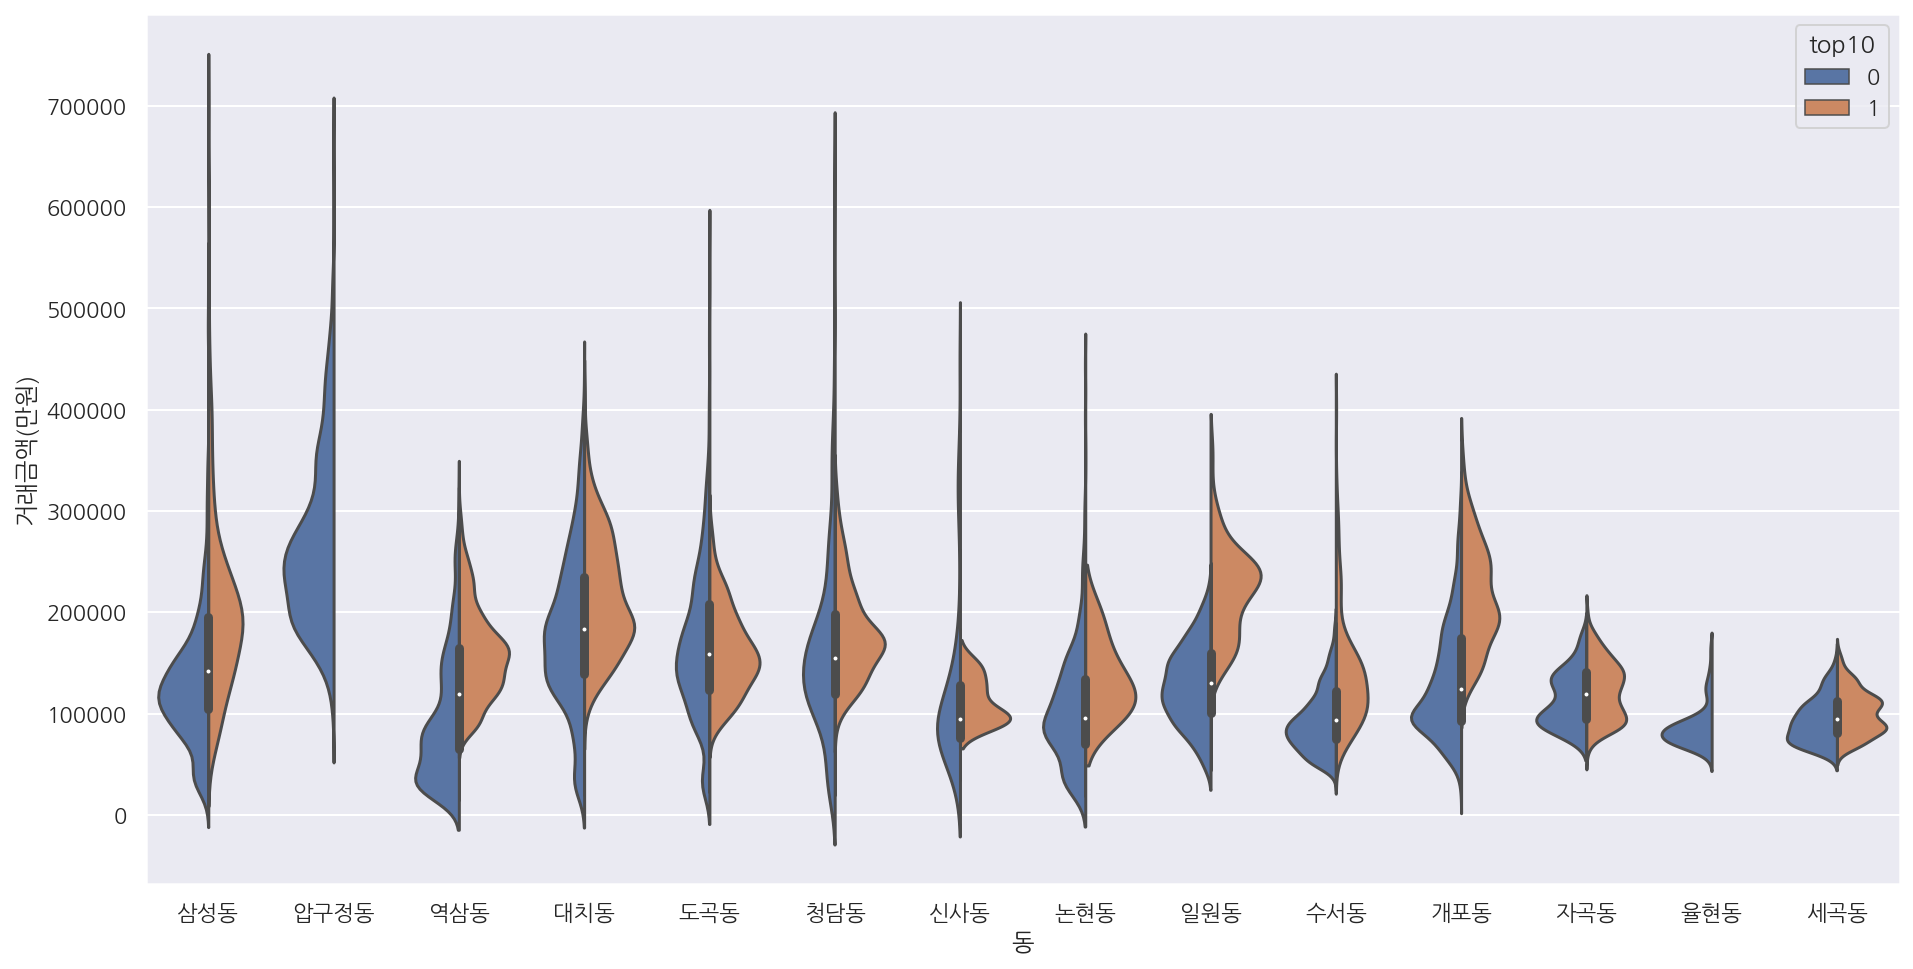

In [17]:
fig, ax = plt.subplots(figsize = (14,8))
sns.violinplot(x='동', y='거래금액(만원)', hue='top10', data=df, split=True)

Text(0.5, 1.0, '강남구 동별 아파트 거래 현황')

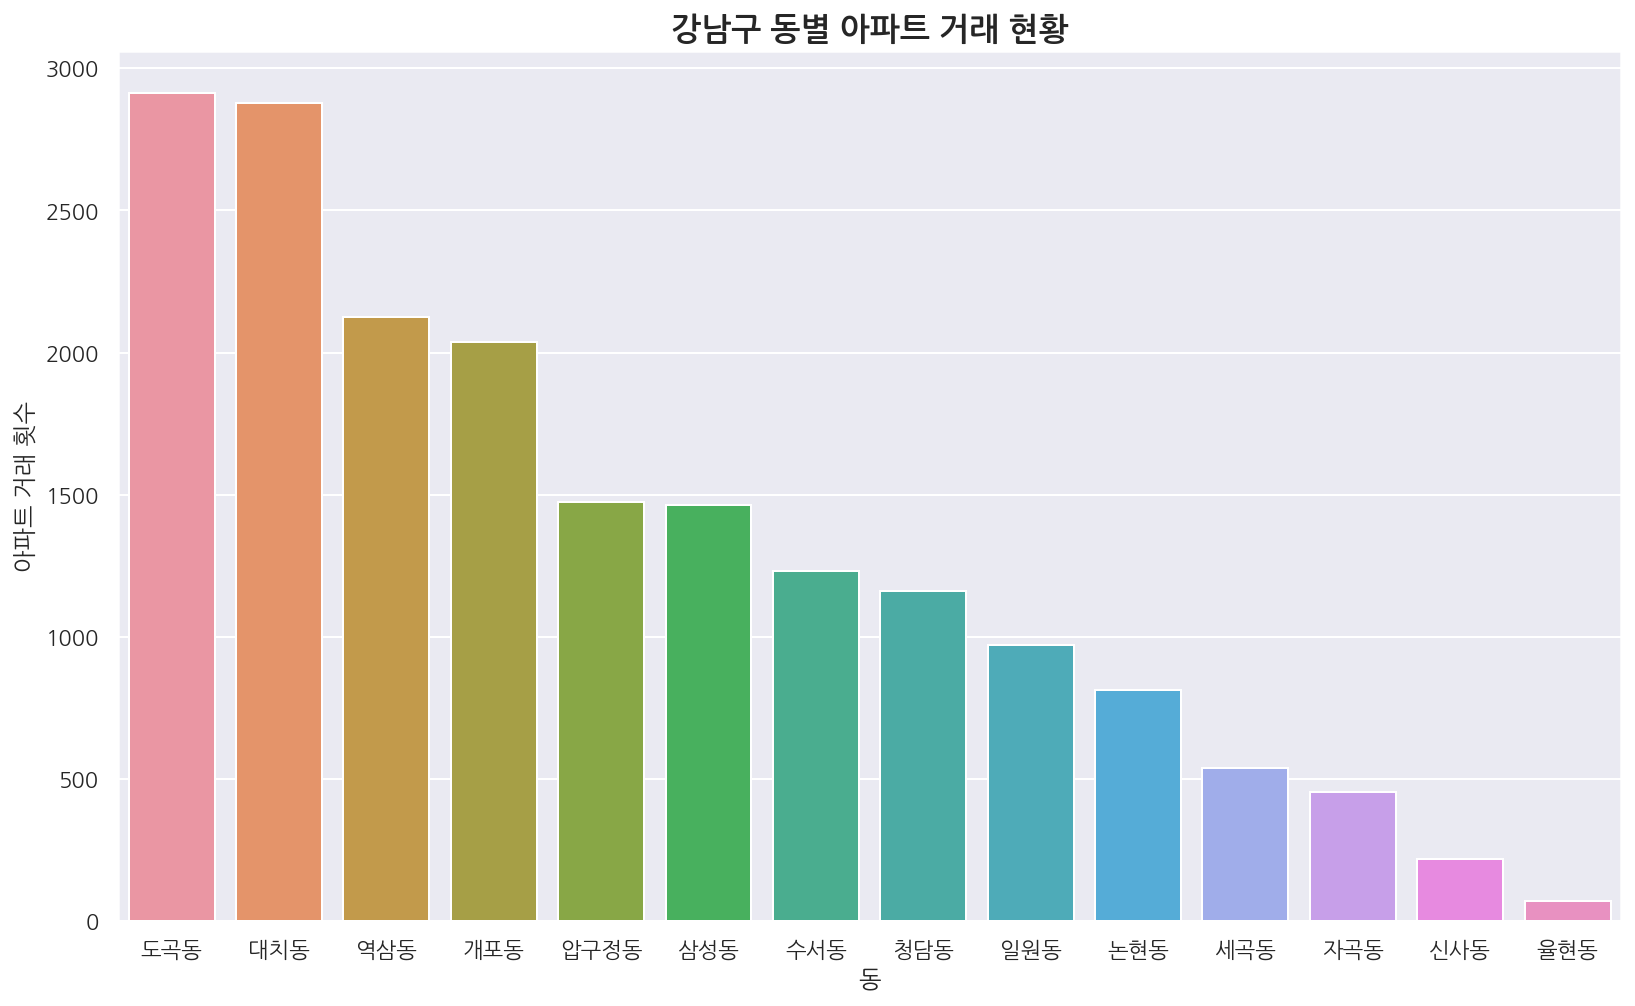

In [18]:
fig, ax = plt.subplots(figsize = (12,8))

dong_count = df.groupby(['동'])['단지명'].count().to_frame().sort_values(['단지명'], ascending=False)
dong_count.reset_index(inplace=True)
sns.barplot(x='동', y = '단지명', data=dong_count)

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.ylabel('아파트 거래 횟수')
plt.title('강남구 동별 아파트 거래 현황', loc='center', fontdict = title_font)

Text(0.5, 1.0, '강남구 동별 평균 아파트 거래금액 현황')

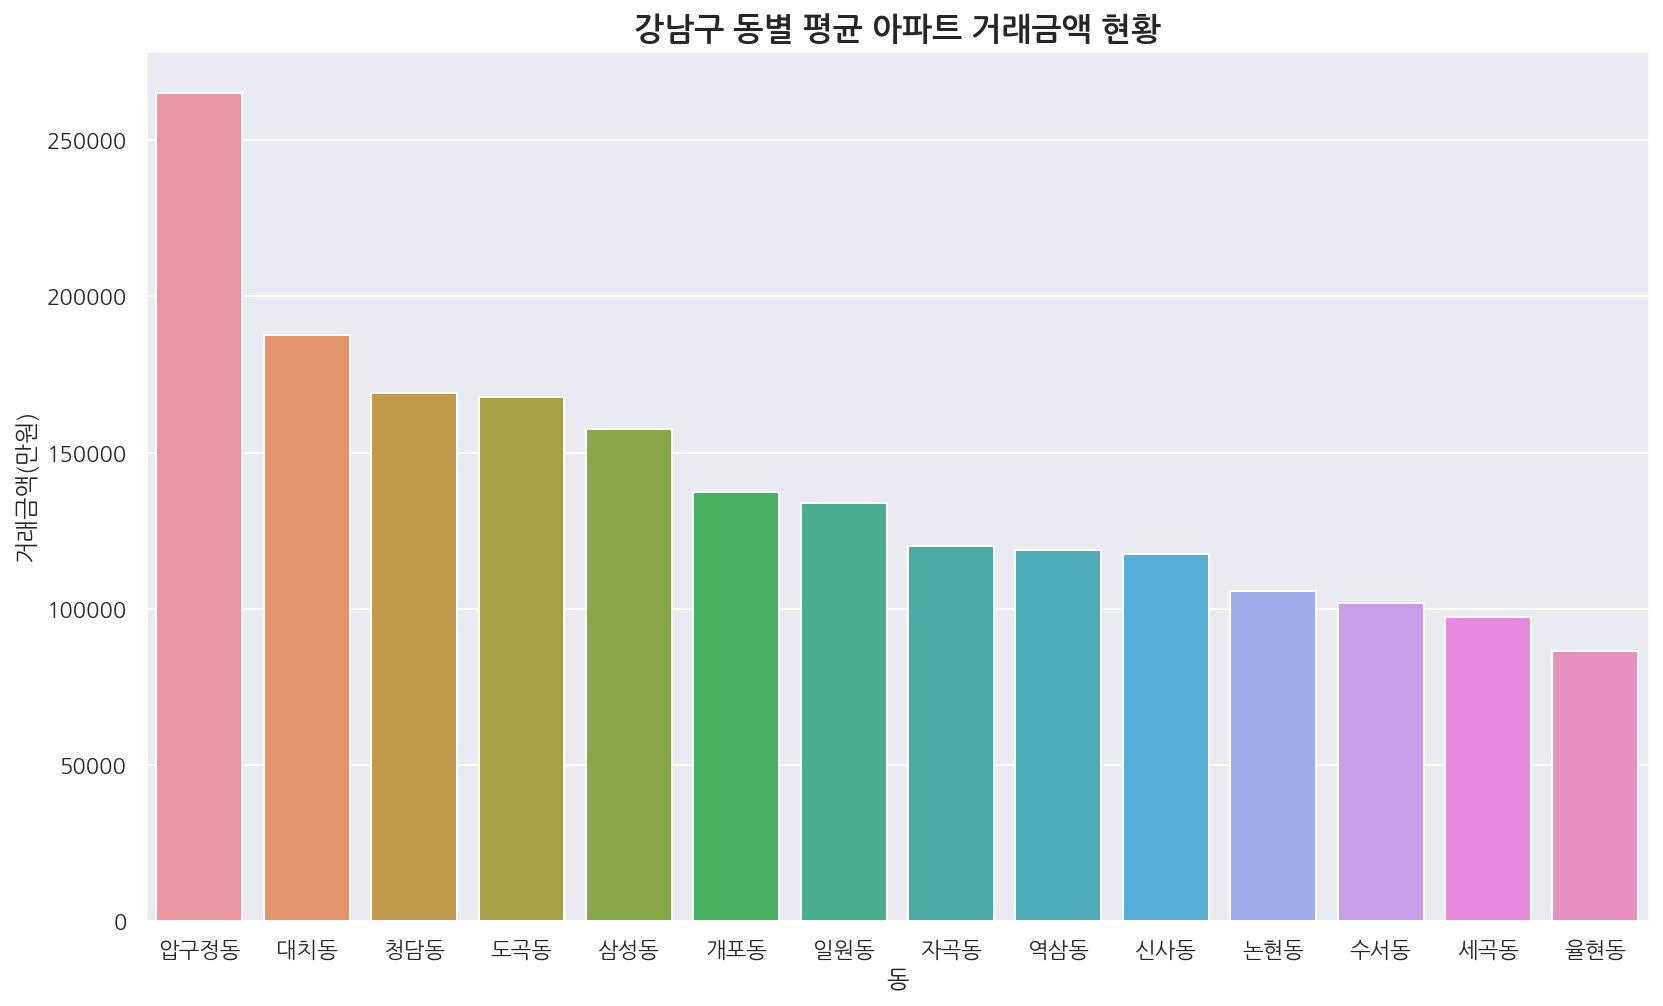

In [19]:
fig, ax = plt.subplots(figsize = (12,8))
dong_price = df.groupby(['동'])['거래금액(만원)'].mean().to_frame().sort_values(by='거래금액(만원)',ascending=False)
sns.barplot(x=dong_price.index,  y='거래금액(만원)', data=dong_price)

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('강남구 동별 평균 아파트 거래금액 현황', loc='center', fontdict = title_font)

동에 따른 아파트 평균 거래금액을 살펴보면, 압구정동이 가장 비싼것으로 나타났습니다.    
또한 동별로 아파트 거래가격에 차이가 있는 것으로 보아, 어느 동에 위치해 있는지도 중요한 모델의 변수가 될 수 있을 것 같습니다.  

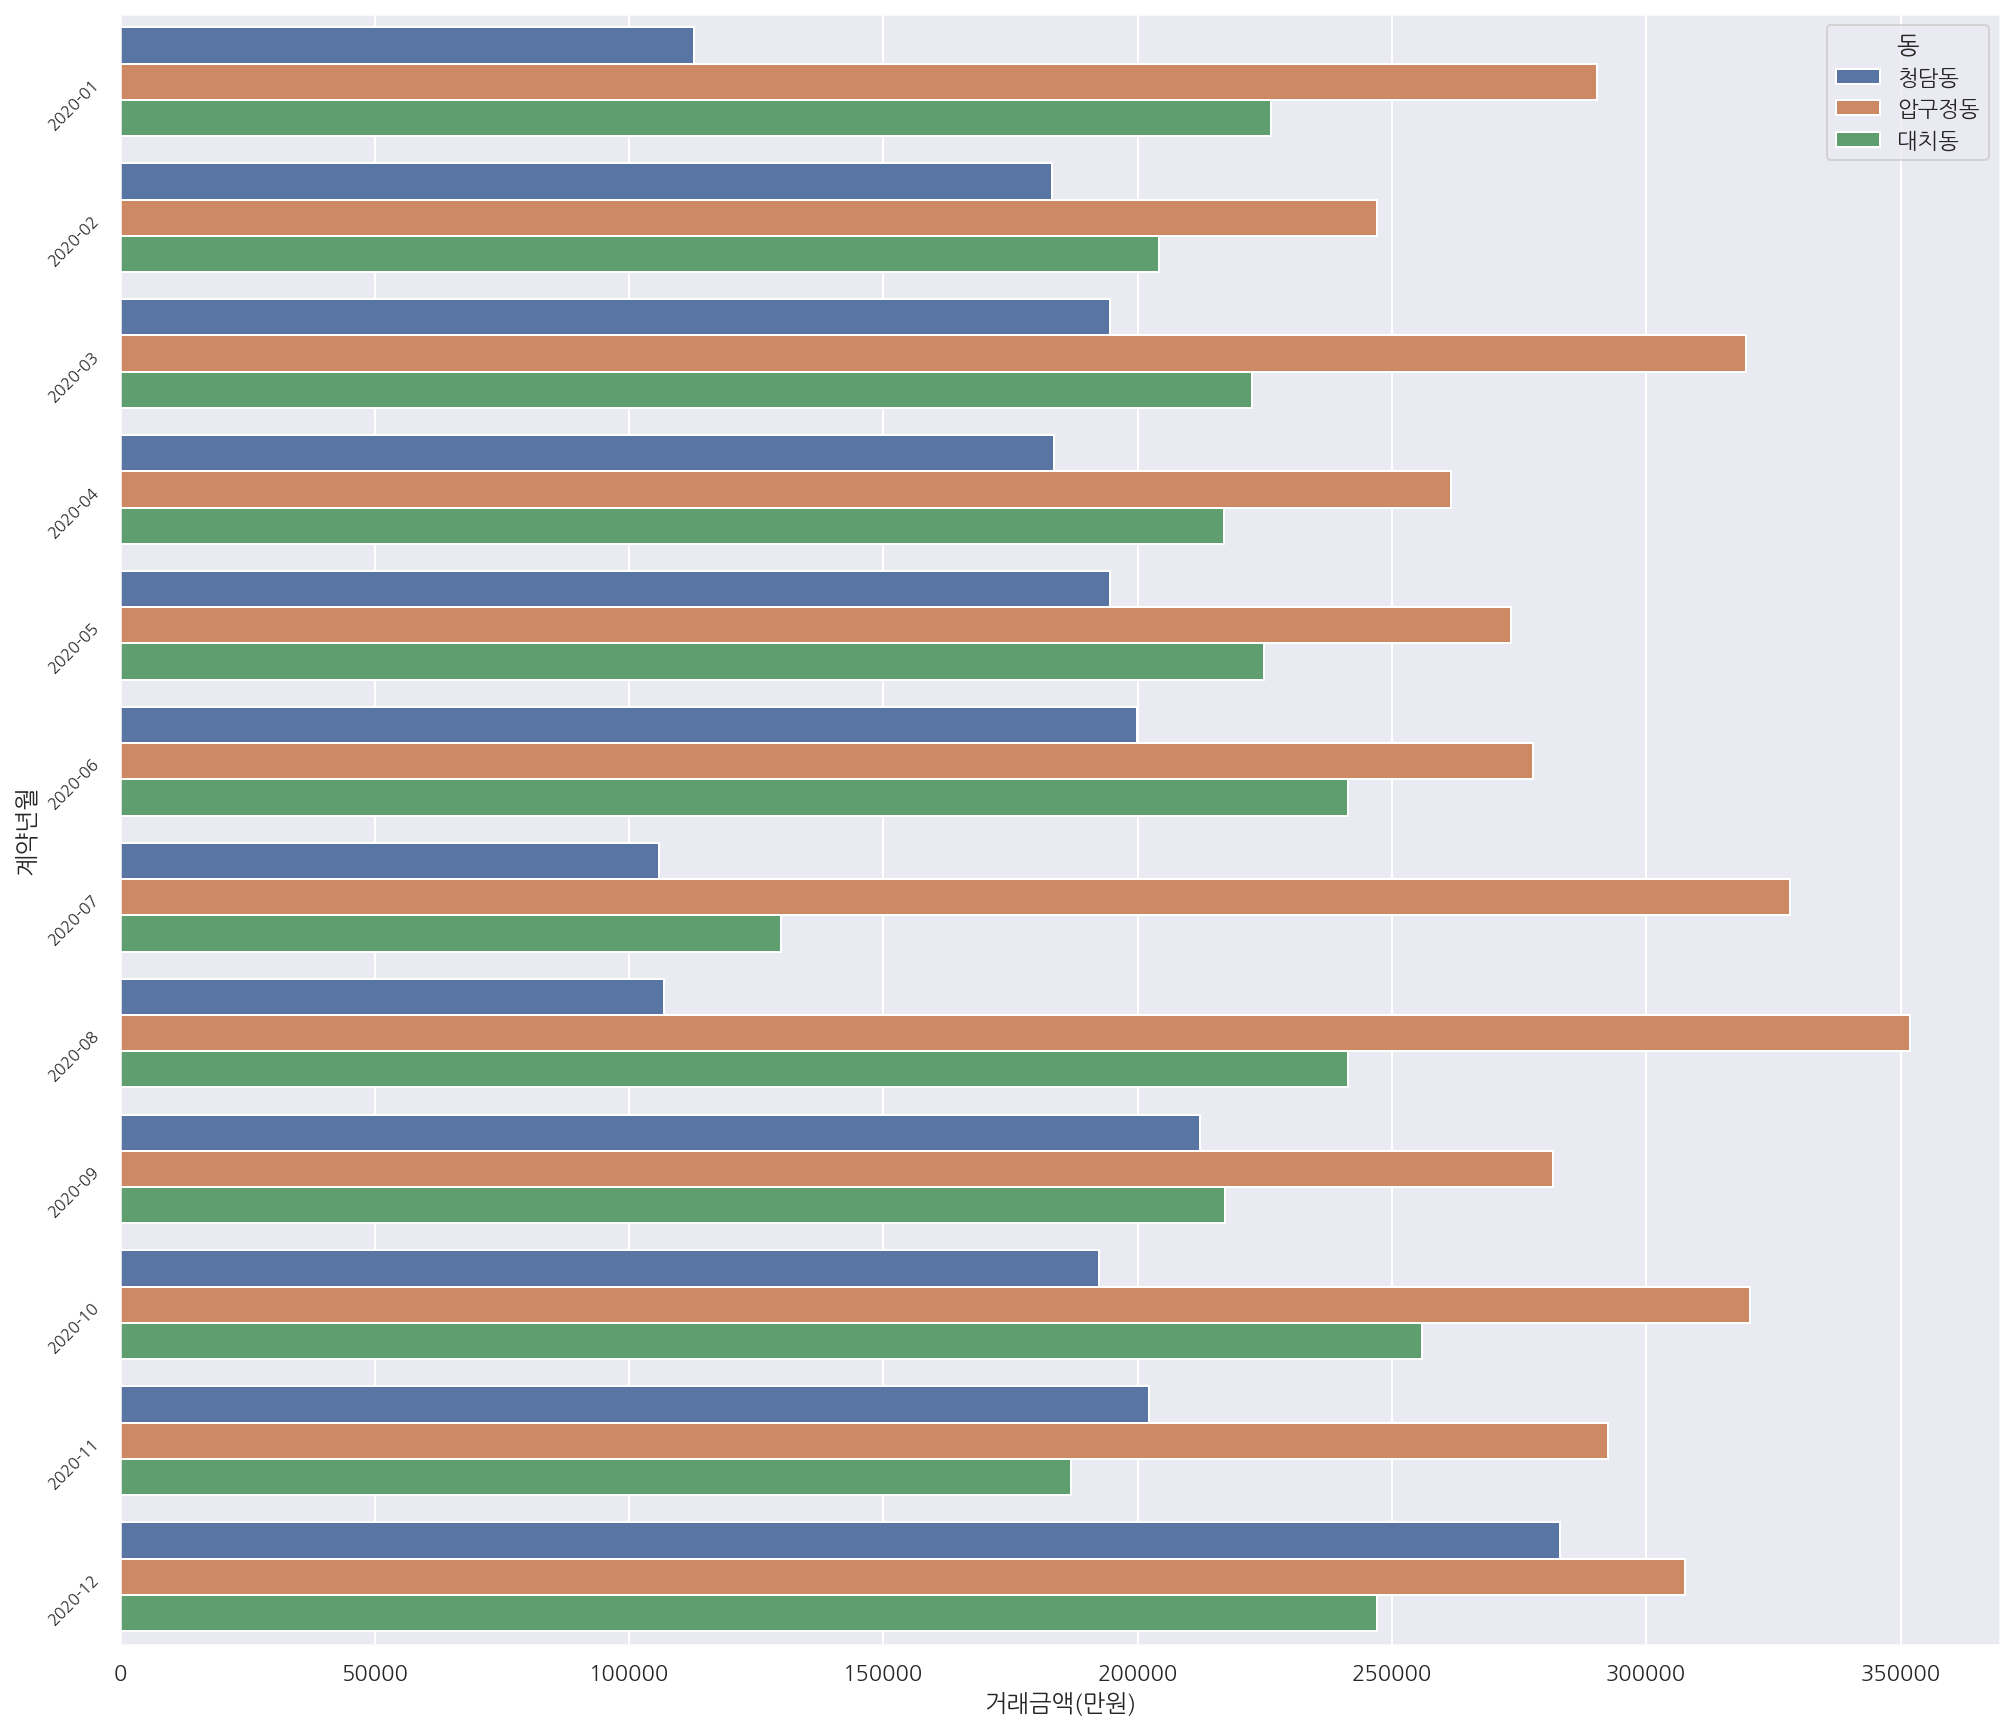

In [20]:
fig, ax = plt.subplots(figsize = (15,15))

dong_price_by_month = df.groupby(['계약년월','동'])['거래금액(만원)'].mean().to_frame().sort_values(by='계약년월',ascending=True)
dong_price_by_month.reset_index(inplace=True)
dong_price_by_month_2017 = dong_price_by_month[dong_price_by_month['계약년월'].str.contains('2017')]
dong_price_by_month_2018 = dong_price_by_month[dong_price_by_month['계약년월'].str.contains('2017')]
dong_price_by_month_2019 = dong_price_by_month[dong_price_by_month['계약년월'].str.contains('2019')]
dong_price_by_month_2020 = dong_price_by_month[dong_price_by_month['계약년월'].str.contains('2020')]

dong_price_by_month_2020 = dong_price_by_month_2020[(dong_price_by_month_2020['동'] == '압구정동') | (dong_price_by_month_2020['동'] == '대치동') | (dong_price_by_month_2020['동'] == '청담동')]
sns.barplot(x = '거래금액(만원)', y = '계약년월', hue = '동', data=dong_price_by_month_2020, orient='h')
plt.yticks(rotation=45, fontsize =8)
plt.show()

가장 평균 거래가격이 높았던 압구정동, 대치동, 청담동의 최근 아파트 평균 거래가격을 살펴보면,  
세 동 모두 높은 가격대를 유지하다가 7월에 잠깐 주춤한 후, 다시 되돌아 오는 것을 볼 수 있습니다.  
압구정동의 아파트는 여전히 비싼 상태를 유지하며, 청담동, 대치동은 조금씩 상승하는 것을 볼수 있습니다.


## 아파트 건축년도

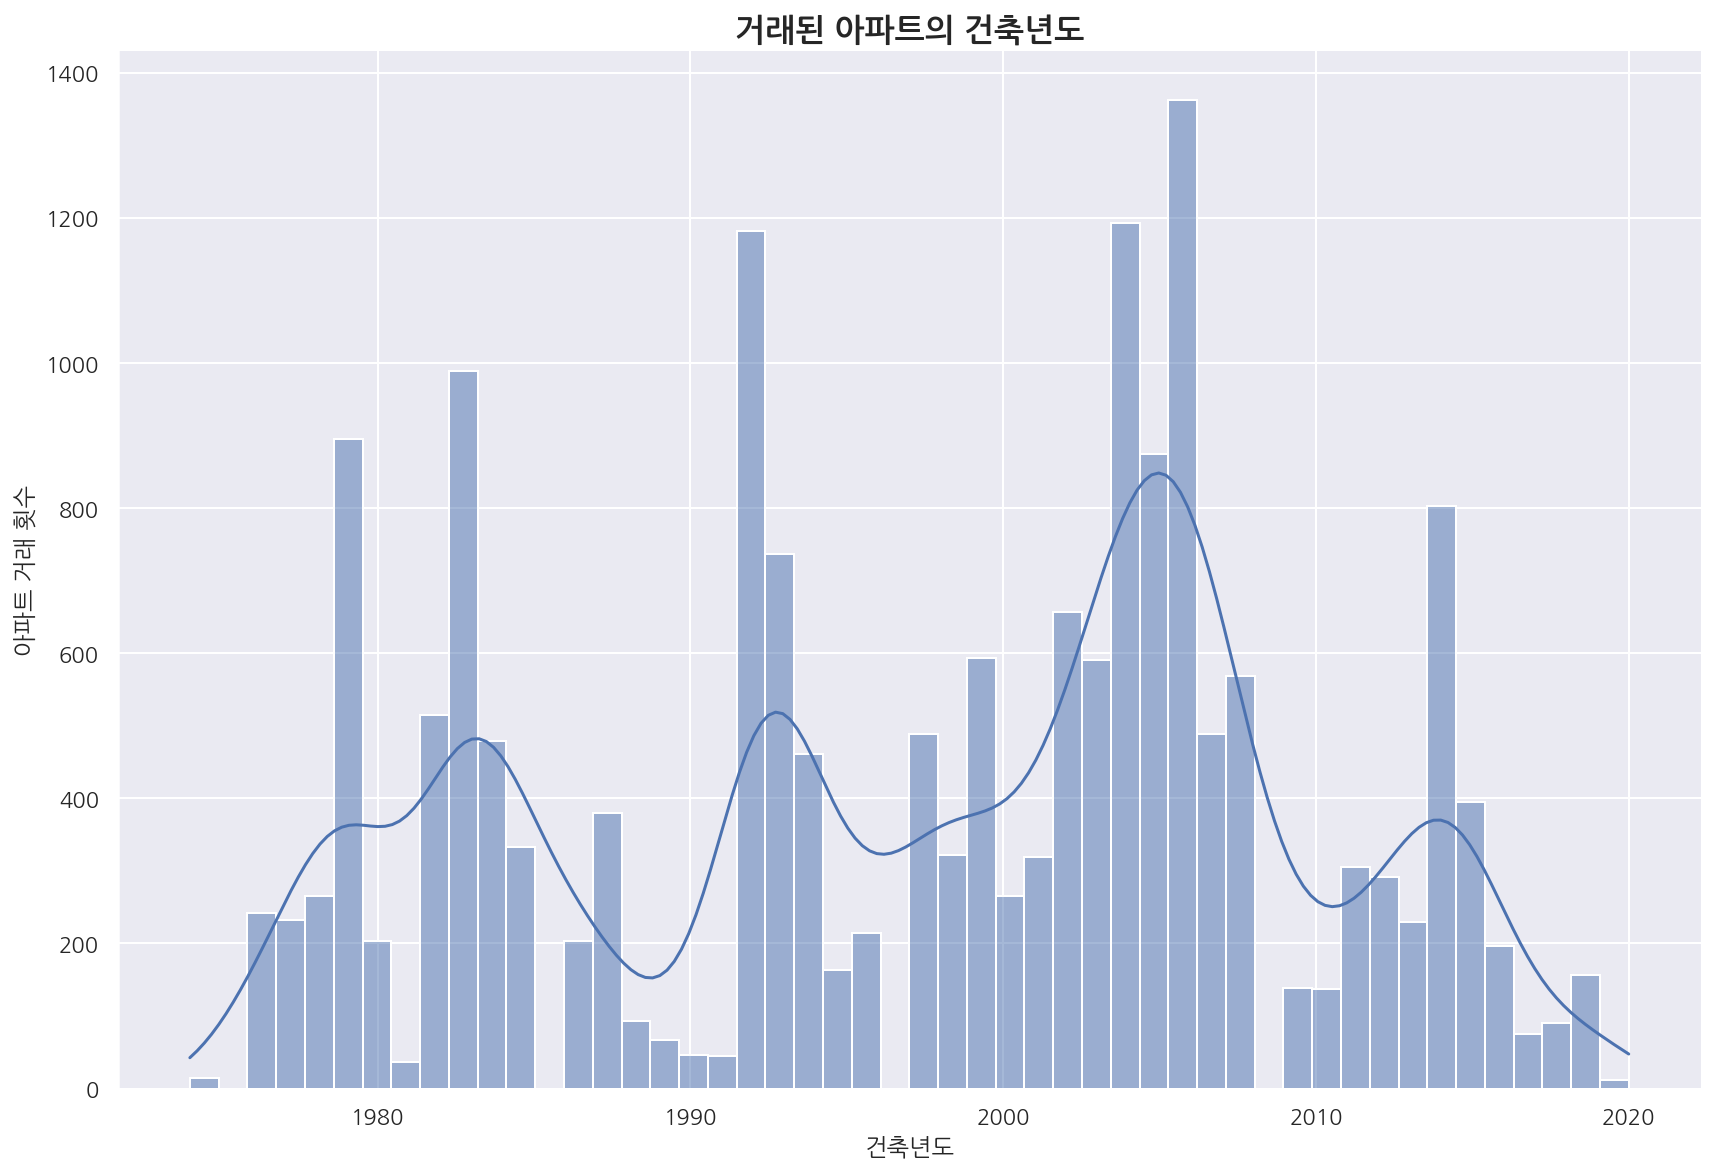

In [21]:
#아파트 건축년도에 따른 거래 아파트 수

sns.displot(df['건축년도'], bins=50,  kde=True, height = 8, aspect=1.5)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('거래된 아파트의 건축년도', loc='center', fontdict = title_font)
plt.ylabel('아파트 거래 횟수')
plt.show()

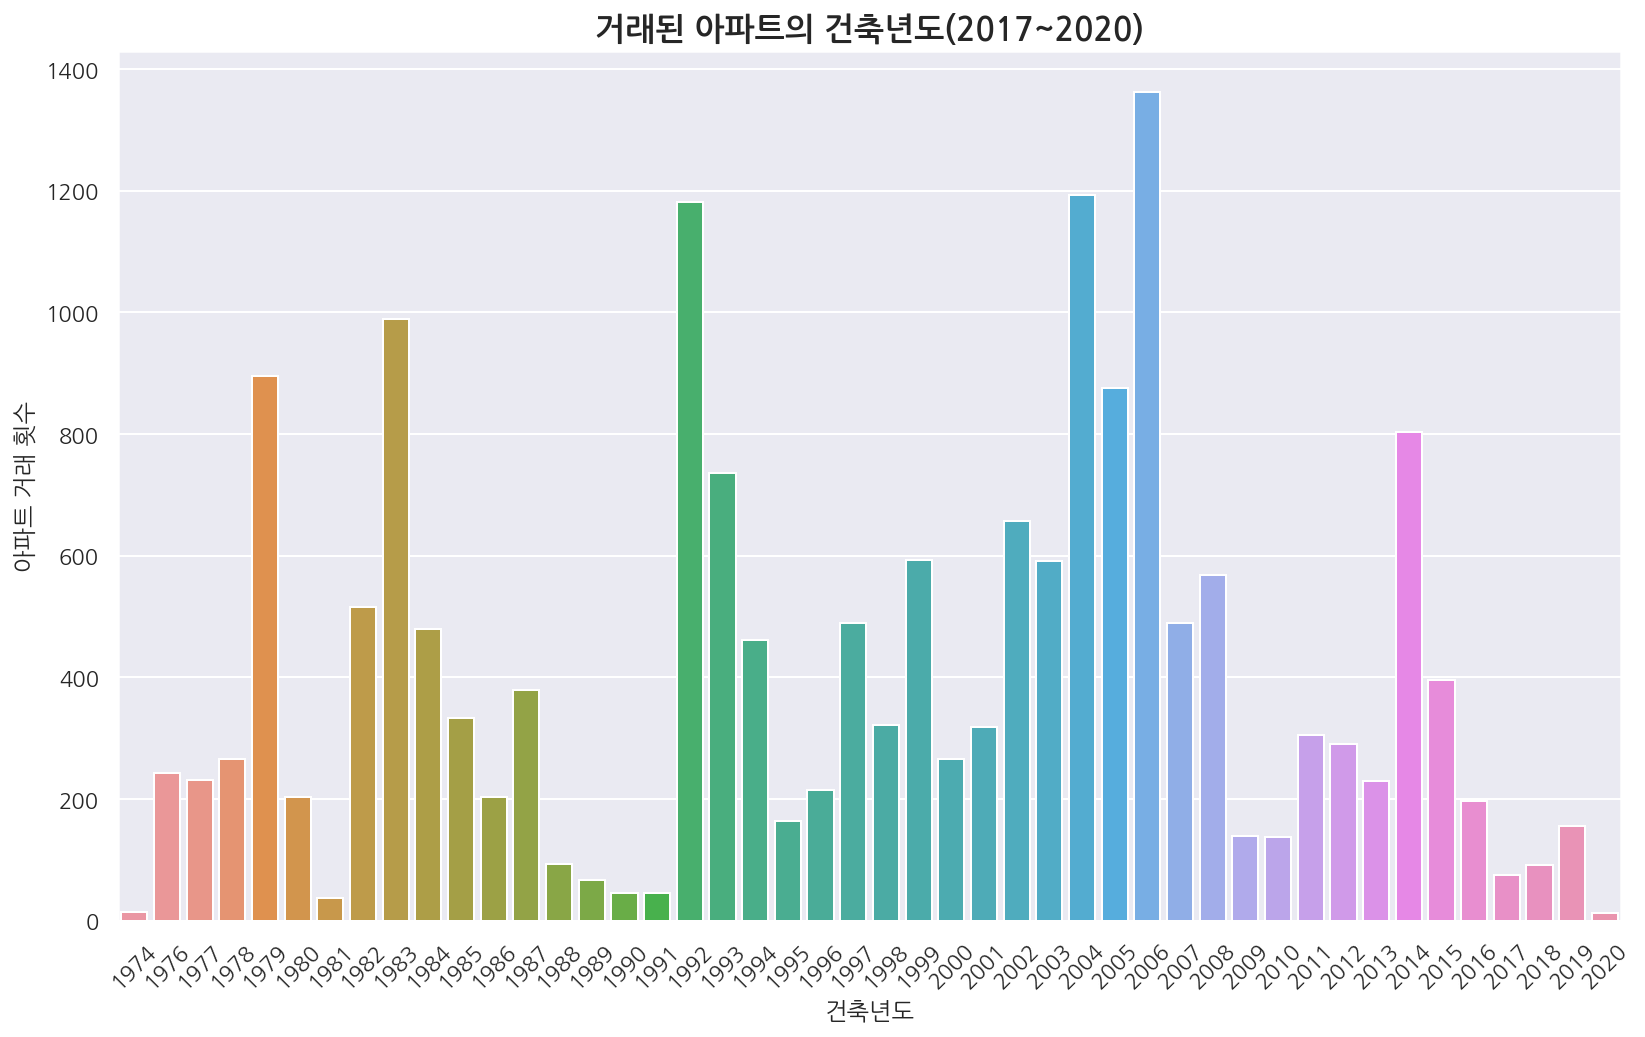

In [22]:
#아파트 건축년도에 따른 거래 아파트 수
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot('건축년도',data=df, ax=ax)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('거래된 아파트의 건축년도(2017~2020)', loc='center', fontdict = title_font)
plt.ylabel('아파트 거래 횟수')
plt.xticks(rotation=45)
plt.show()

2000년대 지어진 아파트들의 거래량이 제일 많고, 1990년대 지어진 아파트들이 2번째로 거래량이 많은것을 알 수 있습니다.

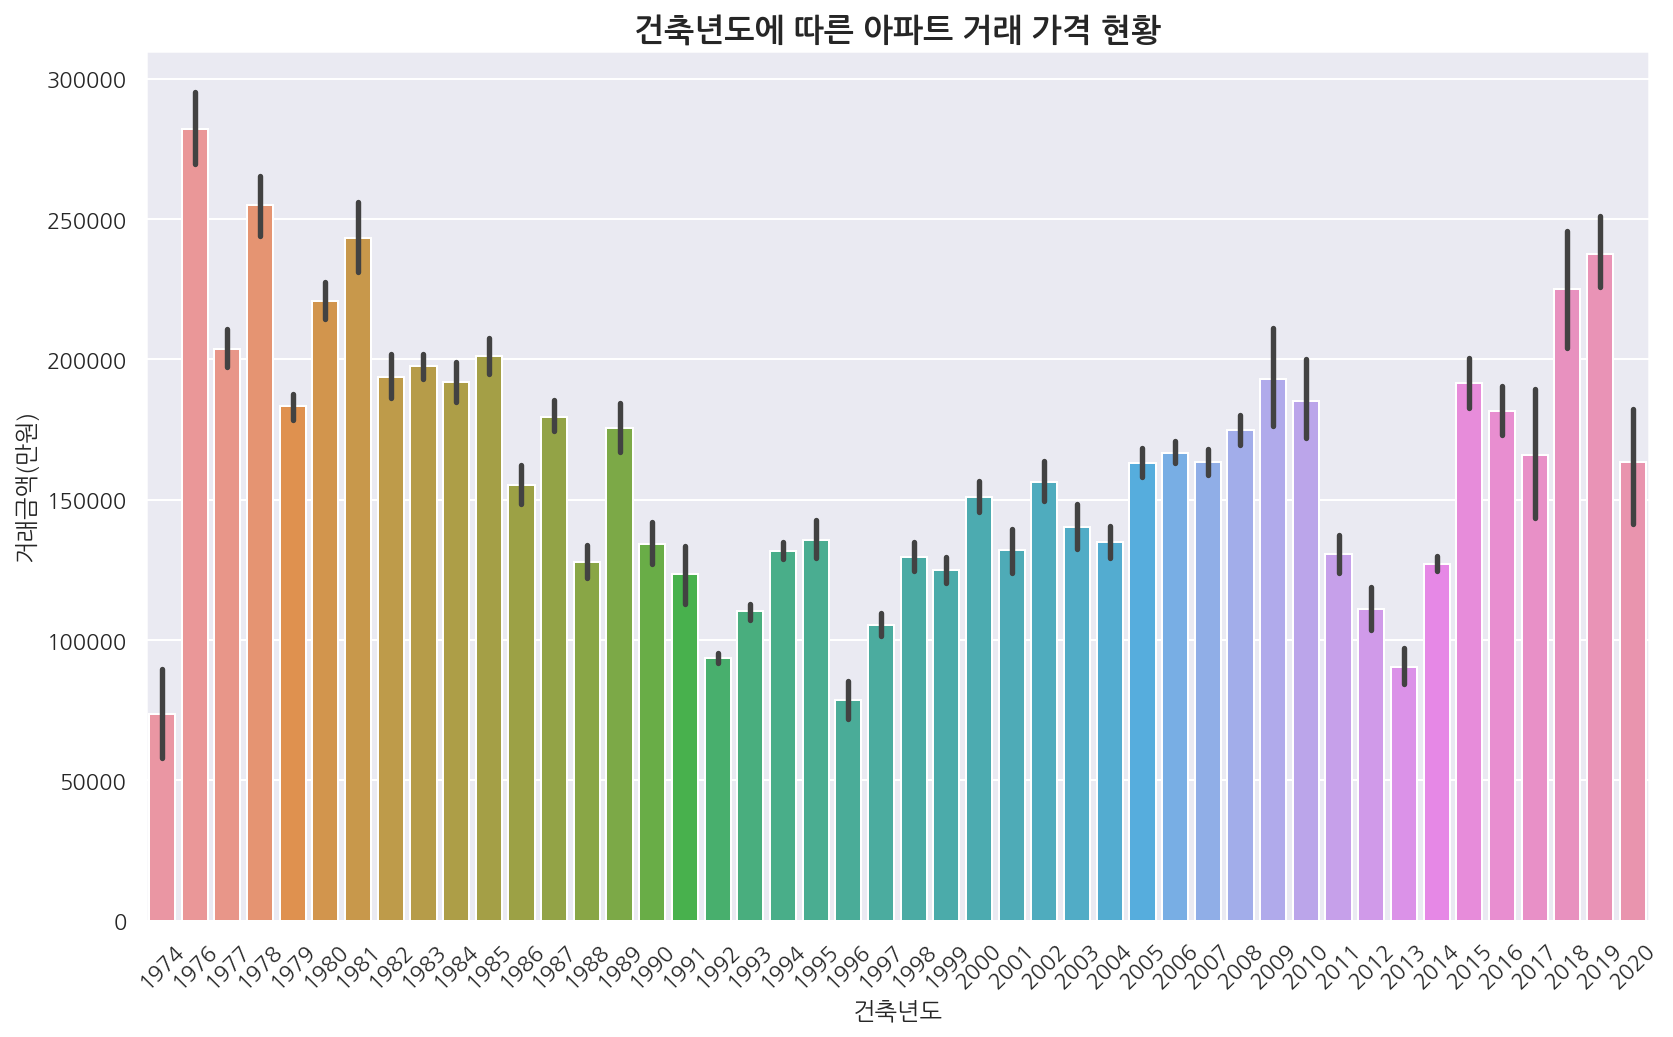

In [23]:
#아파트 건축년도에 따른 거래 아파트 수
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(x='건축년도',y='거래금액(만원)',data=df, ax=ax)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('건축년도에 따른 아파트 거래 가격 현황', loc='center', fontdict = title_font)
plt.xticks(rotation=45)
plt.show()

In [24]:
# 건축년도에 따른 그룹화 -> 변수의 개수를 줄임

df['construction_year_group'] = 0
df.loc[(df['건축년도']  >= 1970)& (df['전용면적(㎡)']< 1980), 'construction_year_group'] = 0
df.loc[(df['건축년도']  >= 1980)& (df['전용면적(㎡)']< 1990), 'construction_year_group'] = 1
df.loc[(df['건축년도']  >= 1990)& (df['전용면적(㎡)']< 2000), 'construction_year_group'] = 2
df.loc[(df['건축년도']  >= 2000)& (df['전용면적(㎡)']< 2010), 'construction_year_group'] = 3
df.loc[(df['건축년도']  >= 2010)& (df['전용면적(㎡)']<= 2020), 'construction_year_group'] = 4  #2020 건축물은 5개밖에 안되어서 포함시켰음
df['construction_year_group'].value_counts()

3    6459
2    4252
1    3300
4    2691
0    1649
Name: construction_year_group, dtype: int64

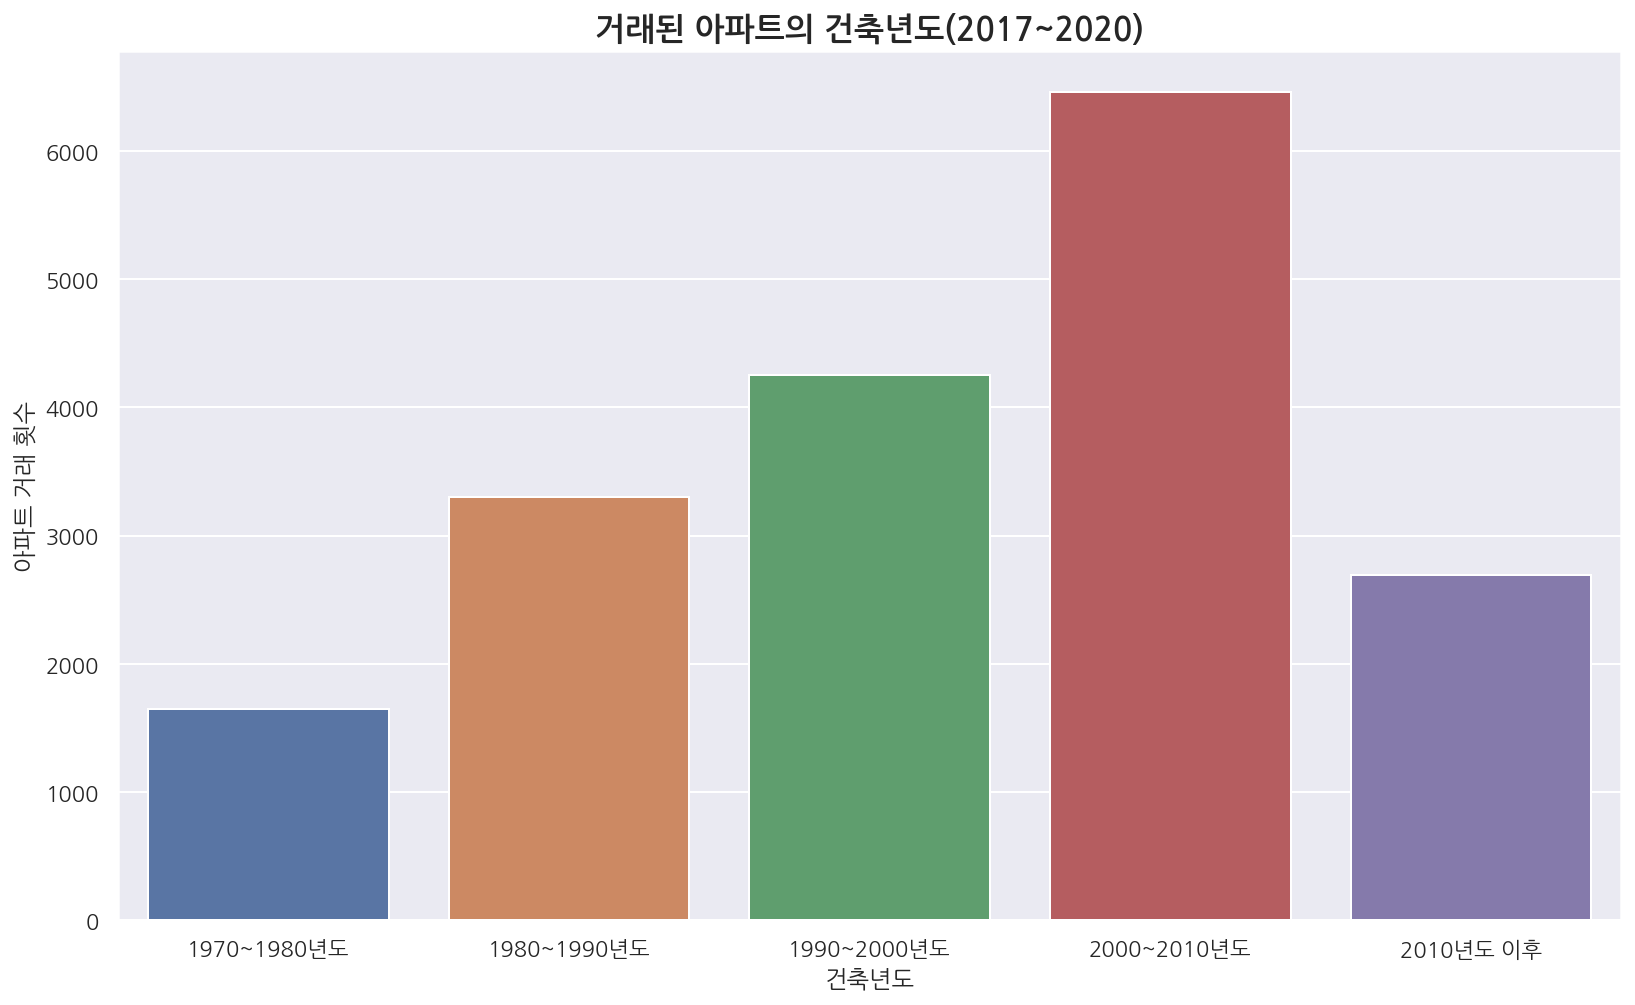

In [25]:
#아파트 건축년도에 따른 거래 아파트 수
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot('construction_year_group',data=df, ax=ax)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('거래된 아파트의 건축년도(2017~2020)', loc='center', fontdict = title_font)
plt.ylabel('아파트 거래 횟수')
xlabels = ['1970~1980년도','1980~1990년도','1990~2000년도', '2000~2010년도', '2010년도 이후']
ax.set_xticklabels(labels=xlabels)
ax.set_xlabel('건축년도')
plt.show()

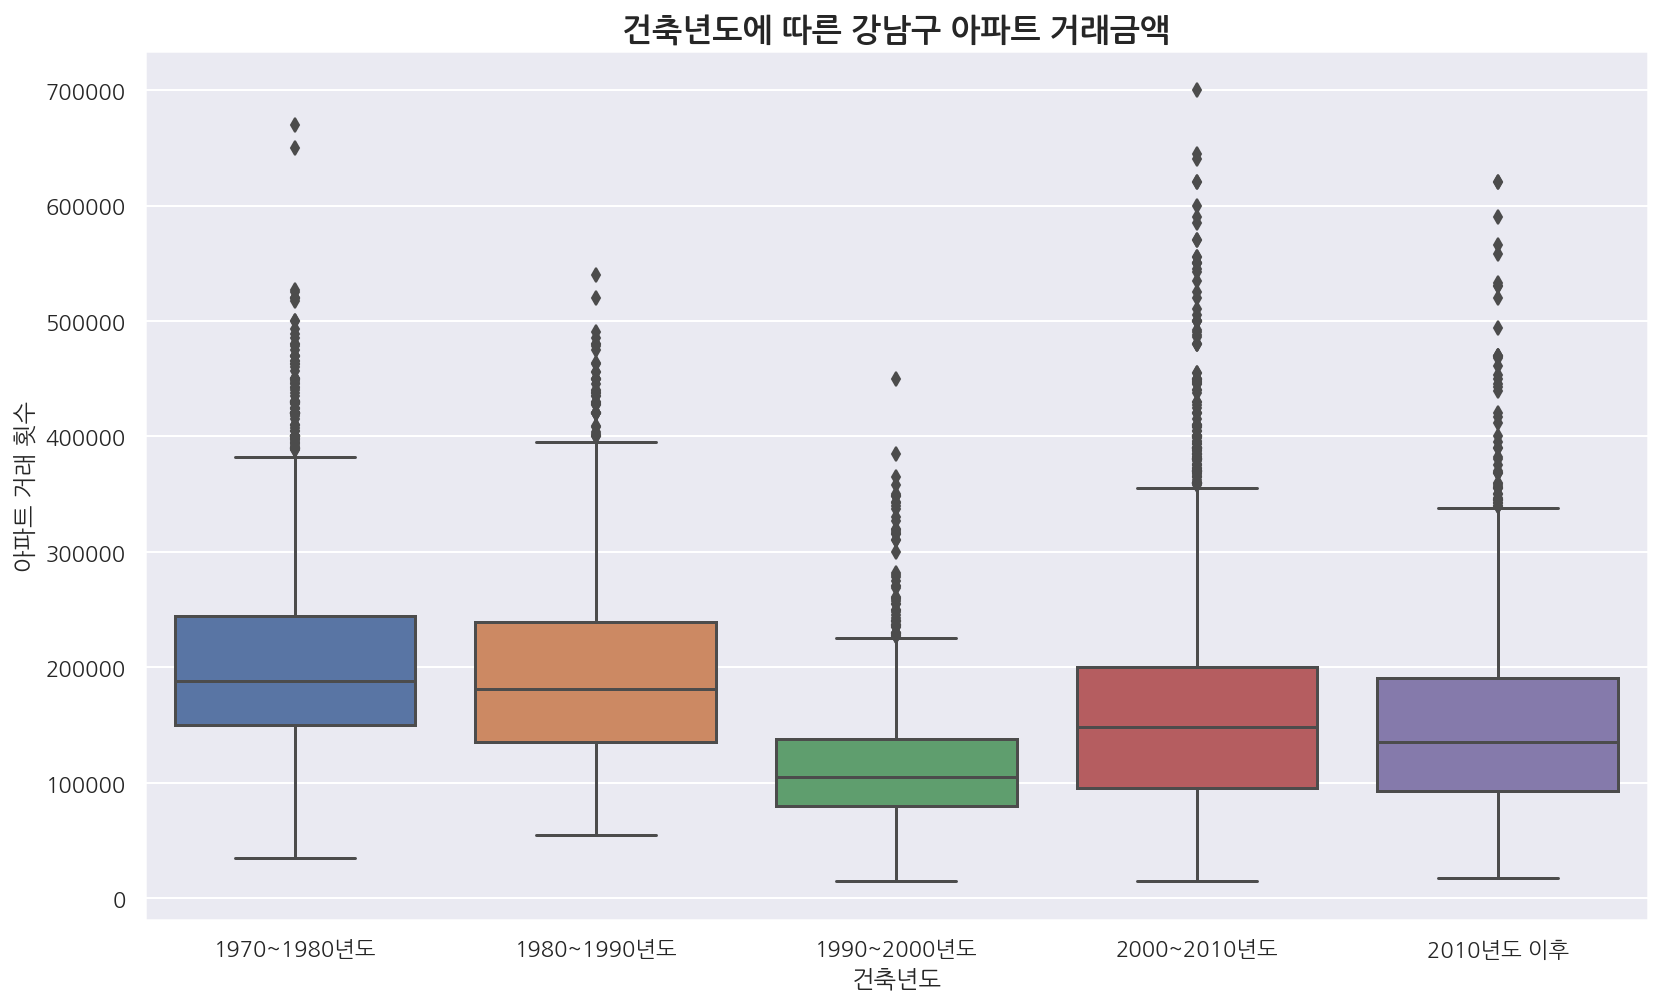

In [26]:
#아파트 건축년도에 따른 거래금액
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(x='construction_year_group',y='거래금액(만원)',data=df, ax=ax)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('건축년도에 따른 강남구 아파트 거래금액', loc='center', fontdict = title_font)
plt.ylabel('아파트 거래 횟수')
xlabels = ['1970~1980년도','1980~1990년도','1990~2000년도', '2000~2010년도', '2010년도 이후']
ax.set_xticklabels(labels=xlabels)
ax.set_xlabel('건축년도')
plt.show()

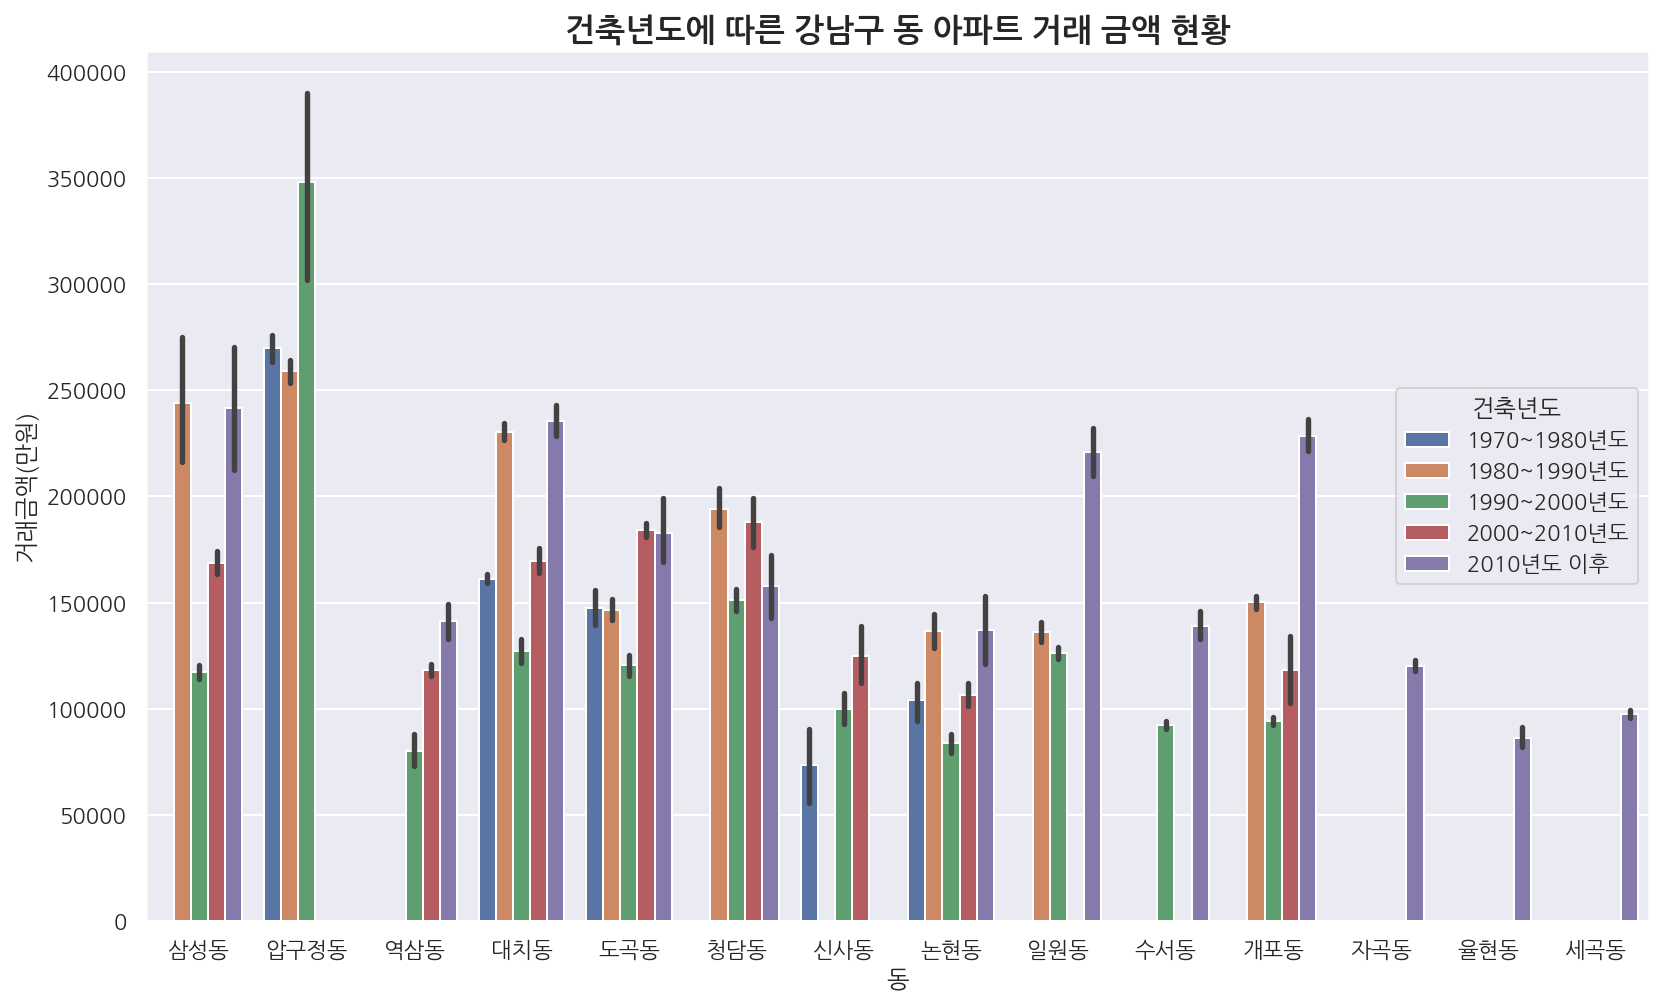

In [27]:
fig, ax = plt.subplots(figsize = (12,8))
g = sns.barplot(x='동', y='거래금액(만원)', hue='construction_year_group', data=df)
#g = sns.barplot(x='동', y='거래금액(만원)', hue='construction_year_group', data=df, order=['압구정동', '삼성동', '대치동','개포동','일원동','청담동', '도곡동','논현동','신사동','역삼동','수서동','자곡동','세곡동','율현동'])
g.legend(title='건축년도', loc='right')
g.legend_.texts[0].set_text('1970~1980년도')
g.legend_.texts[1].set_text('1980~1990년도')
g.legend_.texts[2].set_text('1990~2000년도')
g.legend_.texts[3].set_text('2000~2010년도')
g.legend_.texts[4].set_text('2010년도 이후')

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('건축년도에 따른 강남구 동 아파트 거래 금액 현황', loc='center', fontdict = title_font)
plt.show()

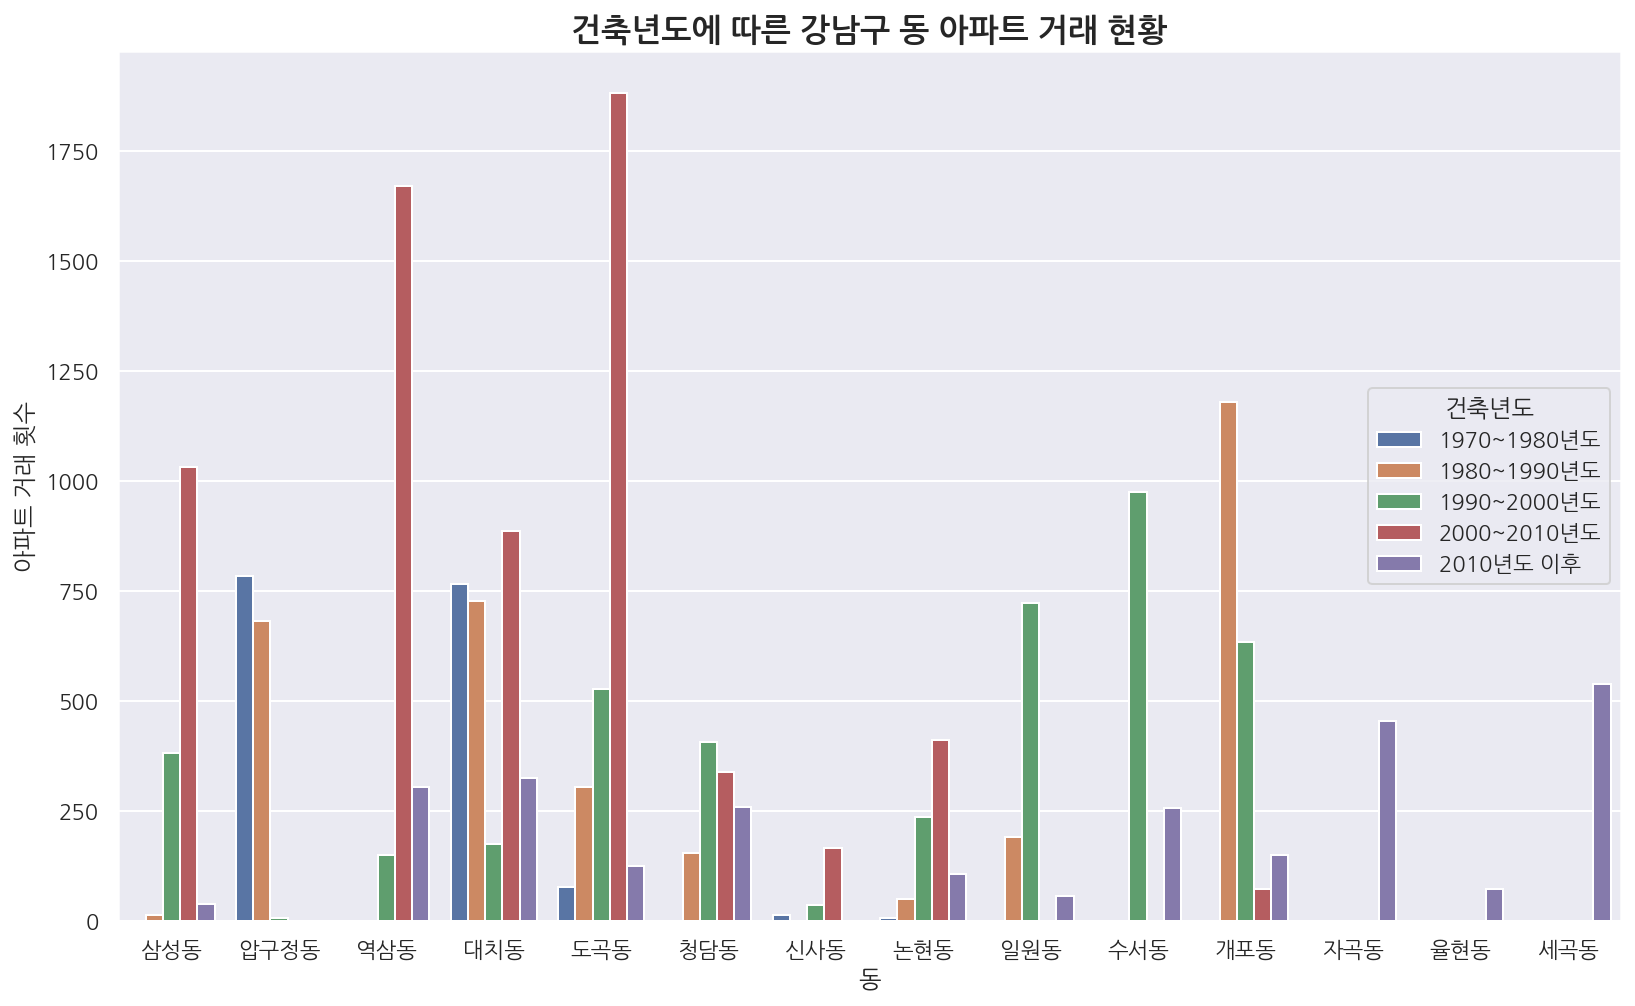

In [28]:
fig, ax = plt.subplots(figsize = (12,8))
g = sns.countplot(x='동', hue='construction_year_group', data=df)
g.legend(title='건축년도', loc='right')
g.legend_.texts[0].set_text('1970~1980년도')
g.legend_.texts[1].set_text('1980~1990년도')
g.legend_.texts[2].set_text('1990~2000년도')
g.legend_.texts[3].set_text('2000~2010년도')
g.legend_.texts[4].set_text('2010년도 이후')

g.set_ylabel('아파트 거래 횟수')
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('건축년도에 따른 강남구 동 아파트 거래 현황', loc='center', fontdict = title_font)
plt.show()

## 아파트 전용면적

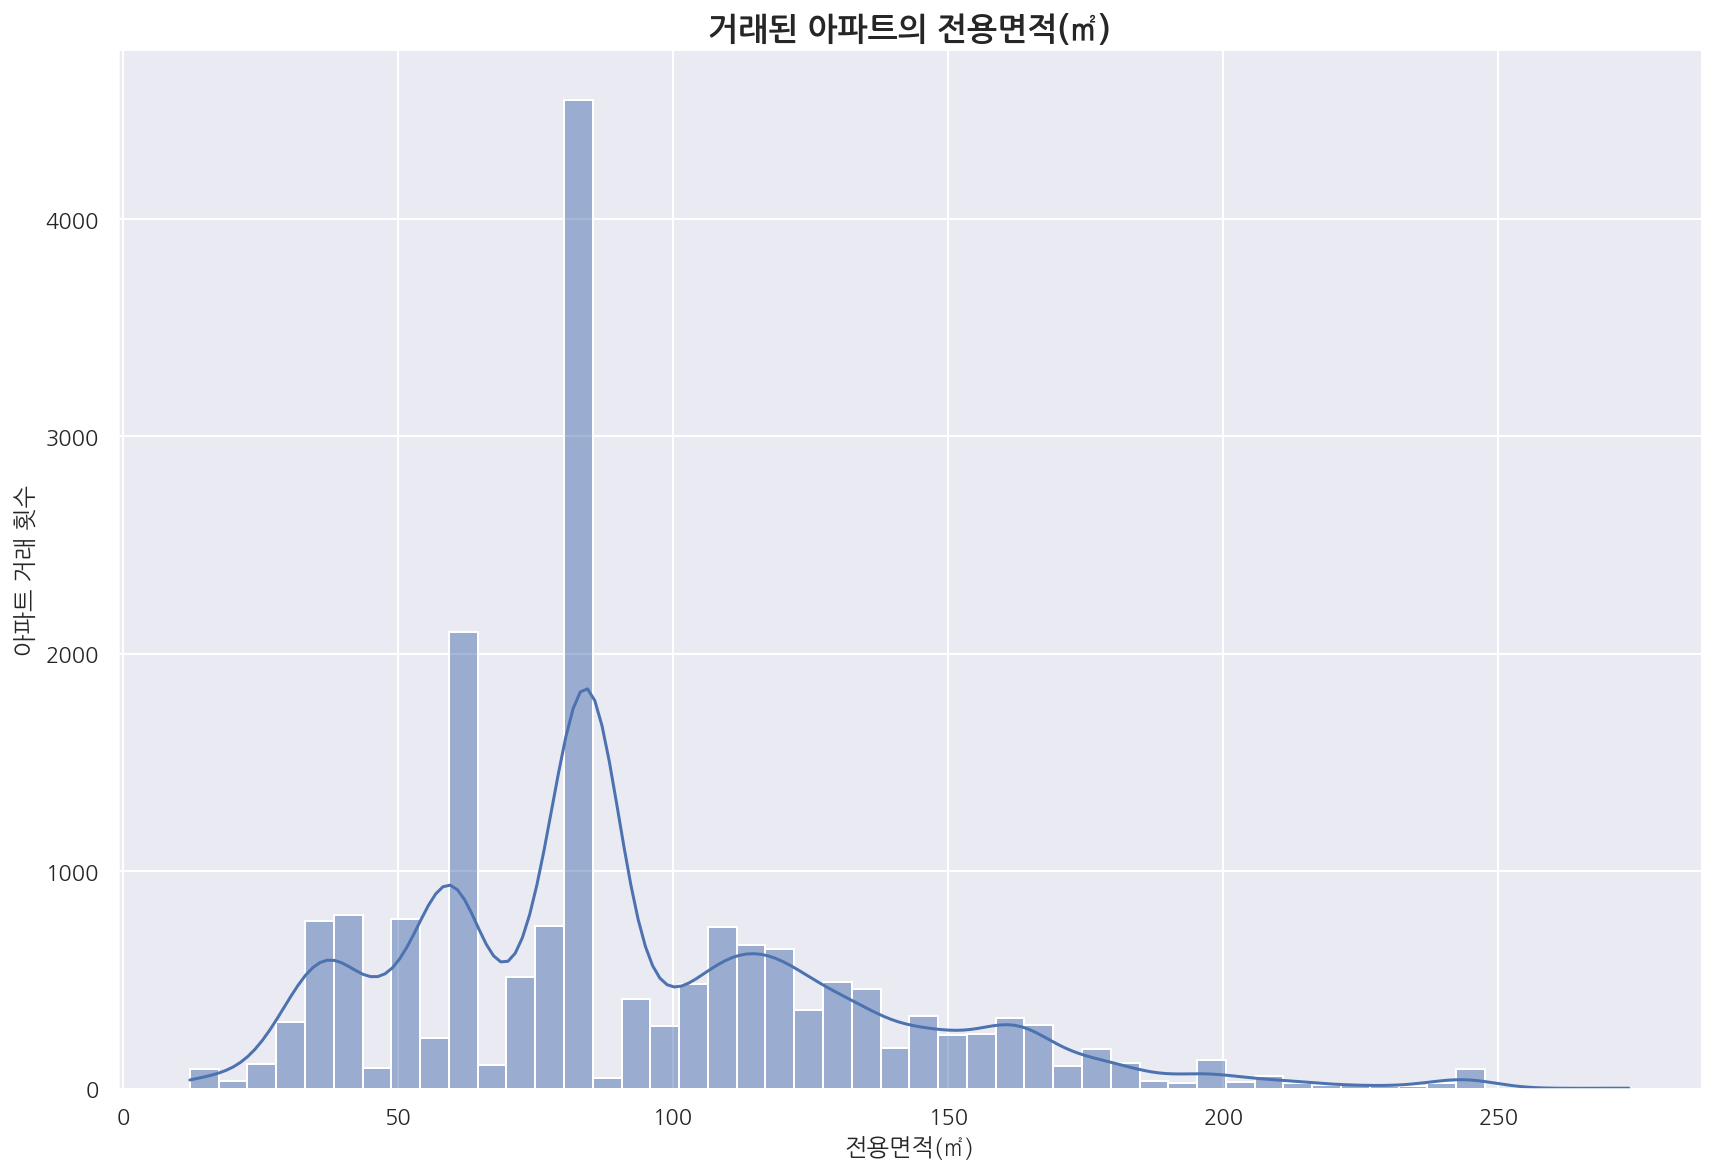

In [29]:
sns.displot(df['전용면적(㎡)'], bins=50,  kde=True, height = 8, aspect=1.5)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('거래된 아파트의 전용면적(㎡)', loc='center', fontdict = title_font)
plt.ylabel('아파트 거래 횟수')
plt.show()

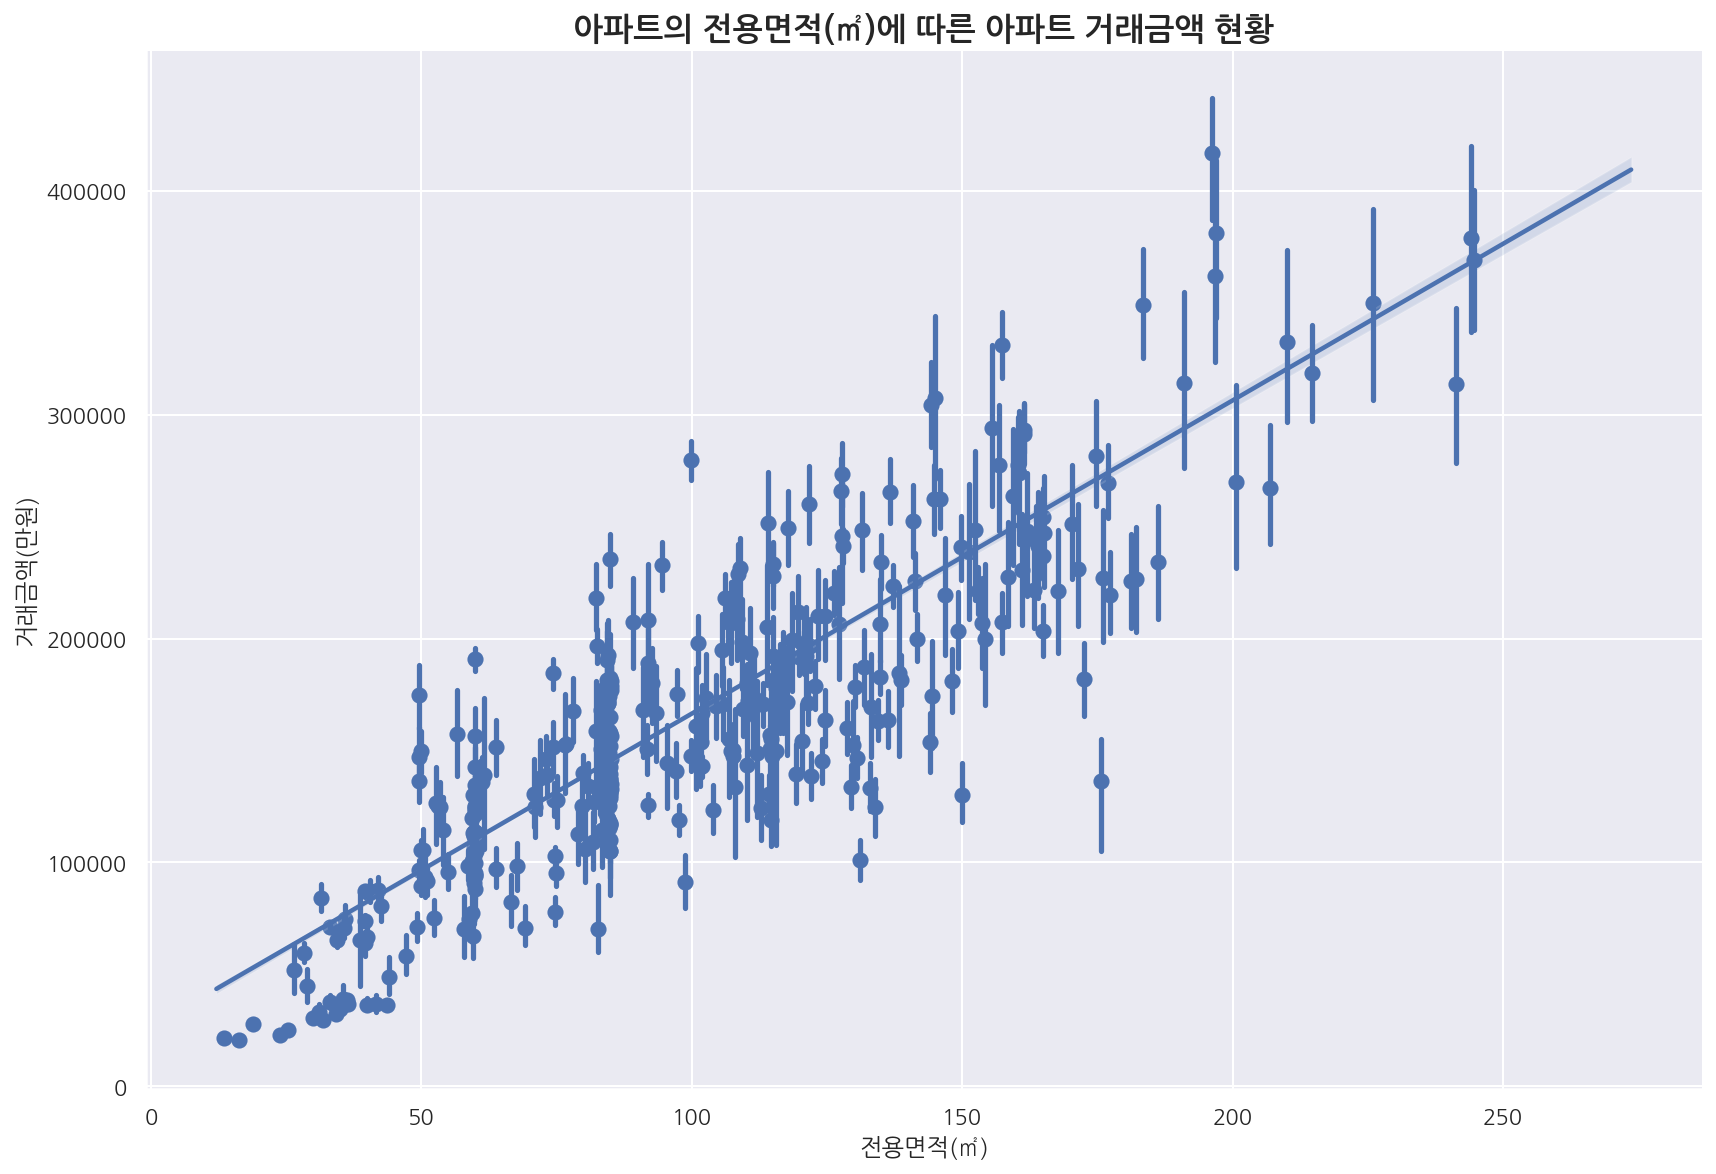

In [30]:
sns.lmplot(x='전용면적(㎡)', y='거래금액(만원)', x_bins=500 ,data=df, height = 8, aspect=1.5)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('아파트의 전용면적(㎡)에 따른 아파트 거래금액 현황', loc='center', fontdict = title_font)
plt.show()

In [31]:
df['area_range'] = pd.qcut(df['전용면적(㎡)'], 4) # 4분위수로 자른다.
df.groupby(['area_range'])['거래금액(만원)'].mean().to_frame().style.background_gradient(cmap='summer_r')

In [32]:
df['area_range_group'] = 0
df.loc[(df['전용면적(㎡)']  > 12.099)& (df['전용면적(㎡)']<=59.97), 'area_range_group'] = 0
df.loc[(df['전용면적(㎡)']  > 59.97)& (df['전용면적(㎡)']<=84.87), 'area_range_group'] = 1
df.loc[(df['전용면적(㎡)'] > 84.87)&(df['전용면적(㎡)']<=115.24), 'area_range_group'] = 2
df.loc[(df['전용면적(㎡)'] > 115.24)&(df['전용면적(㎡)']<=273.68), 'area_range_group'] = 3

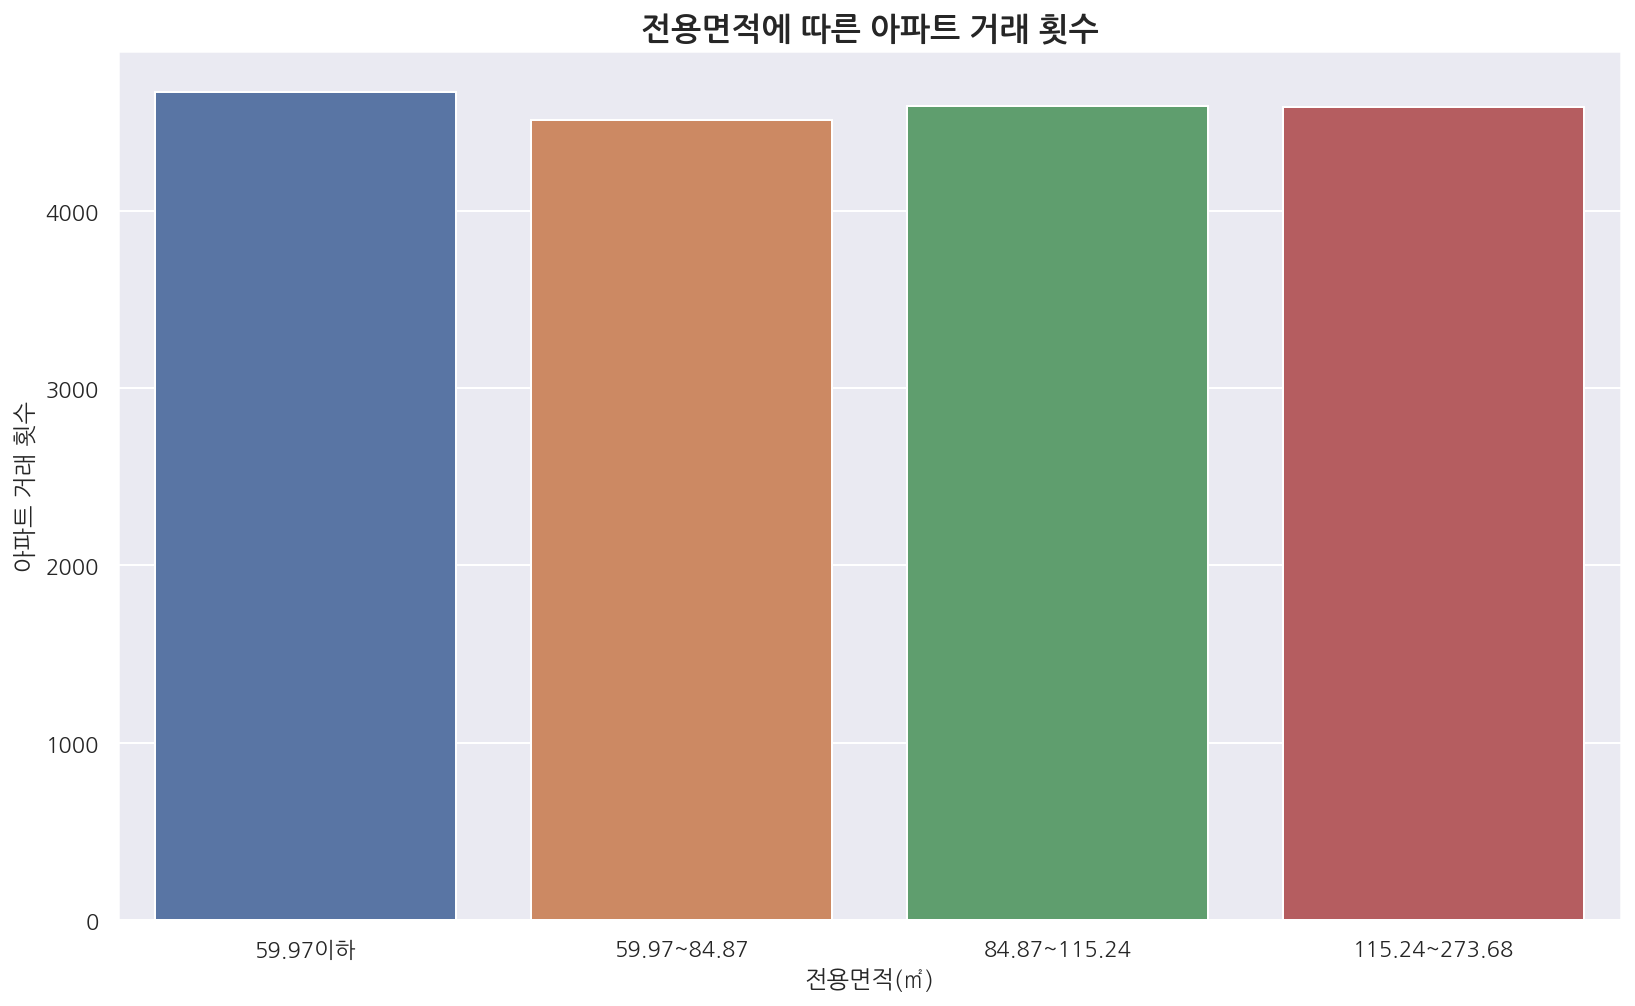

In [33]:
#아파트 전용면적에 따른 거래 아파트 수
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot('area_range_group',data=df, ax=ax)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('전용면적에 따른 아파트 거래 횟수', loc='center', fontdict = title_font)
plt.ylabel('아파트 거래 횟수')
xlabels = ['59.97이하','59.97~84.87','84.87~115.24', '115.24~273.68']
ax.set_xticklabels(labels=xlabels)
ax.set_xlabel('전용면적(㎡)')
plt.show()

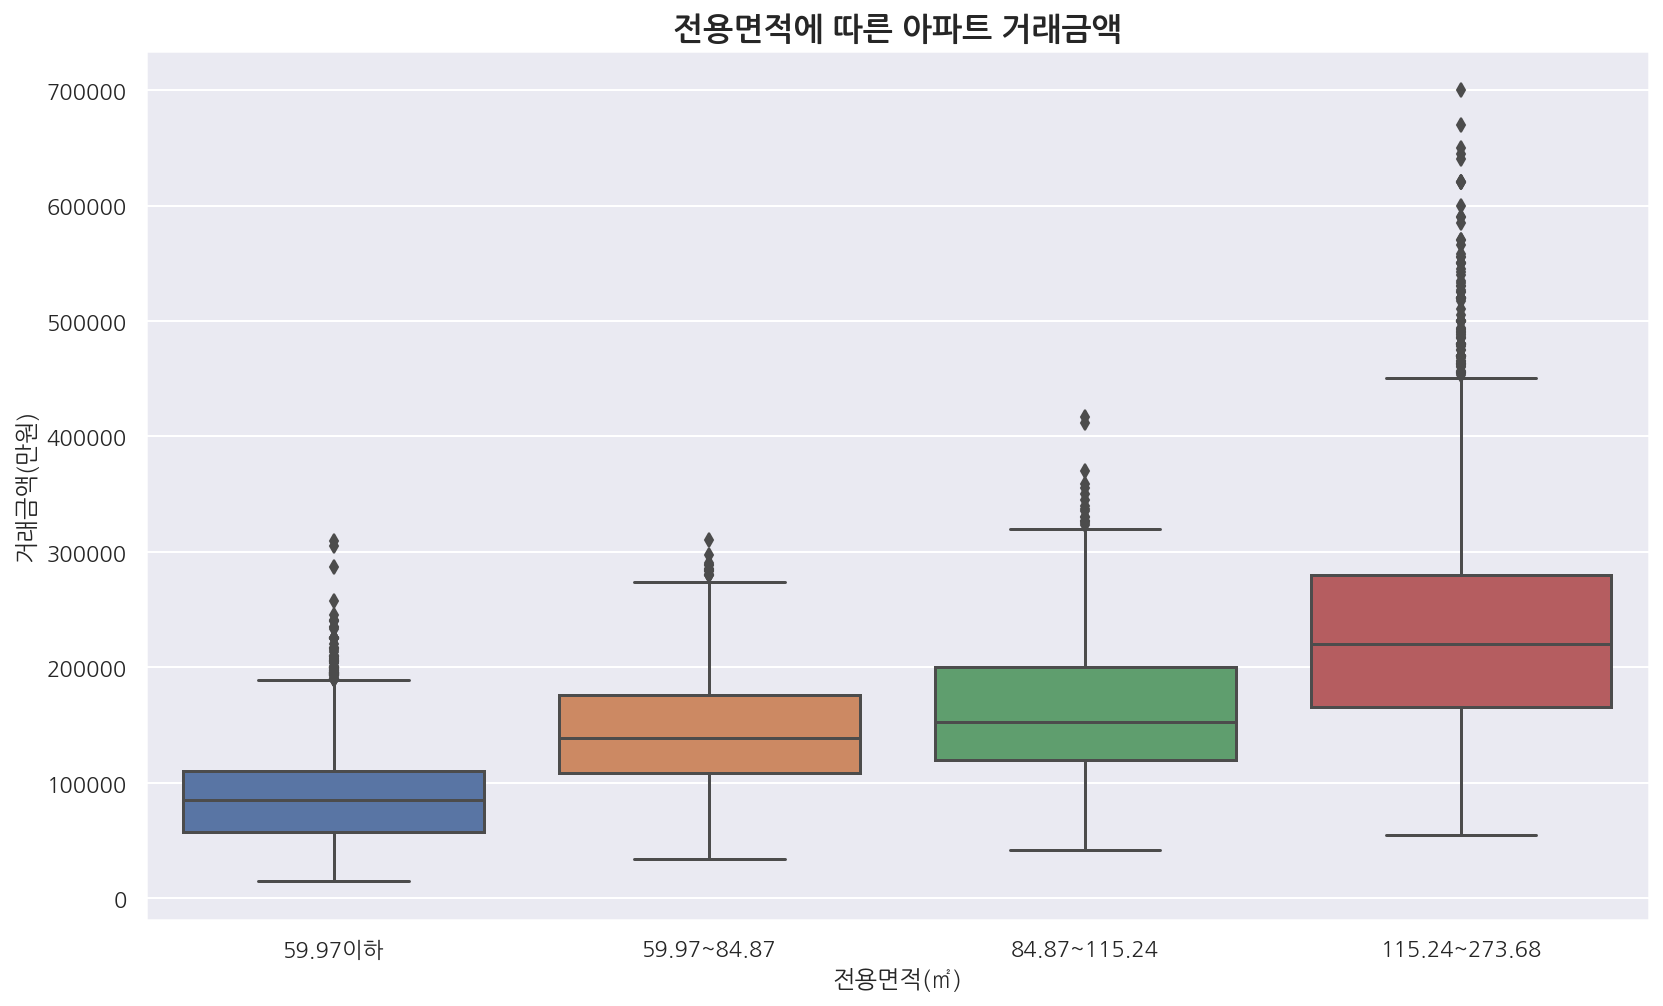

In [34]:
#아파트 전용면적에 따른 거래금액
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(x='area_range_group',y='거래금액(만원)',data=df, ax=ax)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('전용면적에 따른 아파트 거래금액', loc='center', fontdict = title_font)
xlabels = ['59.97이하','59.97~84.87','84.87~115.24', '115.24~273.68']
ax.set_xticklabels(labels=xlabels)
ax.set_xlabel('전용면적(㎡)')
plt.show()

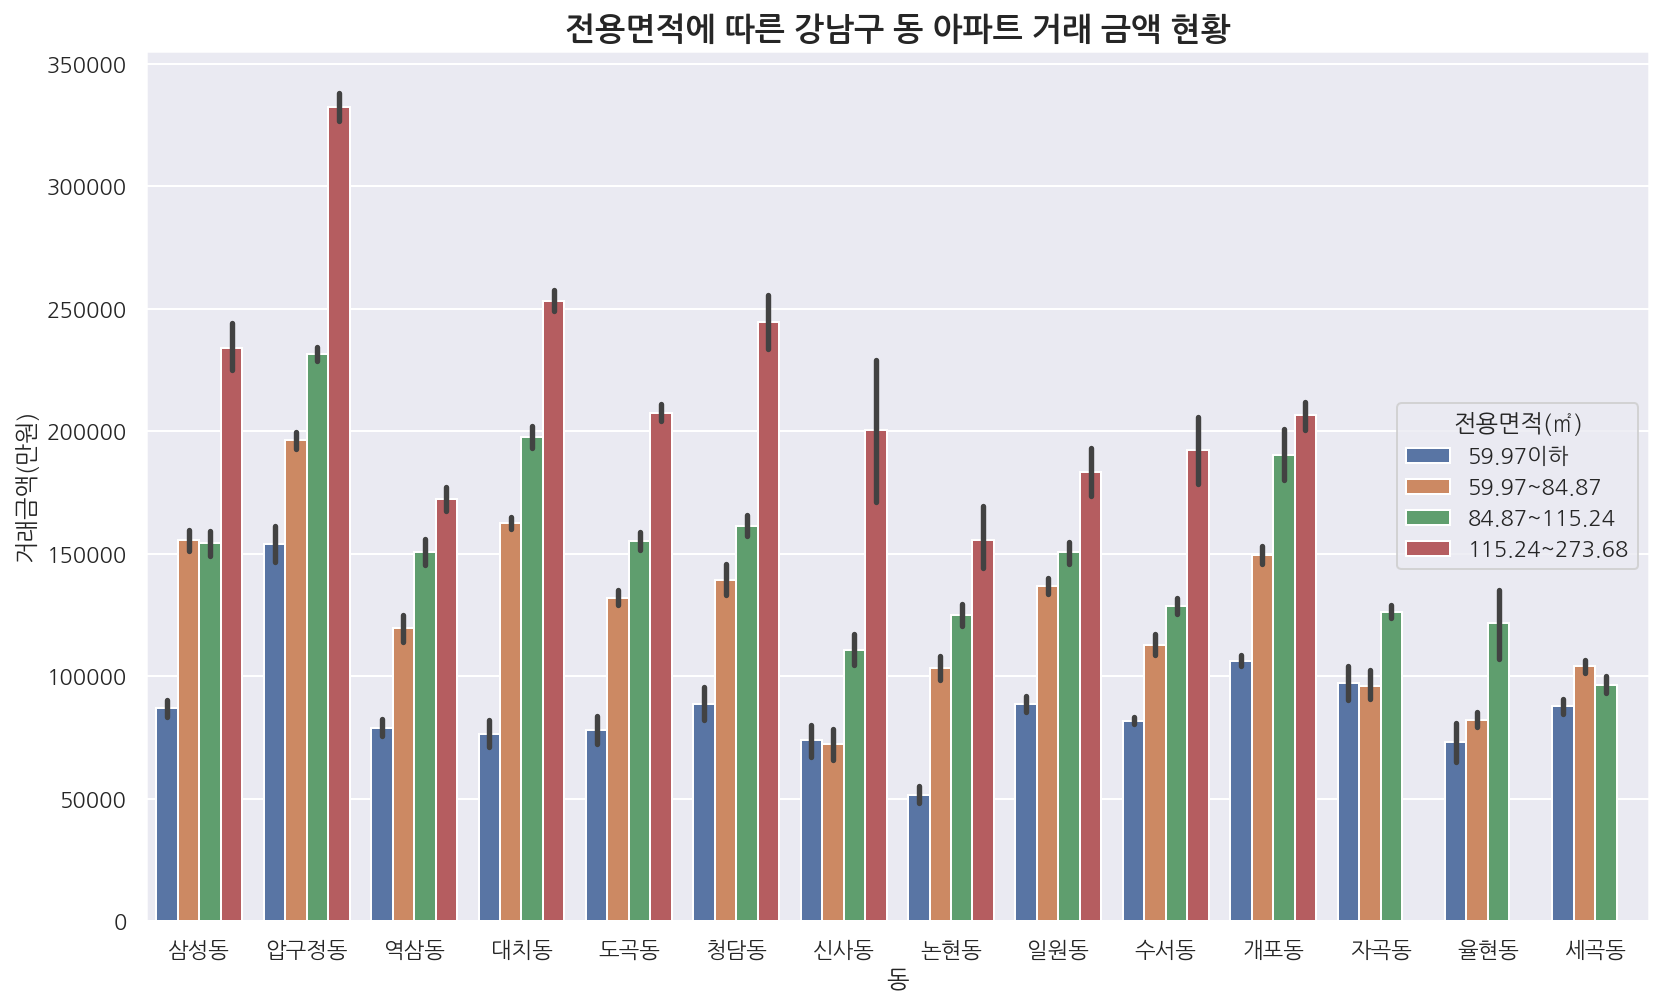

In [35]:
fig, ax = plt.subplots(figsize = (12,8))
g = sns.barplot(x='동', y='거래금액(만원)', hue='area_range_group', data=df)

legend_label =  ['59.97이하','59.97~84.87','84.87~115.24', '115.24~273.68']
g.legend(title="전용면적(㎡)", loc='right')

for i in range(len(legend_label)):
    g.legend_.texts[i].set_text(legend_label[i])

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('전용면적에 따른 강남구 동 아파트 거래 금액 현황', loc='center', fontdict = title_font)
plt.show()

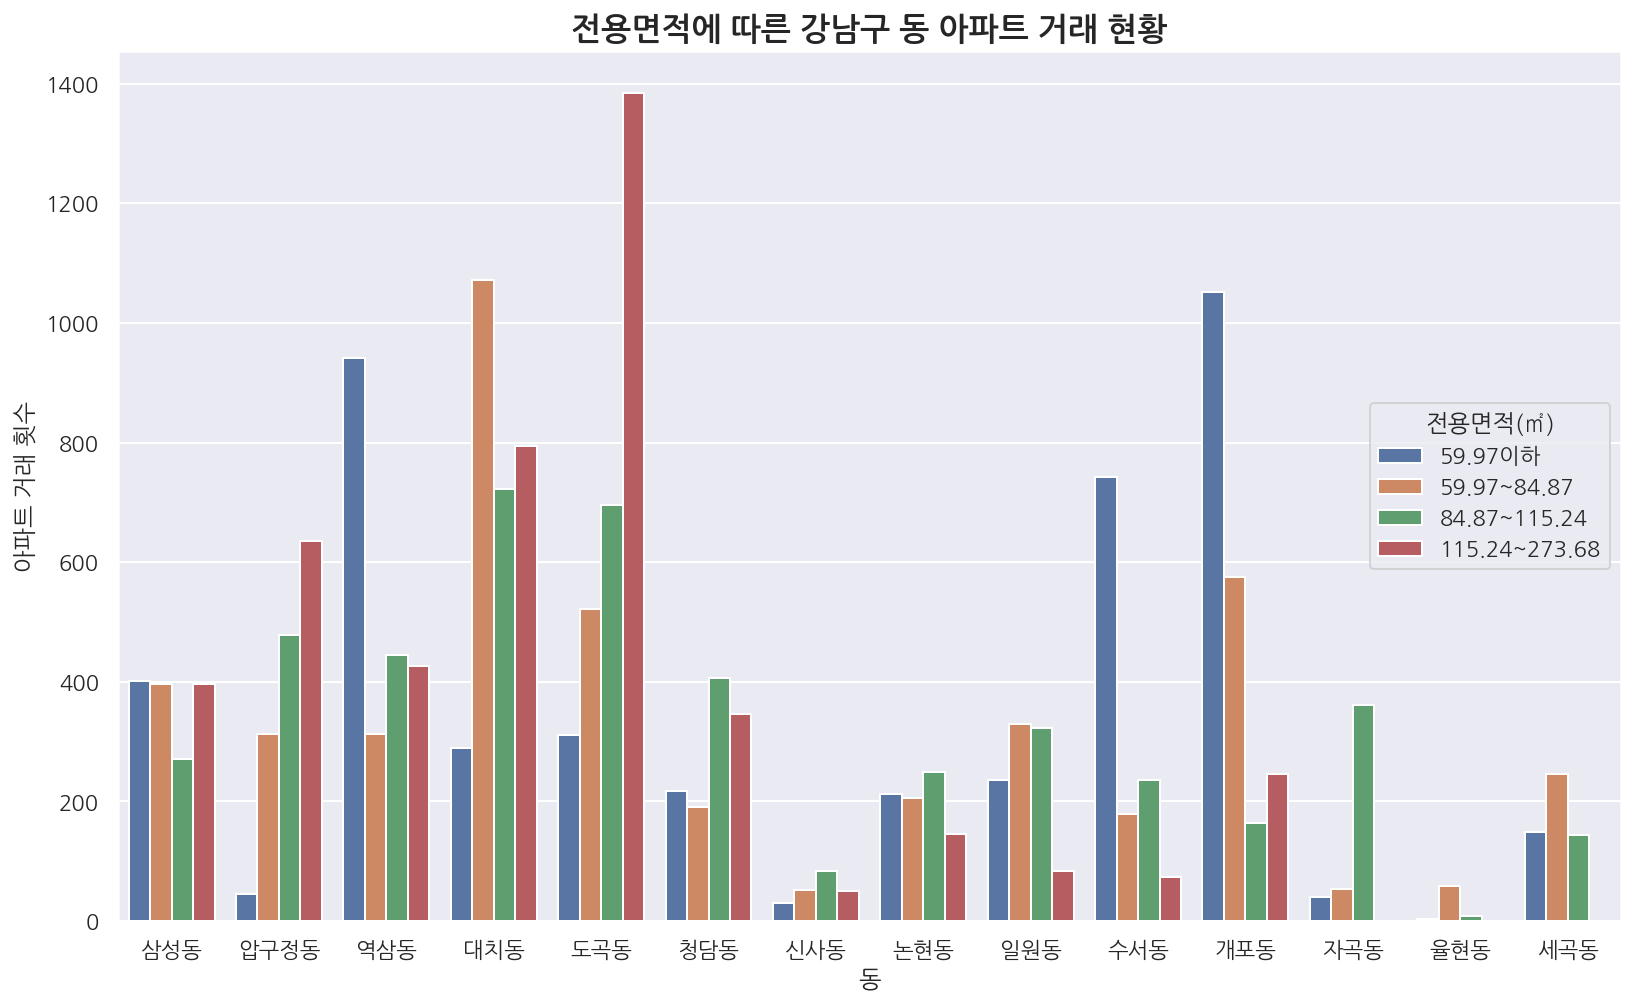

In [36]:
fig, ax = plt.subplots(figsize = (12,8))
g = sns.countplot(x='동', hue='area_range_group', data=df)

legend_label =  ['59.97이하','59.97~84.87','84.87~115.24', '115.24~273.68']
g.legend(title="전용면적(㎡)", loc='right')
for i in range(len(legend_label)):
    g.legend_.texts[i].set_text(legend_label[i])

g.set_ylabel('아파트 거래 횟수')
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('전용면적에 따른 강남구 동 아파트 거래 현황', loc='center', fontdict = title_font)
plt.show()

## 아파트 층수

In [37]:
df['층'].value_counts()

 4     1445
 5     1374
 3     1339
 2     1260
 6     1250
       ... 
 67       2
-1        2
 56       1
 64       1
 68       1
Name: 층, Length: 68, dtype: int64

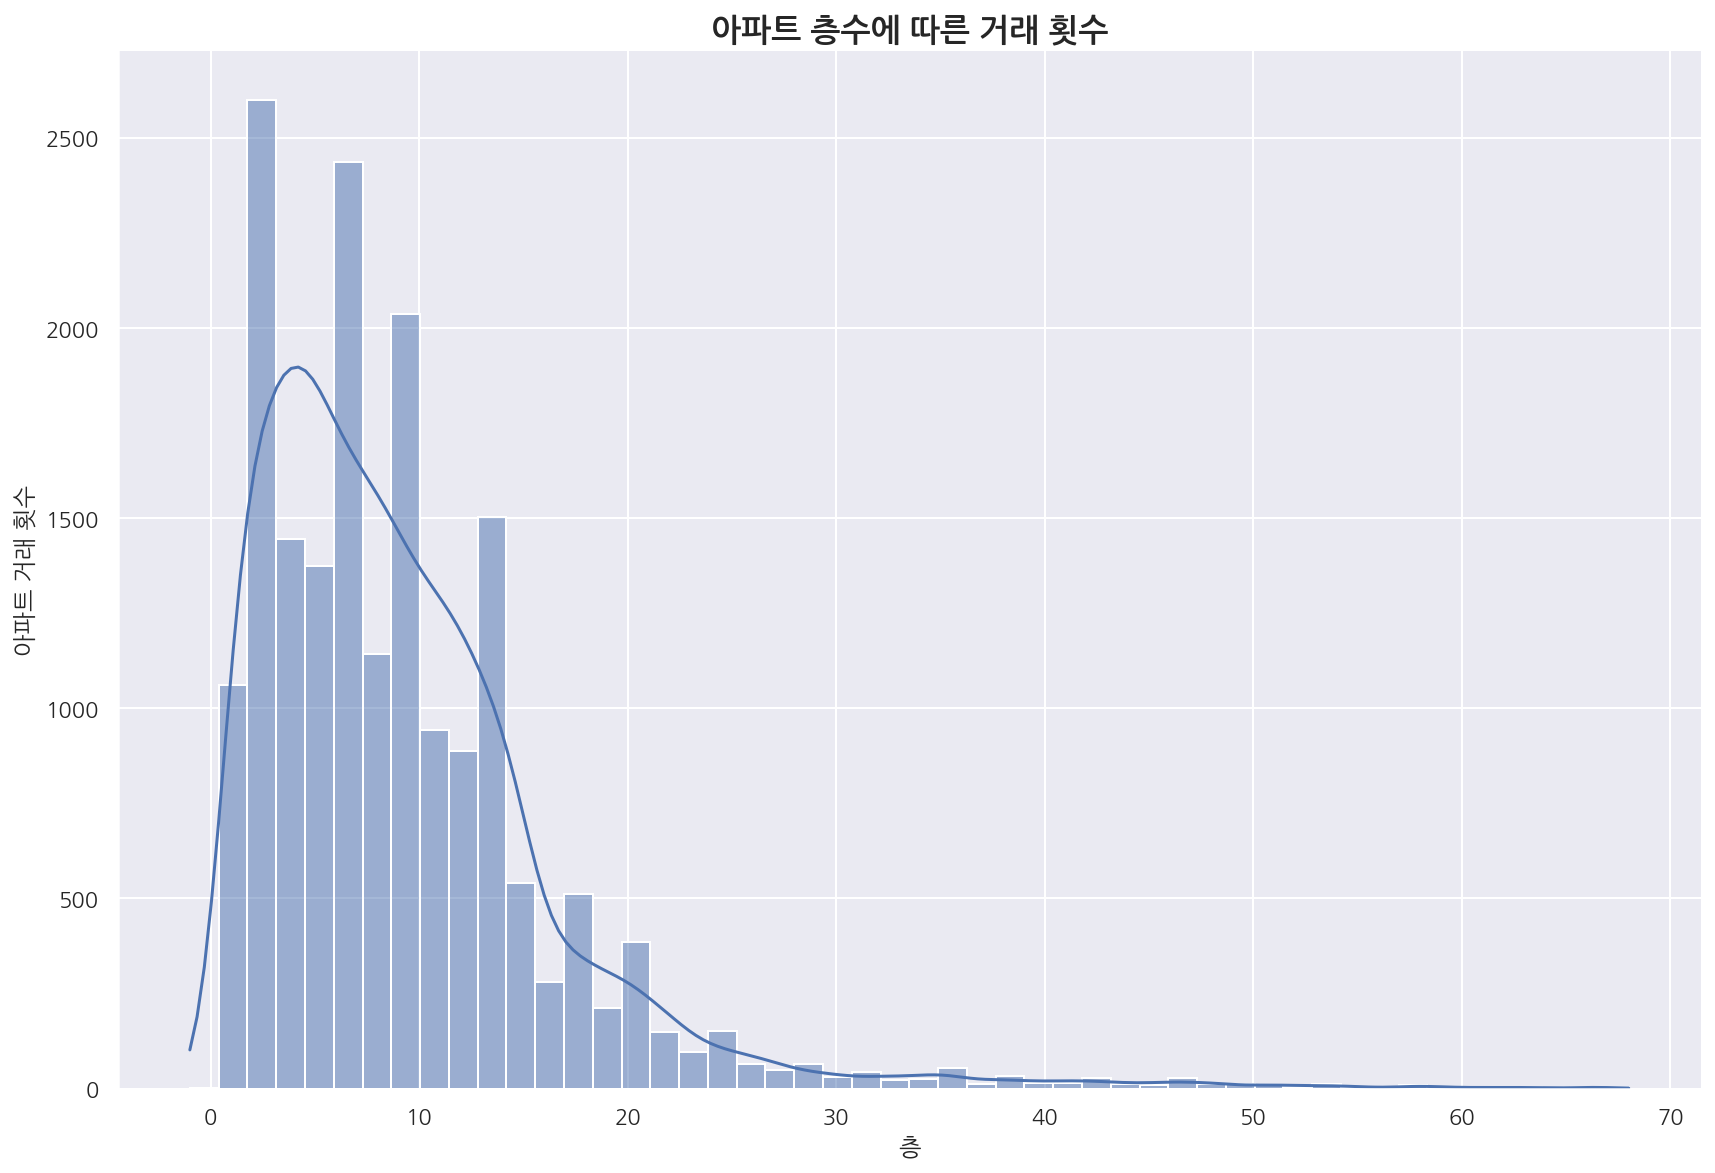

In [38]:
#아파트 층수에 따른 거래 아파트 수

sns.displot(df['층'], bins=50,  kde=True, height = 8, aspect=1.5)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('아파트 층수에 따른 거래 횟수', loc='center', fontdict = title_font)
plt.ylabel('아파트 거래 횟수')
plt.show()

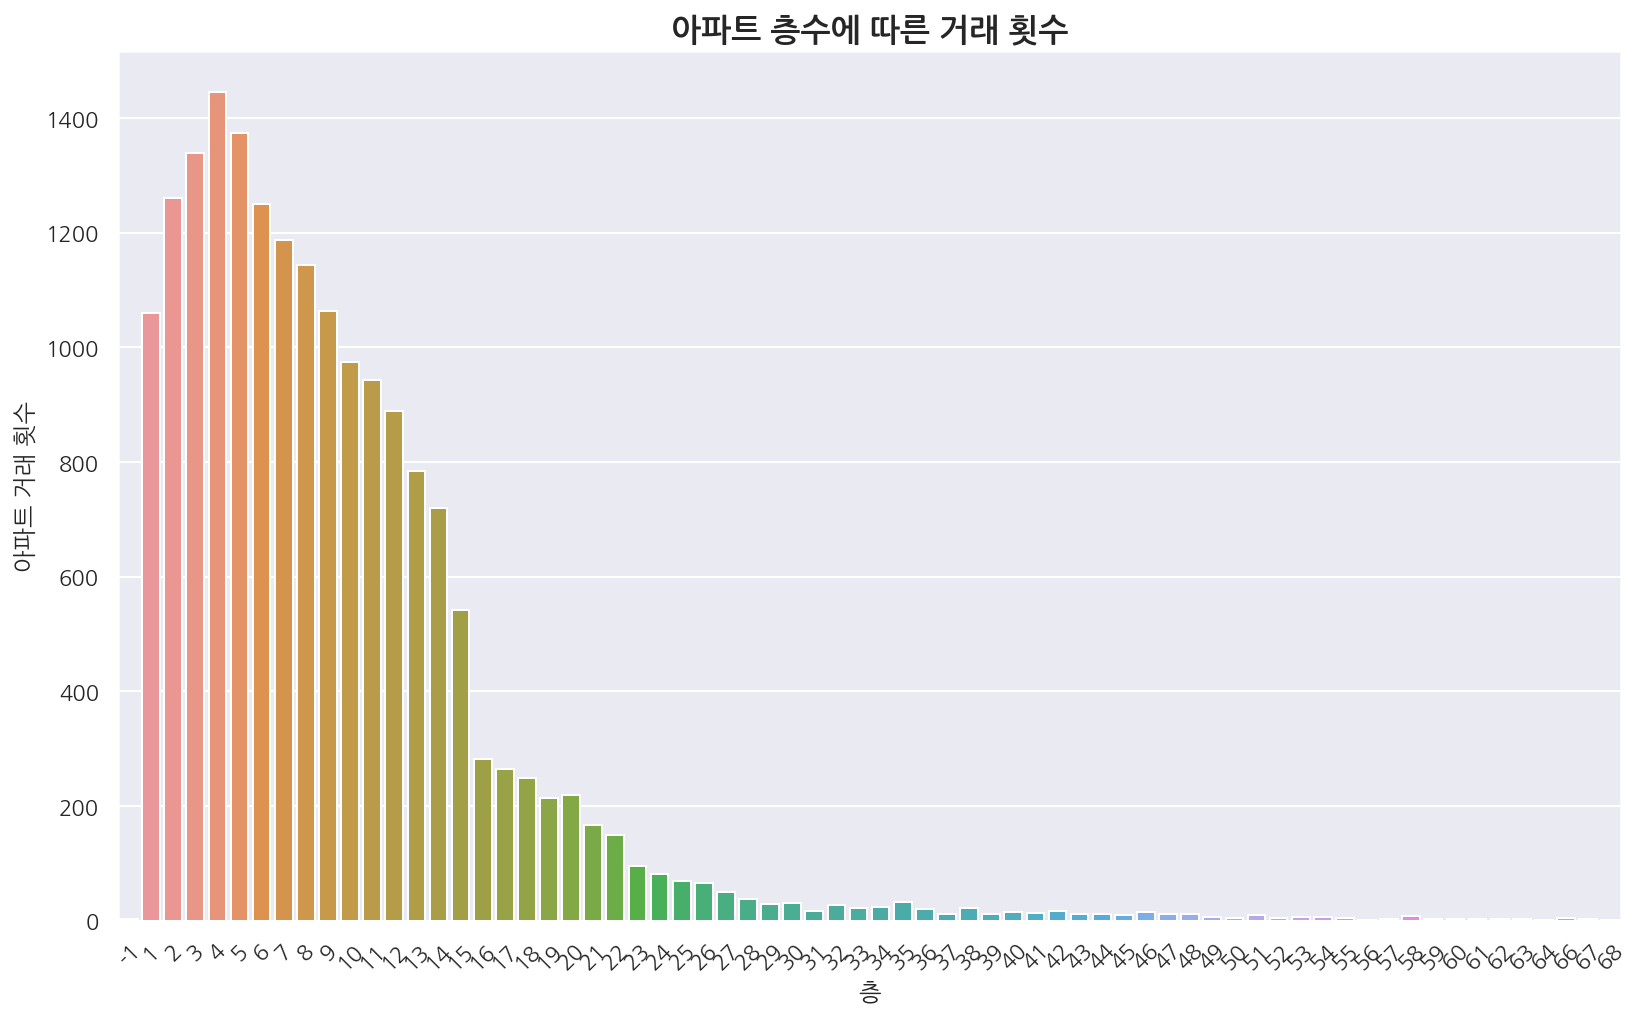

In [39]:
#아파트 층수에 따른 거래 아파트 수
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot('층',data=df, ax=ax)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('아파트 층수에 따른 거래 횟수', loc='center', fontdict = title_font)
plt.ylabel('아파트 거래 횟수')
plt.xticks(rotation=45)
plt.show()

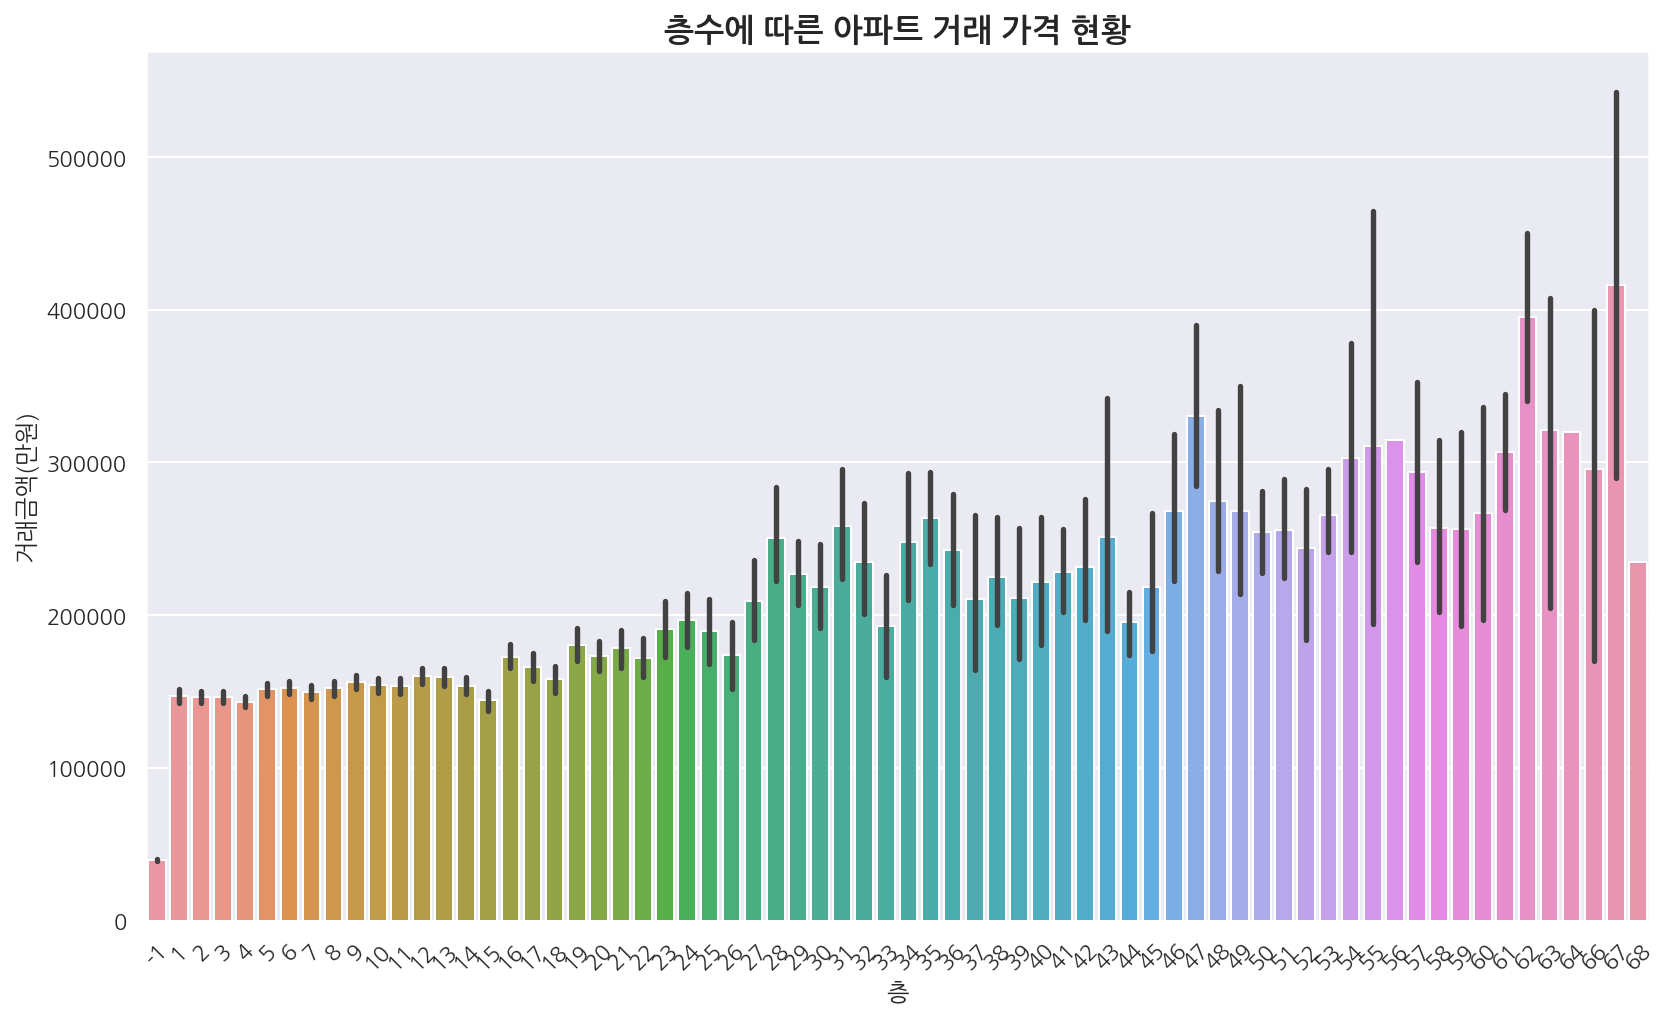

In [40]:
#아파트 층수에 따른 아파트 거래금액
fig, ax = plt.subplots(figsize = (12,8))
sns.barplot(x='층',y='거래금액(만원)',data=df, ax=ax)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('층수에 따른 아파트 거래 가격 현황', loc='center', fontdict = title_font)
plt.xticks(rotation=45)
plt.show()

In [41]:
# High cardinality를 방지하기 위해, 층수를 그룹화 합니다.
# 제일 거래횟수가 많은 ~15층 까지는 5단위, 그 이후에는 10단위로 그룹화 합니다.
df['floor_group'] = 0

df.loc[(df['층']<= 5), 'floor_group'] = 0  # 지하층은 거래 횟수가 소수(2번)이기에, 해당 그룹에 포함시킵니다
df.loc[(df['층']  > 5)& (df['층']<=10), 'floor_group'] = 1
df.loc[(df['층']  > 10)& (df['층']<=15), 'floor_group'] = 2
df.loc[(df['층']  > 15)& (df['층']<=25), 'floor_group'] = 3
df.loc[(df['층']  > 25)& (df['층']<=35), 'floor_group'] = 4
df.loc[(df['층']  > 35)& (df['층']<=45), 'floor_group'] = 5
df.loc[(df['층']  > 45)& (df['층']<=55), 'floor_group'] = 6
df.loc[(df['층']  > 55)& (df['층']<=65), 'floor_group'] = 7
df.loc[(df['층']  > 65), 'floor_group'] = 8

In [42]:
df['층'].unique()

array([ 9, 17, 18, 10, 19, 12,  3, 14, 11, 13,  7, 15,  4, 16,  8, 20,  1,
        5,  2,  6, 24, 21, 22, 23, 26, 27, 29, 28, 25, 38, 43, 41, 33, 36,
       42, 40, 35, 30, 46, 44, 51, 47, 37, 39, 34, 31, 45, 55, 54, 49, 32,
       48, 53, 52, 50, 58, 66, 61, 59, 60, 57, 62, 63, 56, 67, 64, 68, -1])

In [43]:
df['floor_group'].value_counts()

0    6480
1    5619
2    3875
3    1788
4     334
5     145
6      80
7      23
8       7
Name: floor_group, dtype: int64

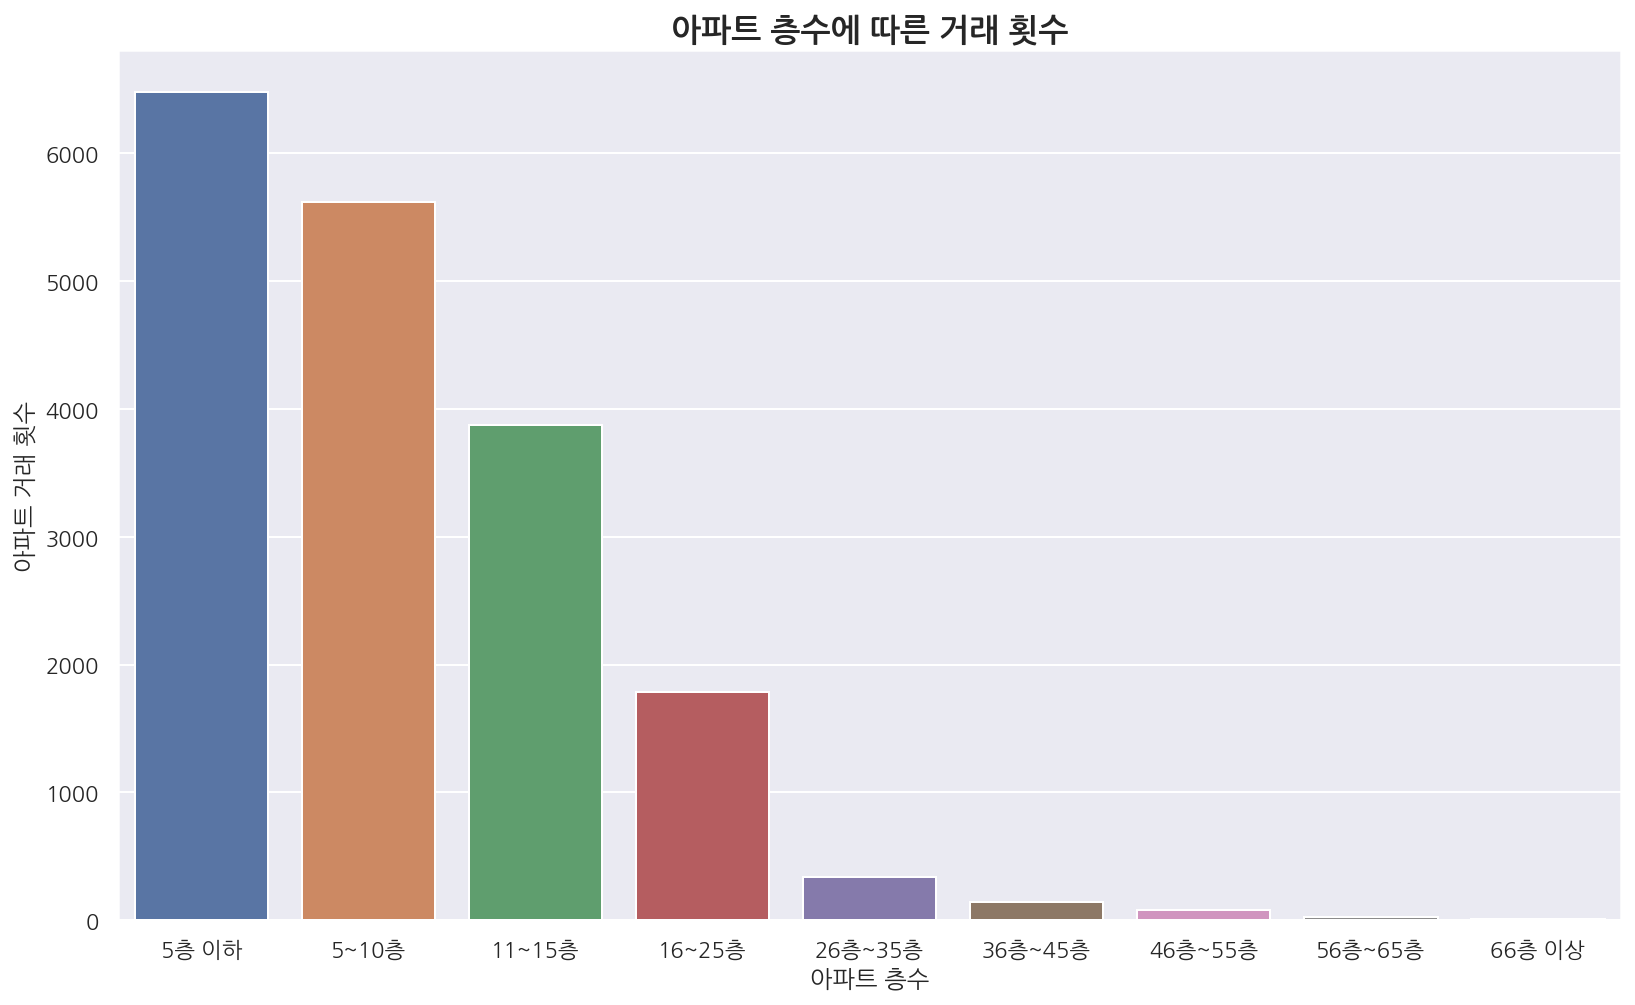

In [44]:
#아파트 건축년도에 따른 거래 아파트 수
fig, ax = plt.subplots(figsize = (12,8))
sns.countplot('floor_group',data=df, ax=ax)
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('아파트 층수에 따른 거래 횟수', loc='center', fontdict = title_font)
plt.ylabel('아파트 거래 횟수')
xlabels = ['5층 이하','5~10층','11~15층', '16~25층', '26층~35층','36층~45층','46층~55층', '56층~65층', '66층 이상']
ax.set_xticklabels(labels=xlabels)
ax.set_xlabel('아파트 층수')
plt.show()

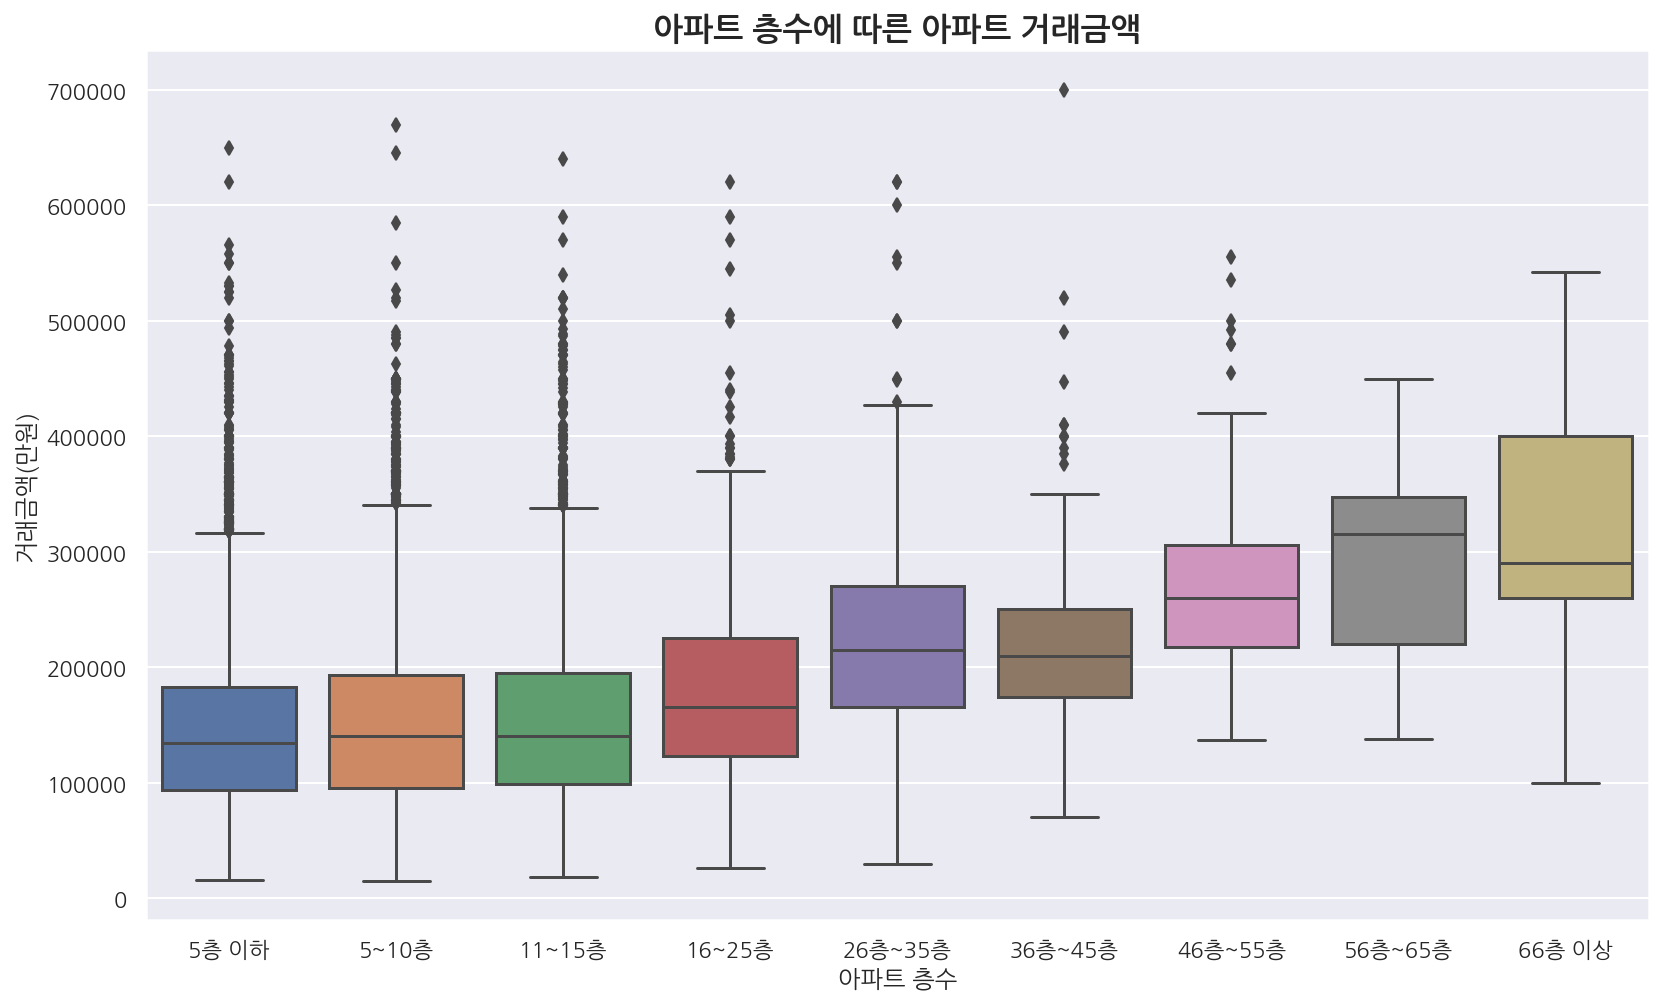

In [45]:
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(x='floor_group', y='거래금액(만원)', data=df, ax=ax)

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('아파트 층수에 따른 아파트 거래금액', loc='center', fontdict = title_font)
xlabels = ['5층 이하','5~10층','11~15층', '16~25층', '26층~35층','36층~45층','46층~55층', '56층~65층', '66층 이상']
ax.set_xticklabels(labels=xlabels)
ax.set_xlabel('아파트 층수')
plt.show()

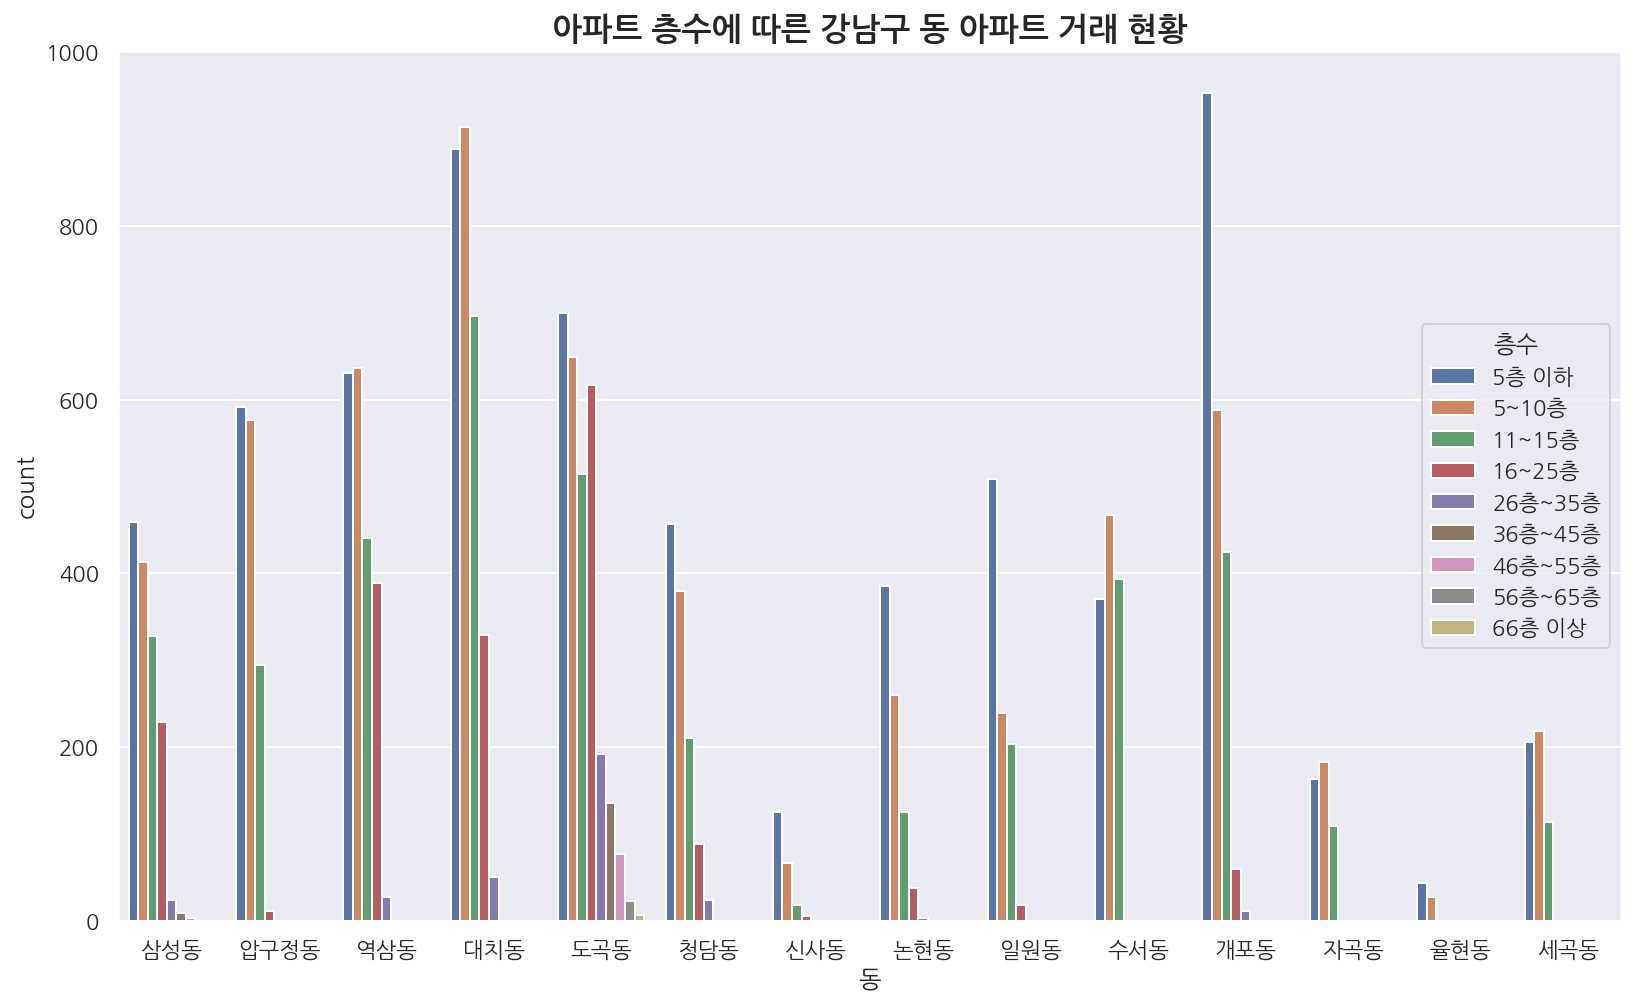

In [46]:
fig, ax = plt.subplots(figsize = (12,8))
g = sns.countplot(x='동', hue='floor_group', data=df)

xlabels = ['5층 이하','5~10층','11~15층', '16~25층', '26층~35층','36층~45층','46층~55층', '56층~65층', '66층 이상']

g.legend(title='층수', loc='right')
for i in range(len(xlabels)):
    g.legend_.texts[i].set_text(xlabels[i])

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('아파트 층수에 따른 강남구 동 아파트 거래 현황', loc='center', fontdict = title_font)
plt.show()

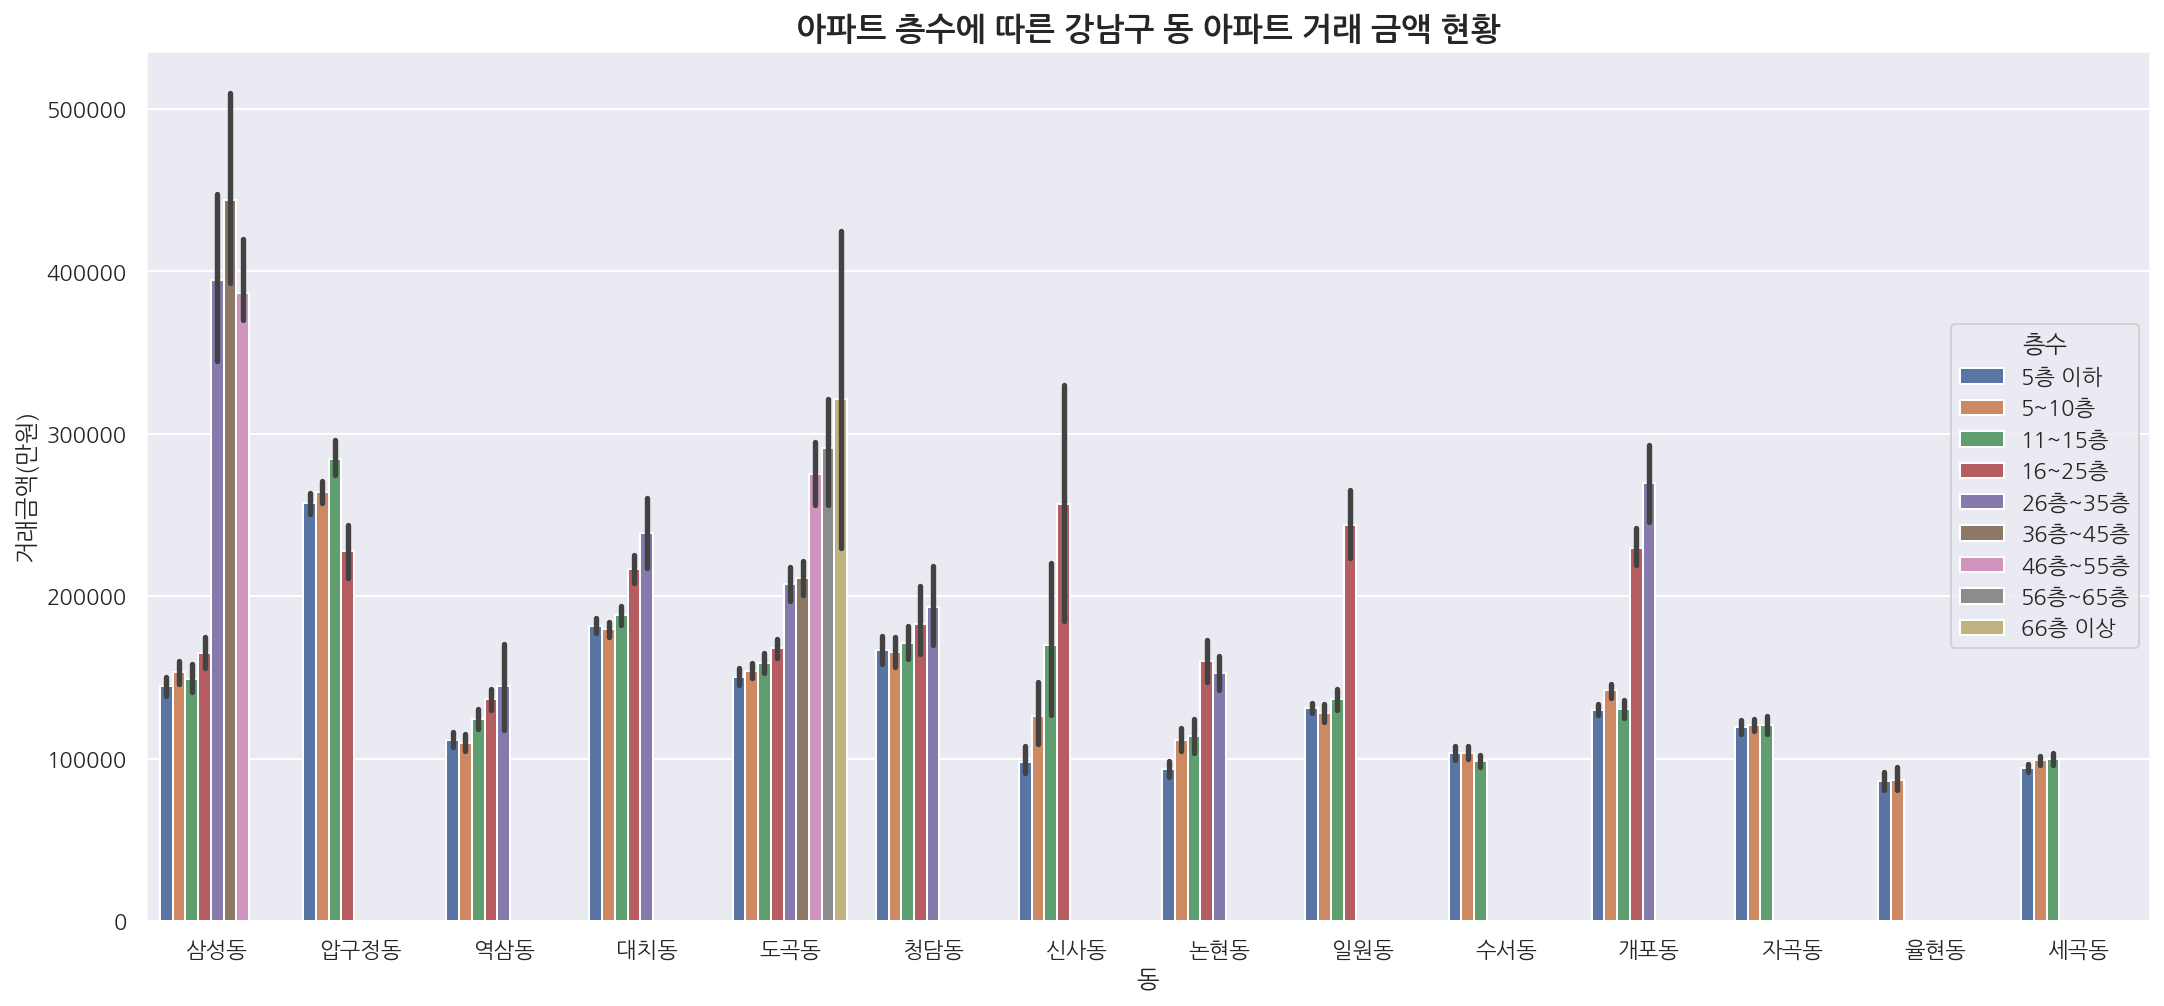

In [47]:
fig, ax = plt.subplots(figsize = (16,8))
g = sns.barplot(x='동', y='거래금액(만원)', hue='floor_group', data=df)
xlabels = ['5층 이하','5~10층','11~15층', '16~25층', '26층~35층','36층~45층','46층~55층', '56층~65층', '66층 이상']

g.legend(title='층수', loc='right')
for i in range(len(xlabels)):
    g.legend_.texts[i].set_text(xlabels[i])

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
plt.title('아파트 층수에 따른 강남구 동 아파트 거래 금액 현황', loc='center', fontdict = title_font)
plt.show()

## 인구정보

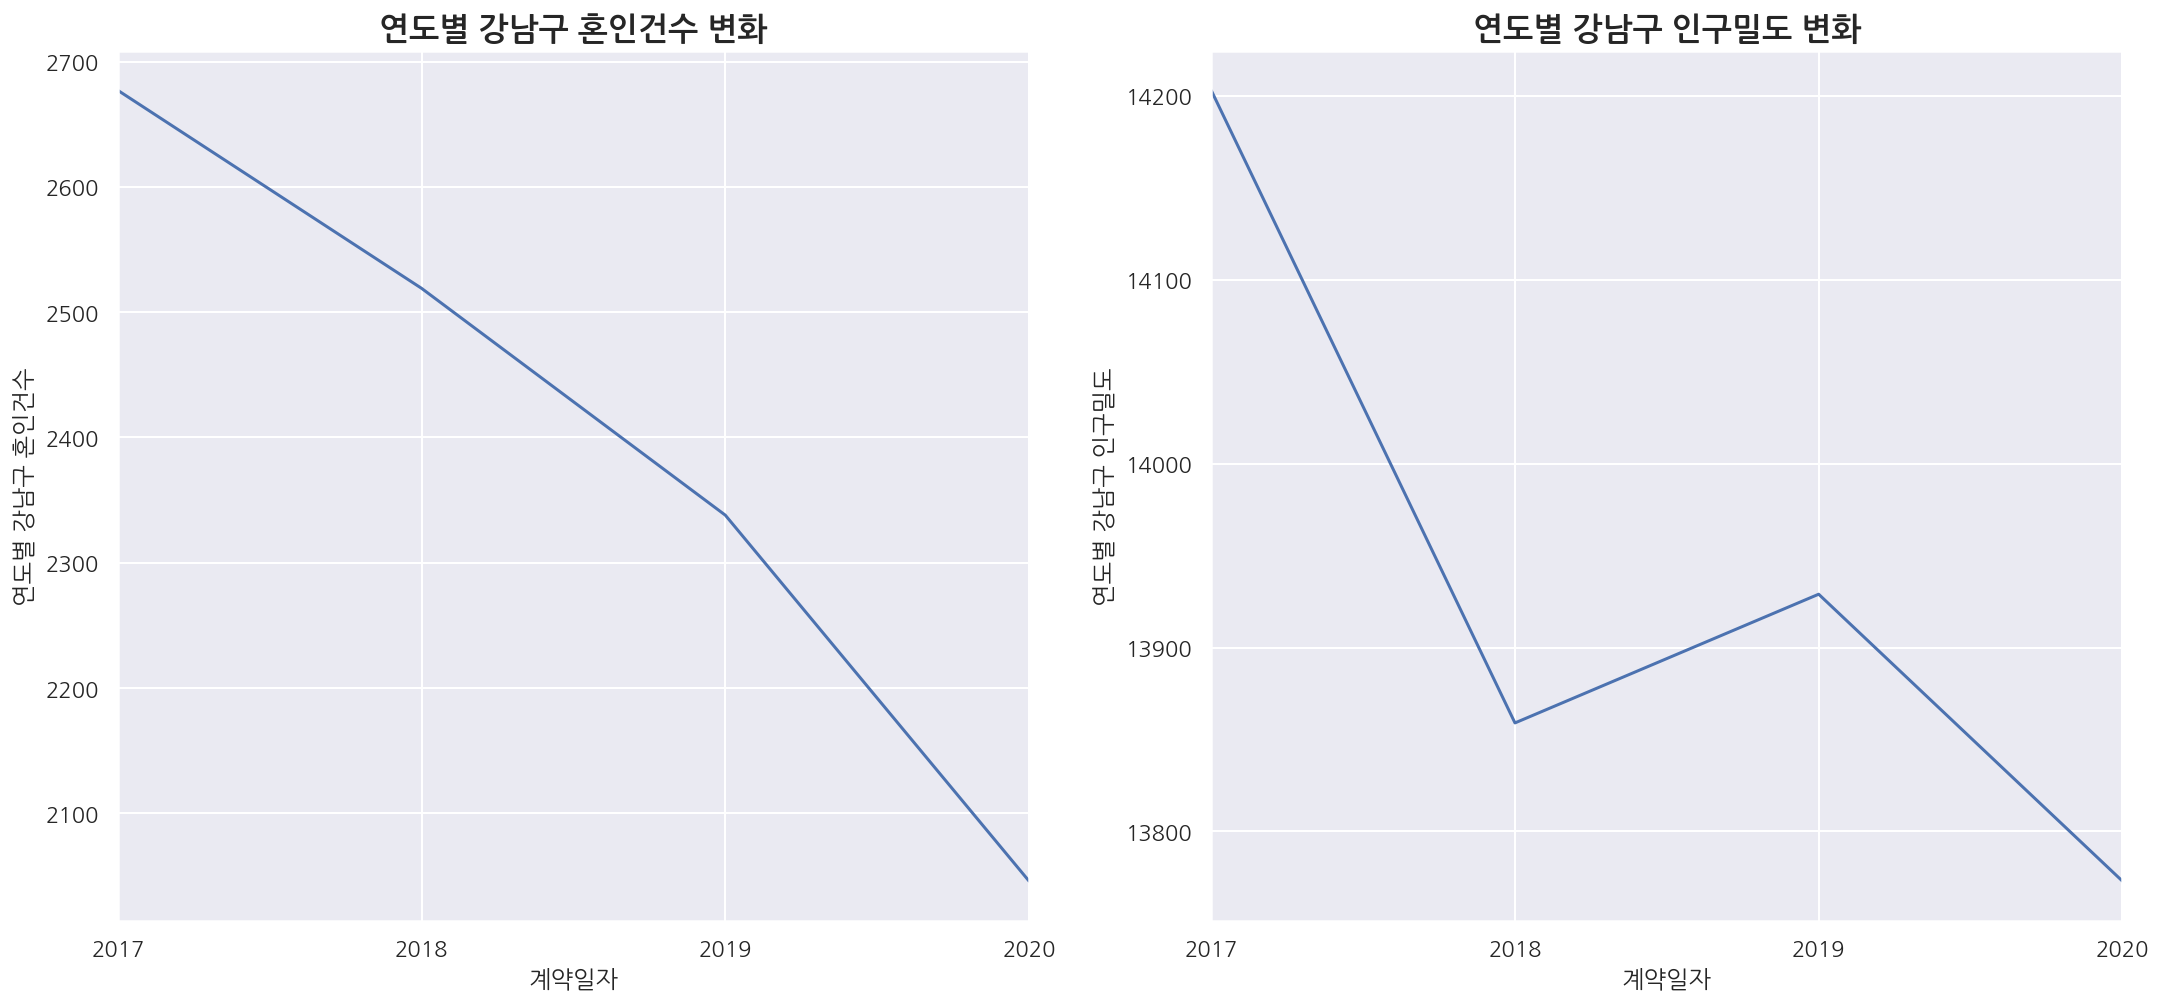

In [48]:
#연도별 혼인건수, 인구밀도
fig, ax = plt.subplots(1,2, figsize = (16,8))
연도별혼인건수 = df_new['혼인건수'].resample('Y').mean()
연도별인구밀도 = df_new['인구밀도'].resample('Y').mean()

연도별혼인건수.plot(label='연도별혼인건수', ax=ax[0])
연도별인구밀도.plot(label='연도별인구밀도', ax=ax[1])

ax[0].set_ylabel('연도별 강남구 혼인건수')
ax[1].set_ylabel('연도별 강남구 인구밀도')

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
ax[0].set_title('연도별 강남구 혼인건수 변화', loc='center', fontdict = title_font)
ax[1].set_title('연도별 강남구 인구밀도 변화', loc='center', fontdict = title_font)
plt.show()

2018년에는 오히려 혼인건수가 증가하지만, 인구밀도는 급격하게 줄어들고,  
2019년에는 인구밀도가 증가하나, 혼인건수는 2018년 보다 줄어드는 것을 볼 수 있습니다.  
(혼인건수와 인구밀도는 어쩌면 음의 상관관계가 있을 수도 있겠습니다.)

## 경제 지수

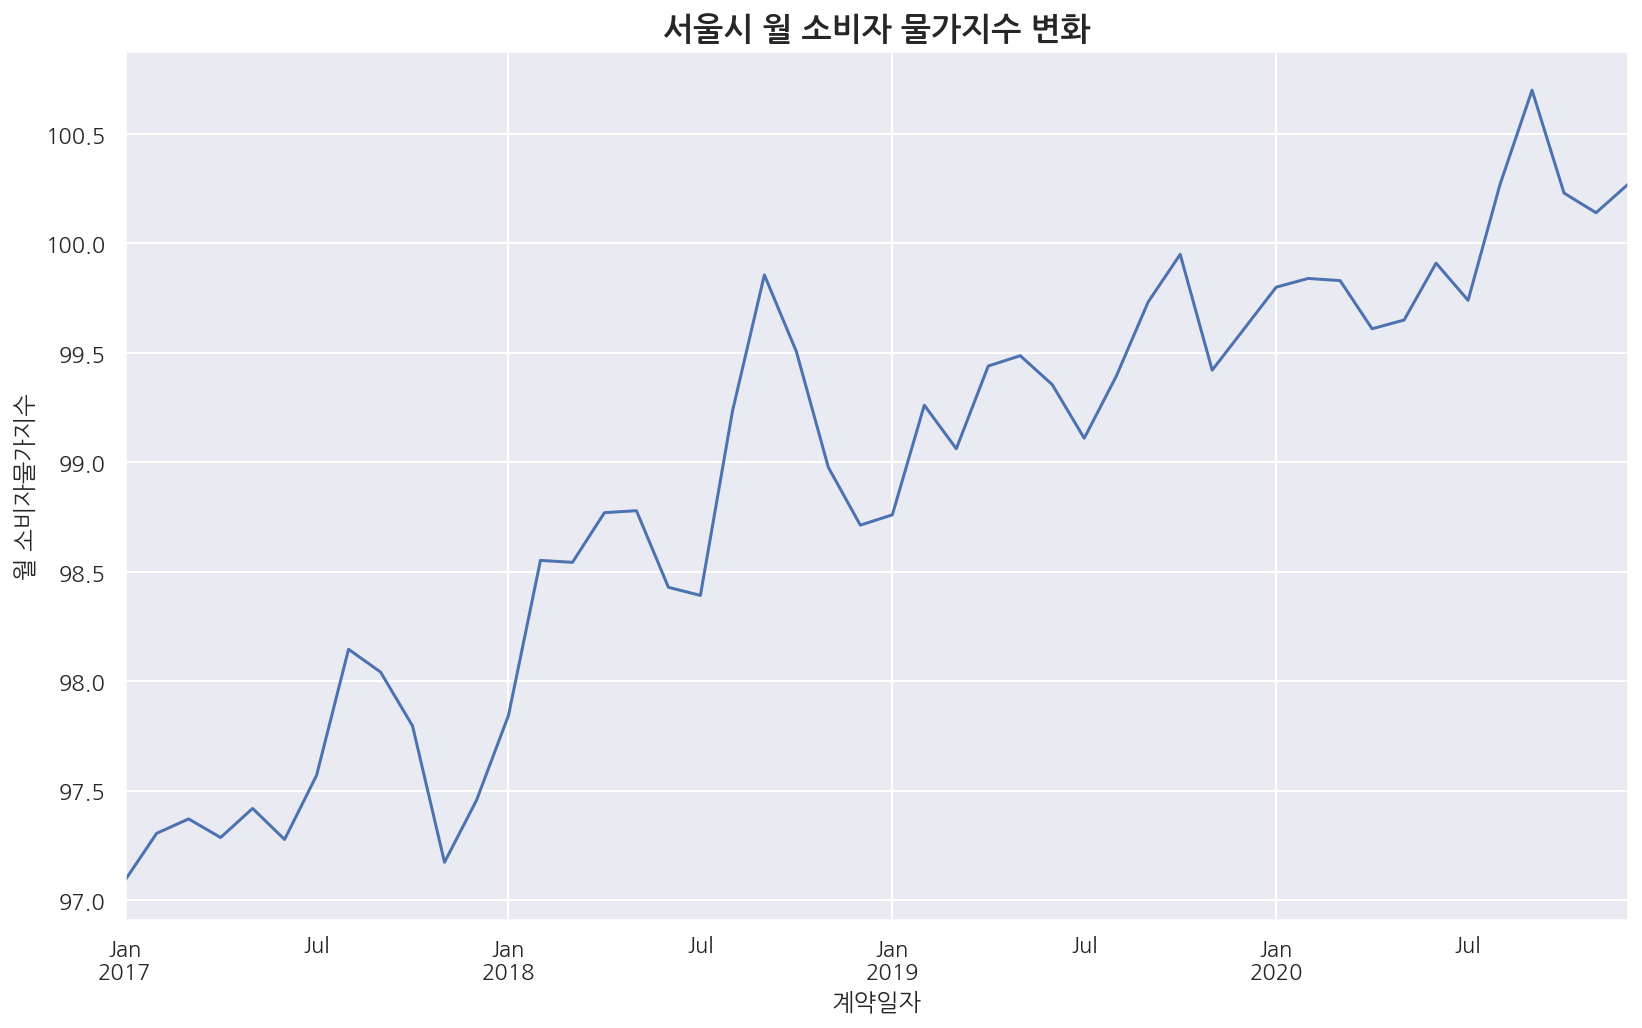

In [49]:
# 월별 소비자 물가지수, 가계대출, 기준금리
fig, ax = plt.subplots(figsize = (12,8))
월소비자물가지수 =  df_new['소비자물가지수'].resample('M').mean()
월소비자물가지수.plot(label='월소비자물가지수')

ax.set_ylabel('월 소비자물가지수')

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
ax.set_title('서울시 월 소비자 물가지수 변화', loc='center', fontdict = title_font)

plt.show()

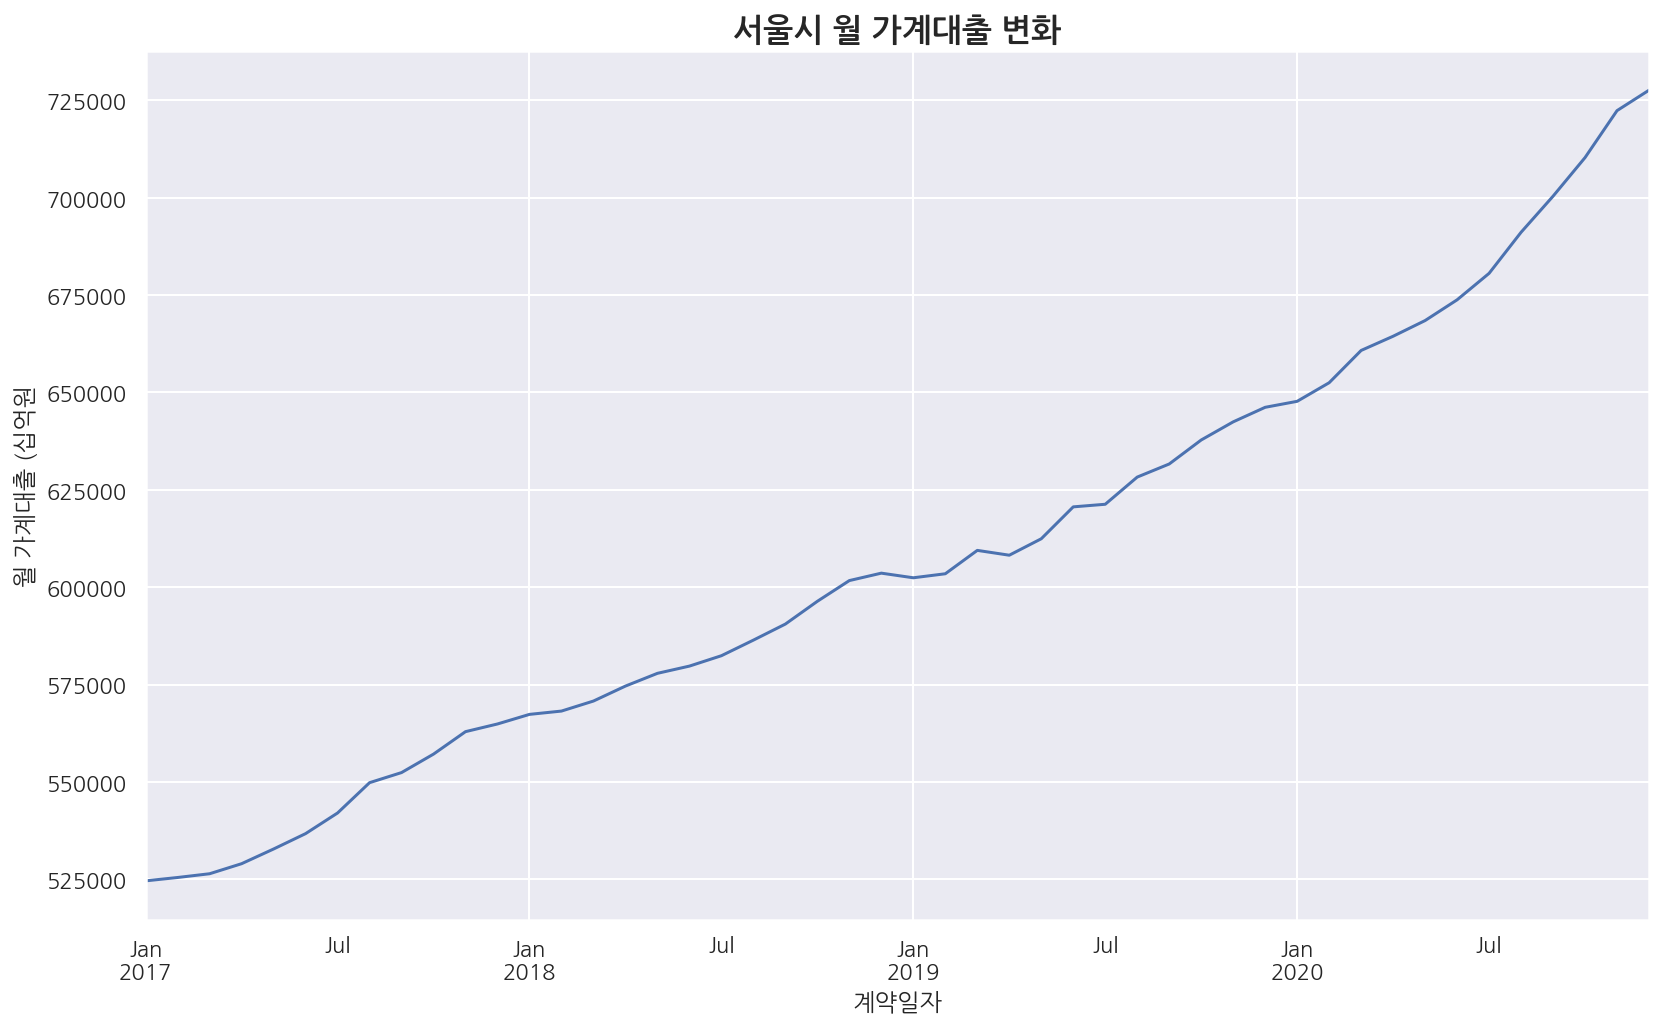

In [50]:
fig, ax = plt.subplots(figsize = (12,8))
월가계대출 =  df_new['가계대출_십억원'].resample('M').mean()
월가계대출.plot(label='월가계대출')


ax.set_ylabel('월 가계대출 (십억원')

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
ax.set_title('서울시 월 가계대출 변화', loc='center', fontdict = title_font)

plt.show()

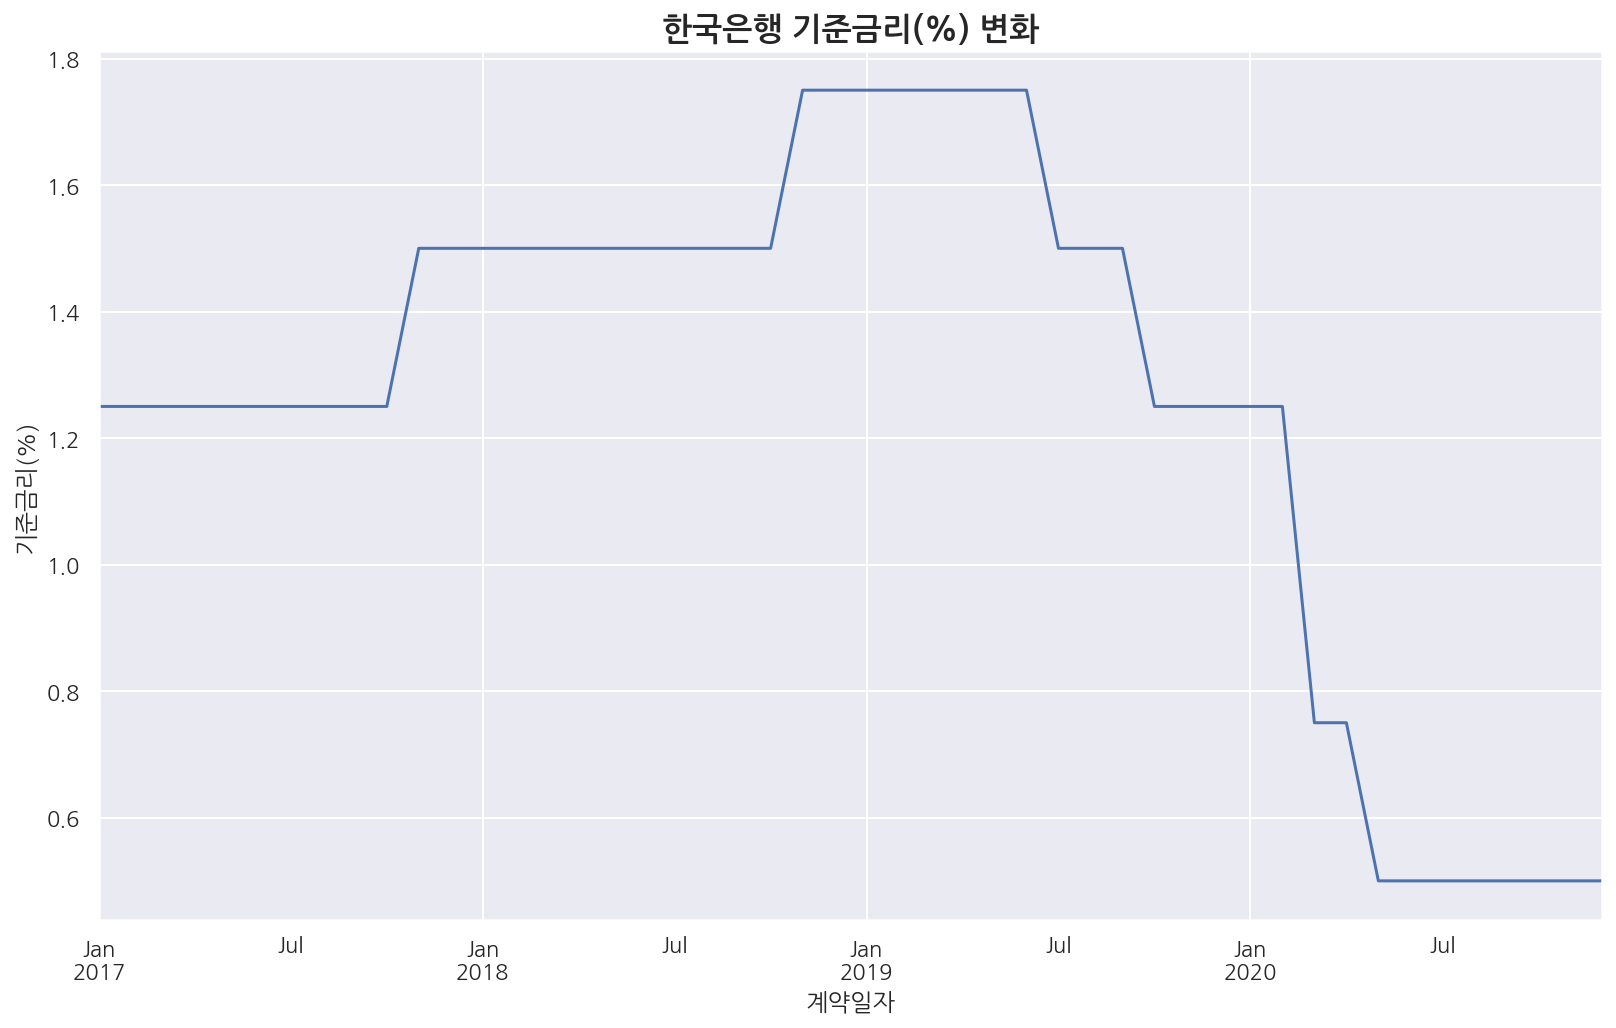

In [51]:
fig, ax = plt.subplots(figsize = (12,8))
월기준금리 =  df_new['기준금리'].resample('M').mean()
월기준금리.plot(label='월기준금리')
ax.set_ylabel('기준금리(%)')
title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
ax.set_title('한국은행 기준금리(%) 변화', loc='center', fontdict = title_font)
plt.show()

## 지리정보

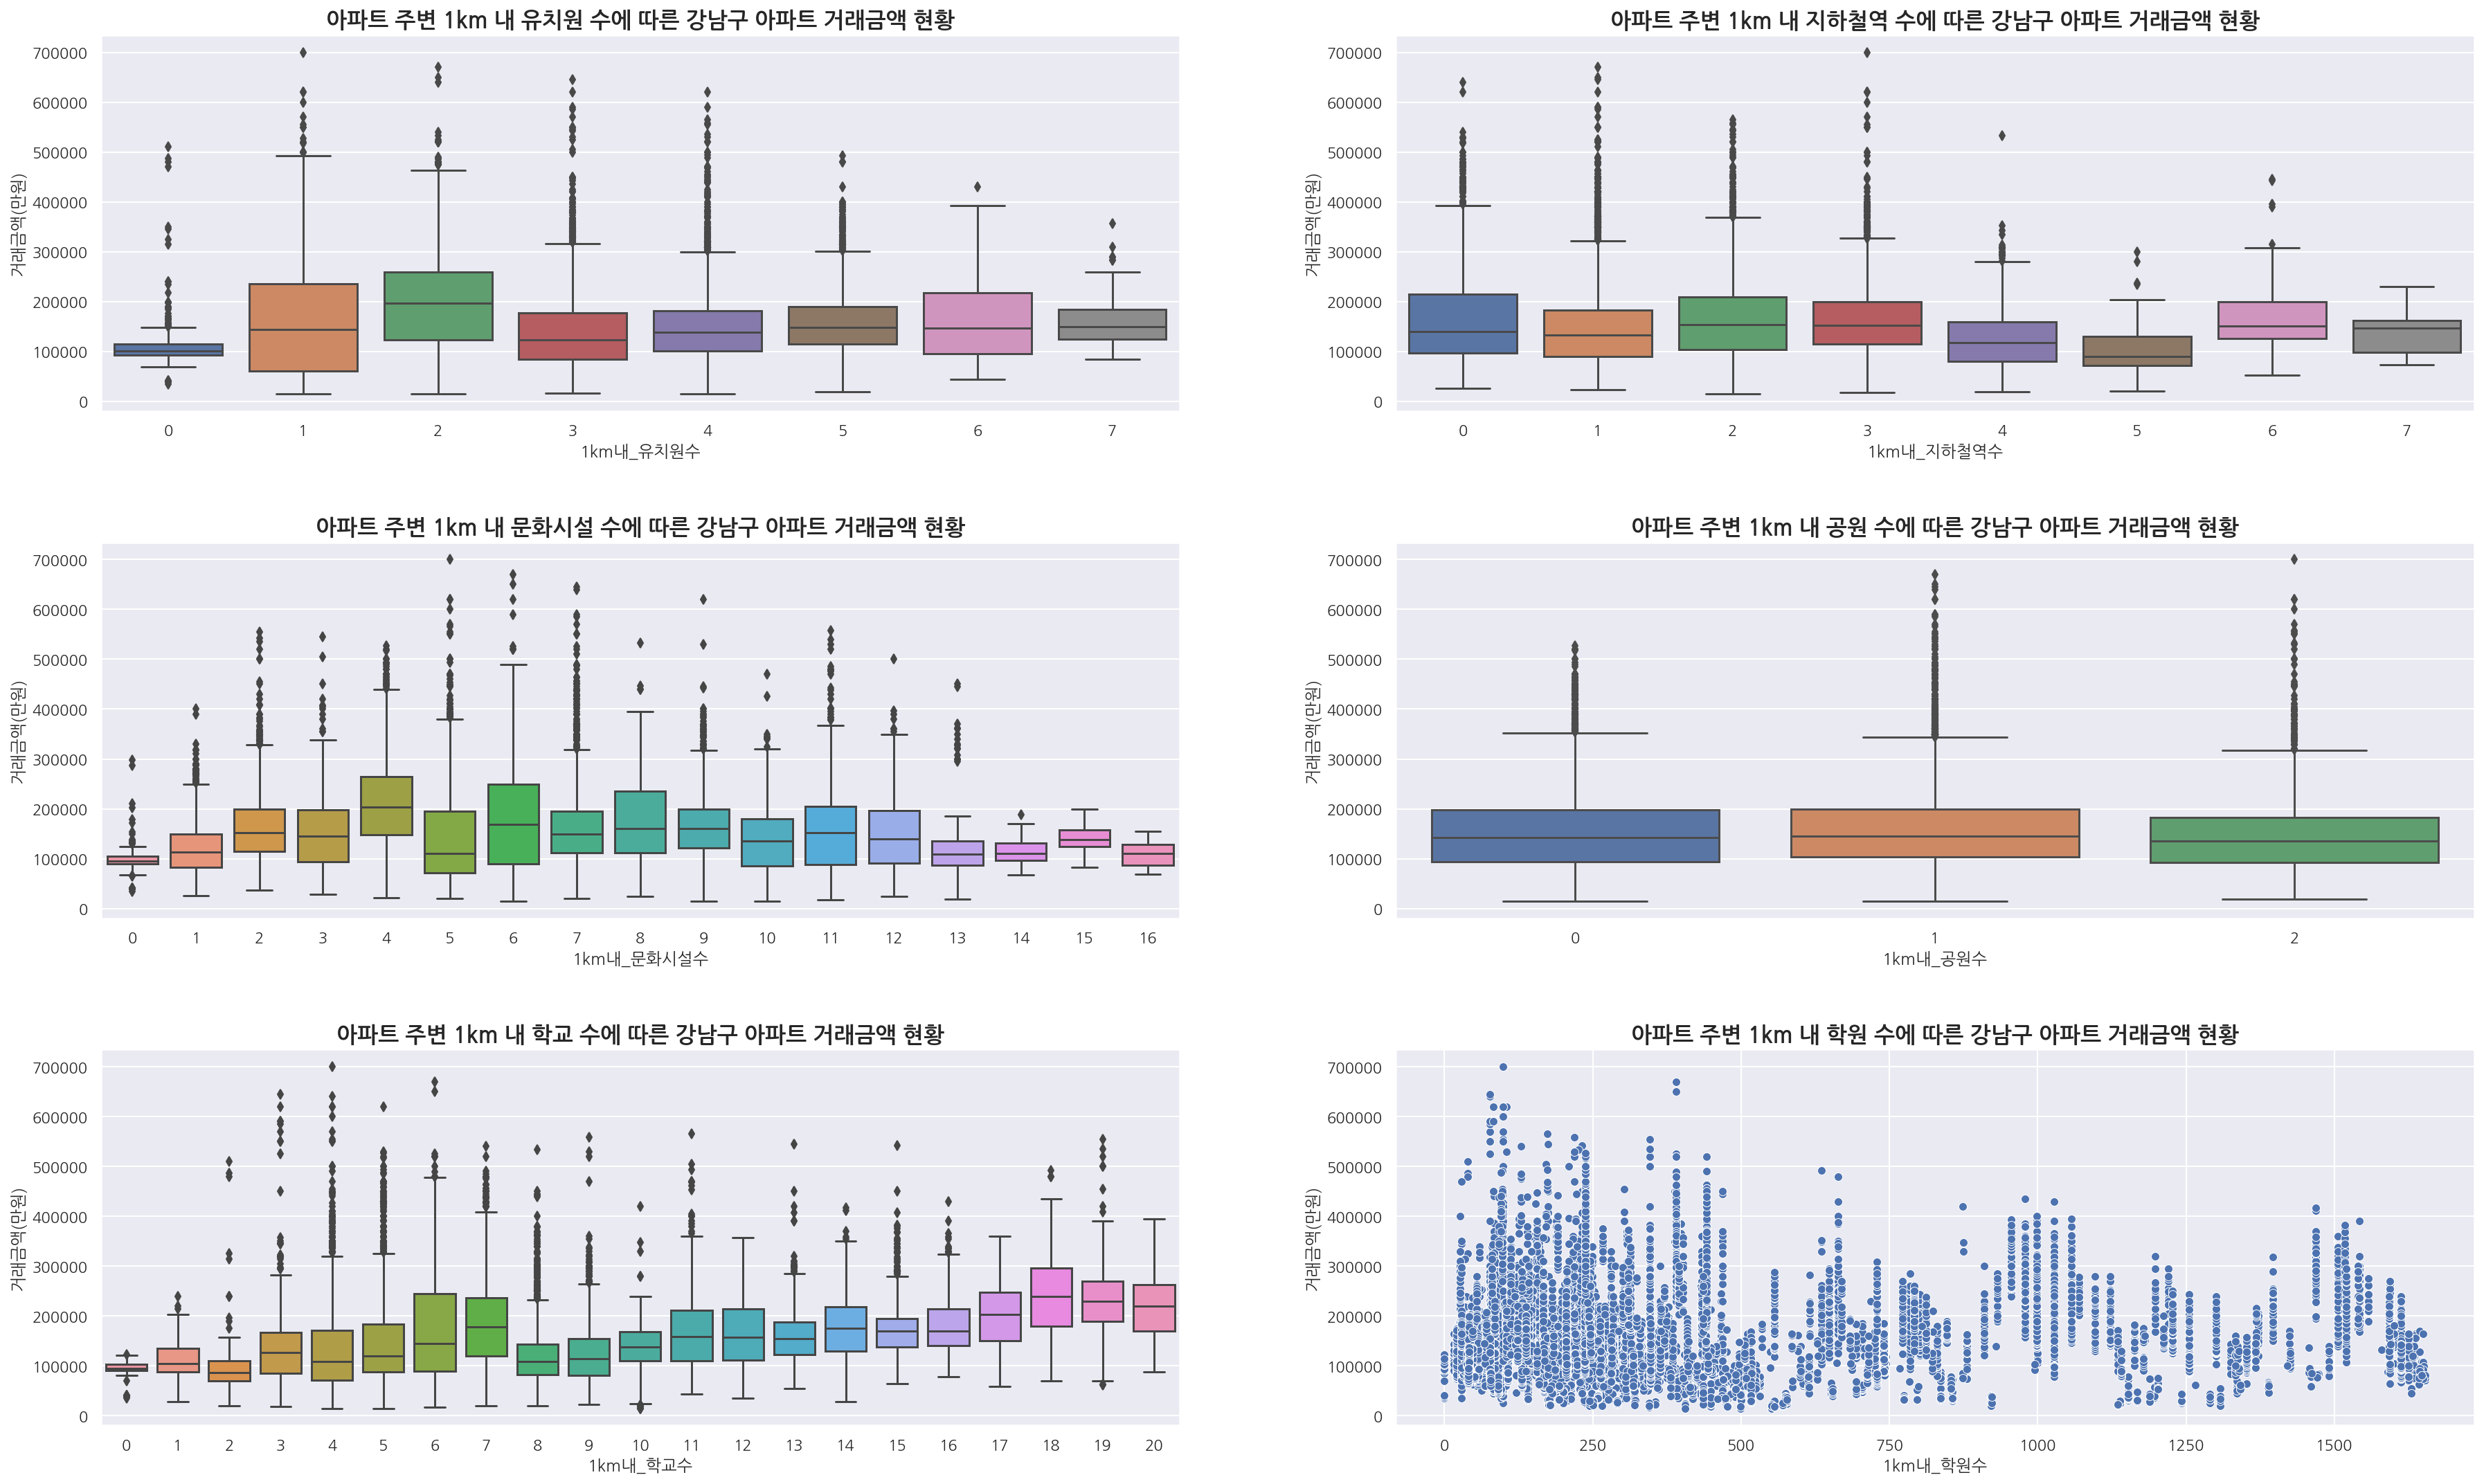

In [53]:
# 지리정보와 거래금액간의 관계
fig, ax = plt.subplots(3, 2,figsize = (25,15))

sns.boxplot(x='1km내_유치원수', y='거래금액(만원)', data=df, ax = ax[0,0])
sns.boxplot(x='1km내_지하철역수', y='거래금액(만원)', data=df, ax=ax[0,1])
sns.boxplot(x='1km내_문화시설수', y='거래금액(만원)', data=df, ax=ax[1,0])
sns.boxplot(x='1km내_공원수', y='거래금액(만원)', data=df, ax=ax[1,1])
sns.boxplot(x='1km내_학교수', y='거래금액(만원)', data=df, ax=ax[2,0])
sns.scatterplot(x='1km내_학원수', y='거래금액(만원)', data=df, ax=ax[2,1])

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}
ax[0,0].set_title('아파트 주변 1km 내 유치원 수에 따른 강남구 아파트 거래금액 현황', loc='center', fontdict = title_font)
ax[0,1].set_title('아파트 주변 1km 내 지하철역 수에 따른 강남구 아파트 거래금액 현황', loc='center', fontdict = title_font)
ax[1,0].set_title('아파트 주변 1km 내 문화시설 수에 따른 강남구 아파트 거래금액 현황', loc='center', fontdict = title_font)
ax[1,1].set_title('아파트 주변 1km 내 공원 수에 따른 강남구 아파트 거래금액 현황', loc='center', fontdict = title_font)
ax[2,0].set_title('아파트 주변 1km 내 학교 수에 따른 강남구 아파트 거래금액 현황', loc='center', fontdict = title_font)
ax[2,1].set_title('아파트 주변 1km 내 학원 수에 따른 강남구 아파트 거래금액 현황', loc='center', fontdict = title_font)

fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.35)

### 최소거리 시각화

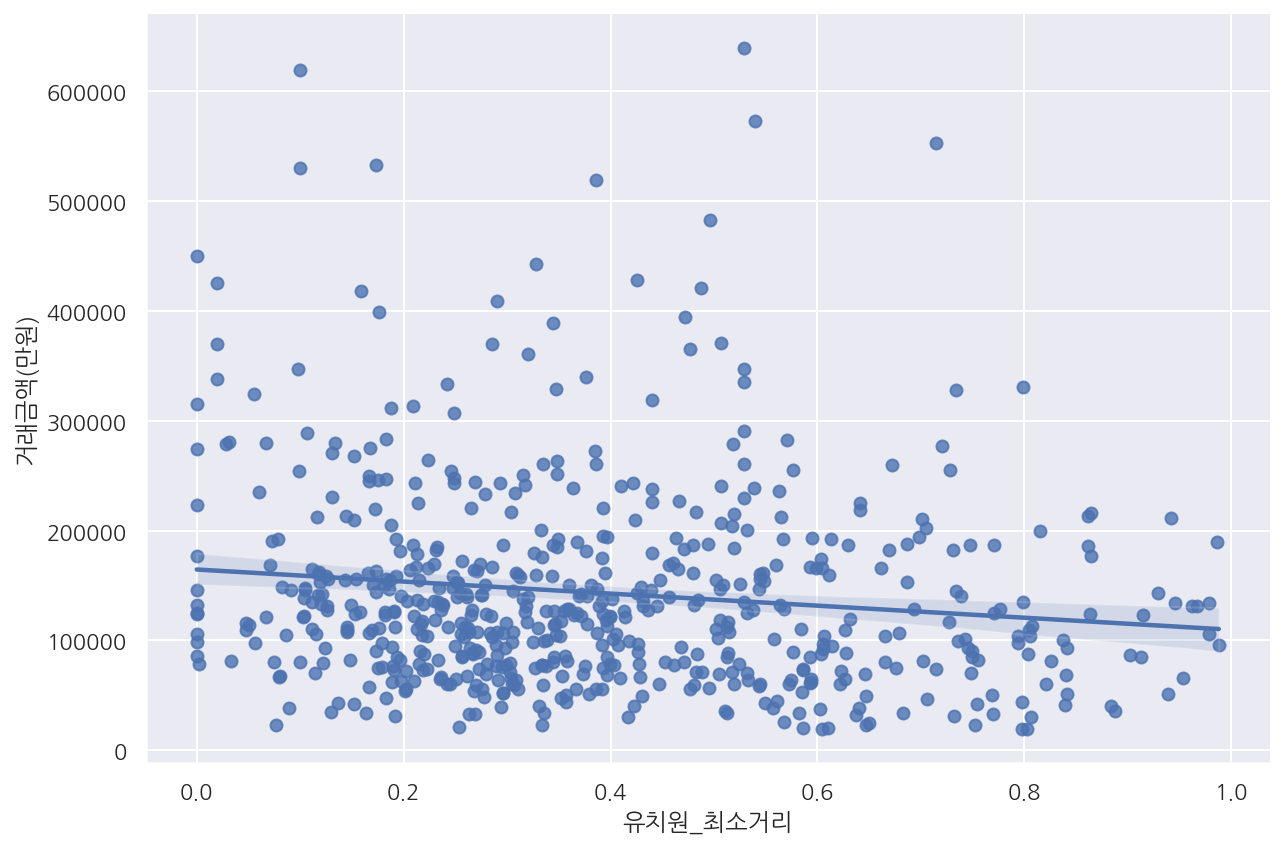

In [54]:
df1 = df.groupby('단지명')[['유치원_최소거리','지하철역_최소거리','문화시설_최소거리','공원_최소거리', '학교_최소거리','학원_최소거리','거래금액(만원)']].mean()

sns.lmplot(x='유치원_최소거리', y='거래금액(만원)', data=df1, height = 6, aspect=1.5)

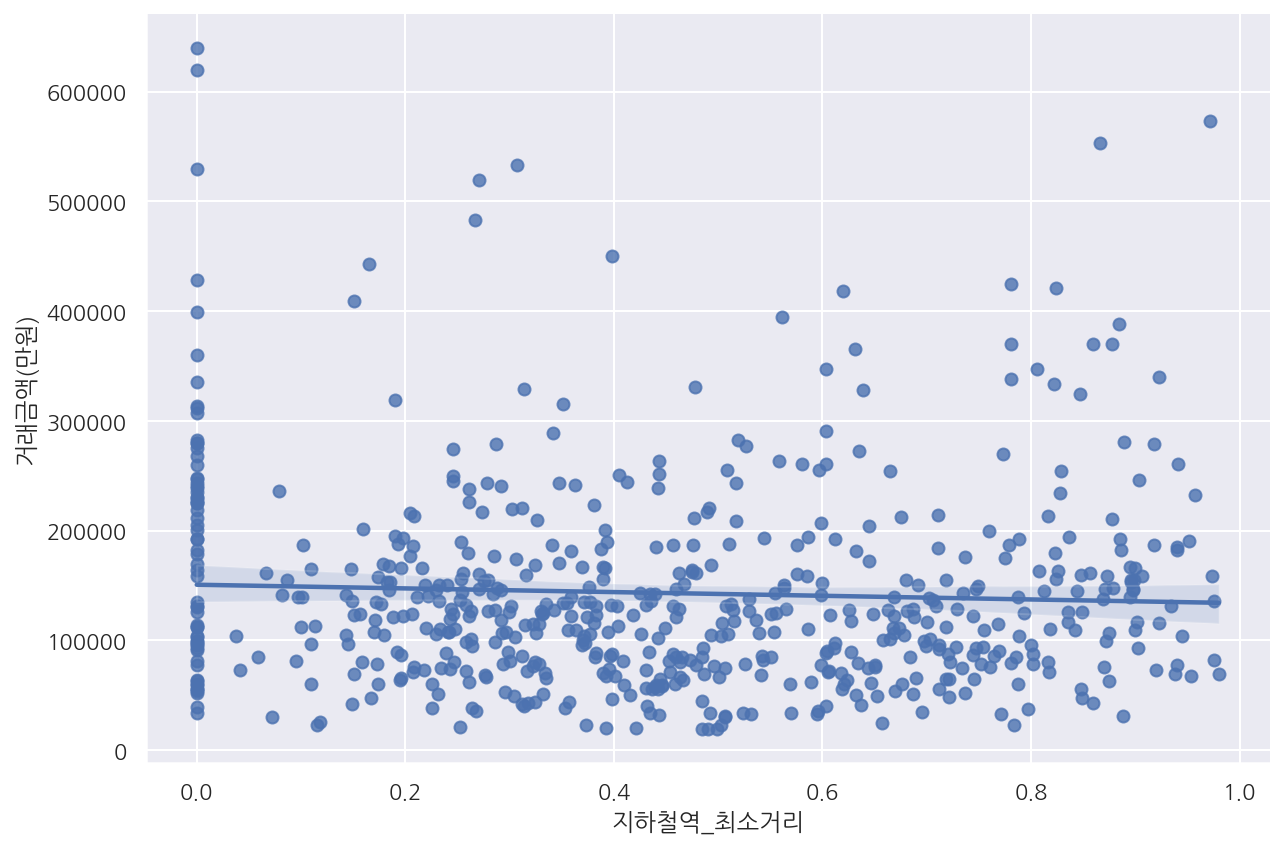

In [55]:
sns.lmplot(x='지하철역_최소거리', y='거래금액(만원)', data=df1,  height = 6, aspect=1.5)

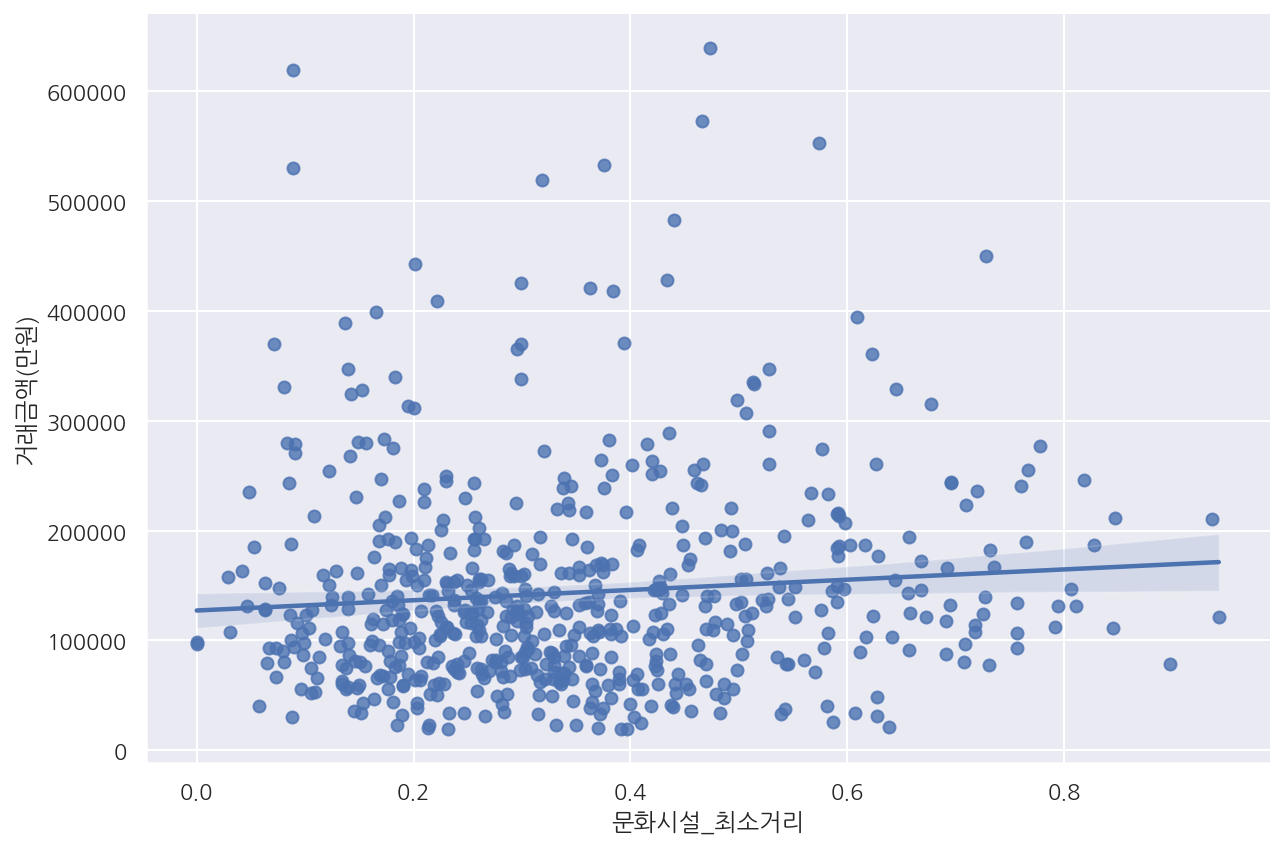

In [56]:
sns.lmplot(x='문화시설_최소거리', y='거래금액(만원)', data=df1,  height = 6, aspect=1.5)

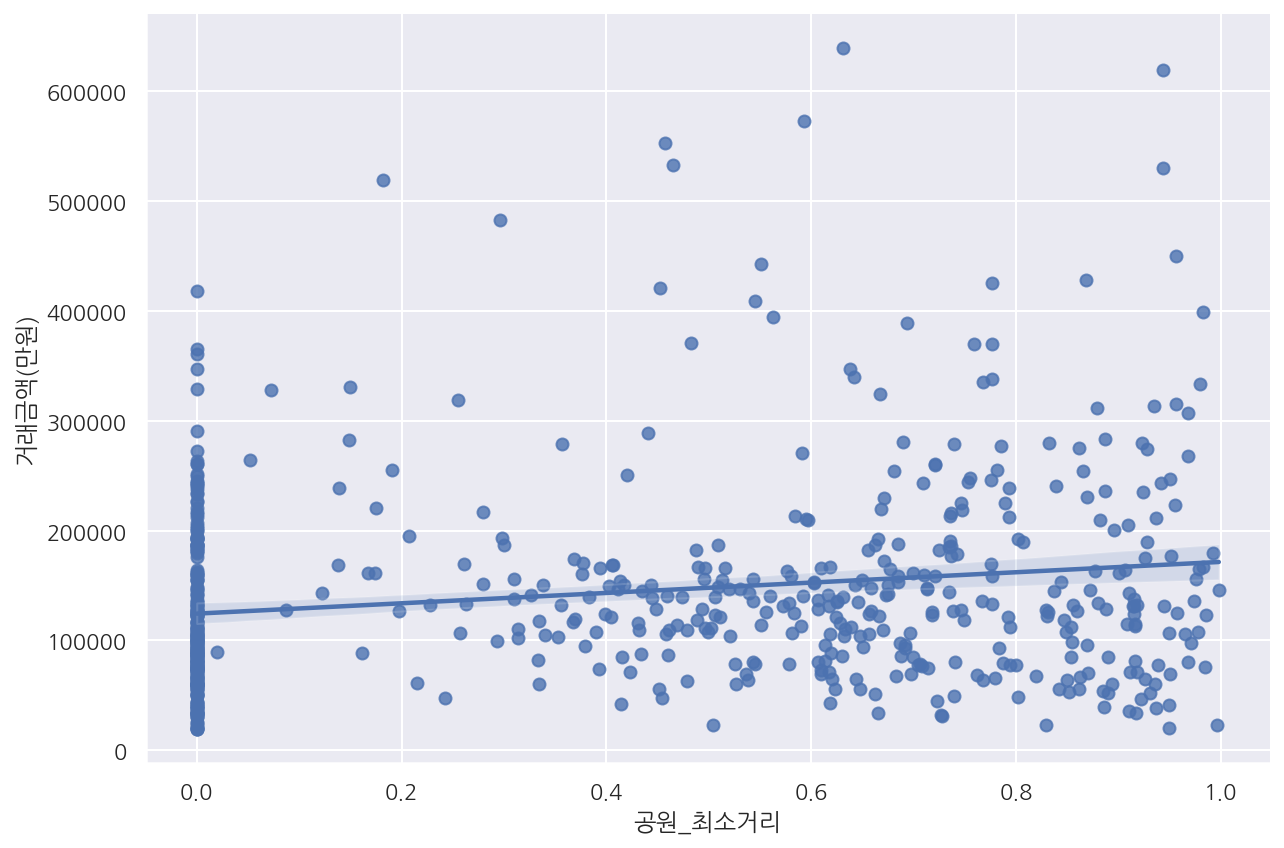

In [57]:
sns.lmplot(x='공원_최소거리', y='거래금액(만원)', data=df1,  height = 6, aspect=1.5)

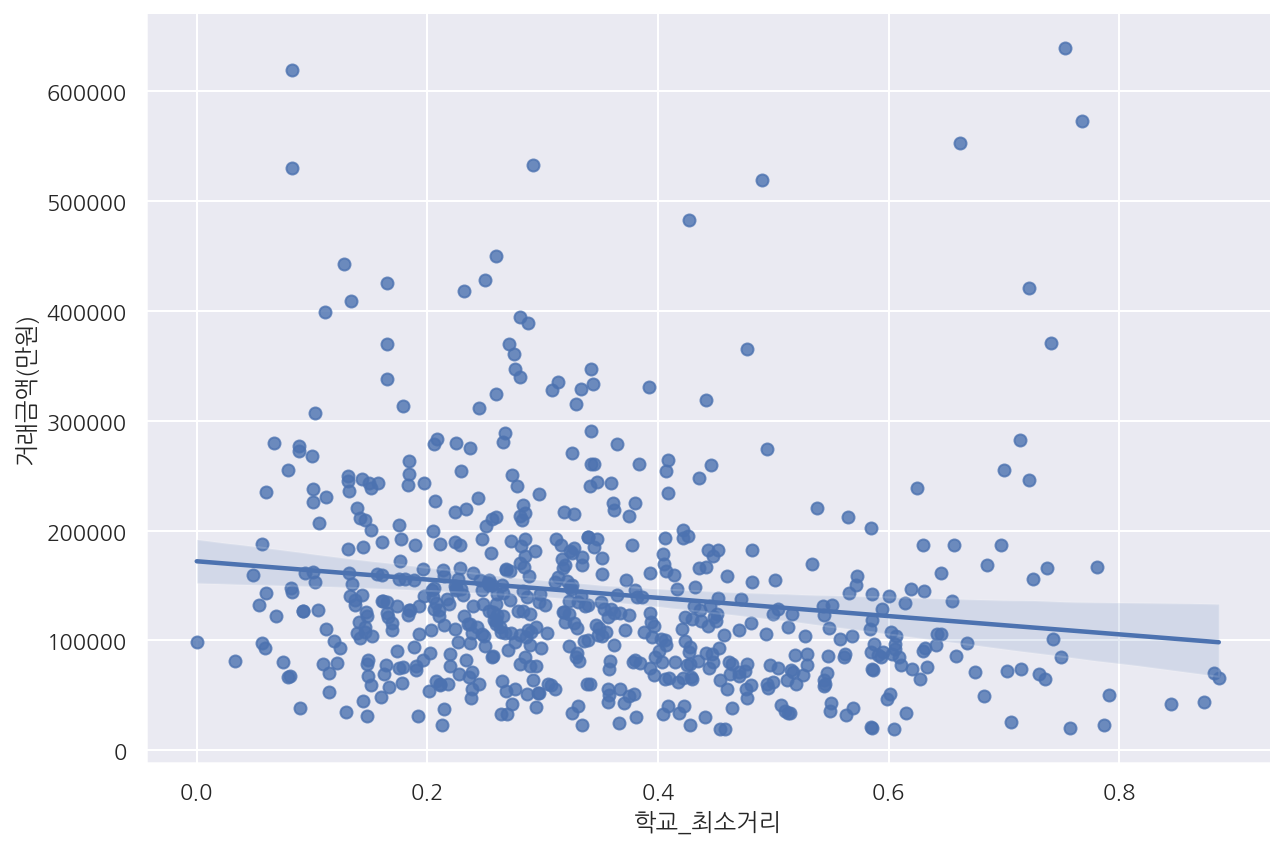

In [58]:
sns.lmplot(x='학교_최소거리', y='거래금액(만원)', data=df1,  height = 6, aspect=1.5)

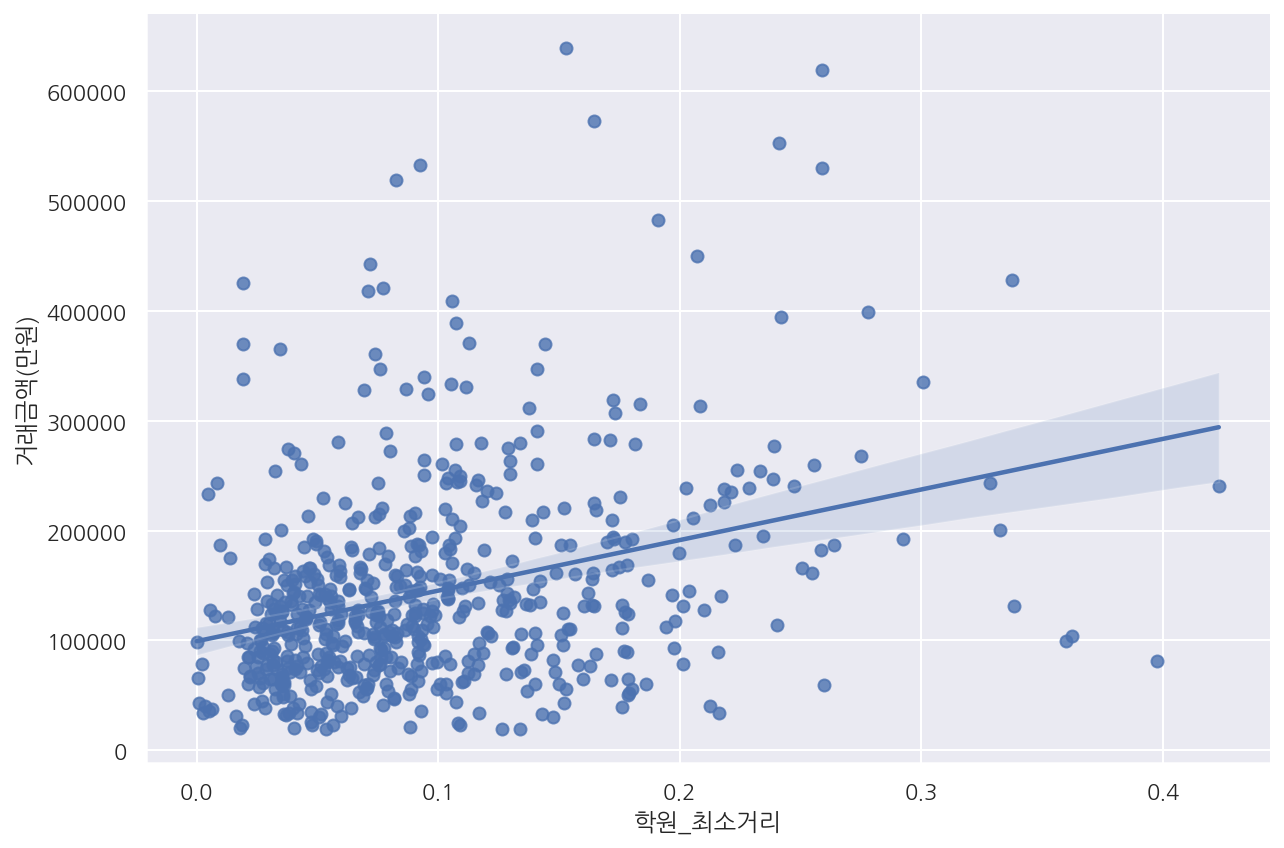

In [59]:
sns.lmplot(x='학원_최소거리', y='거래금액(만원)', data=df1,  height = 6, aspect=1.5)

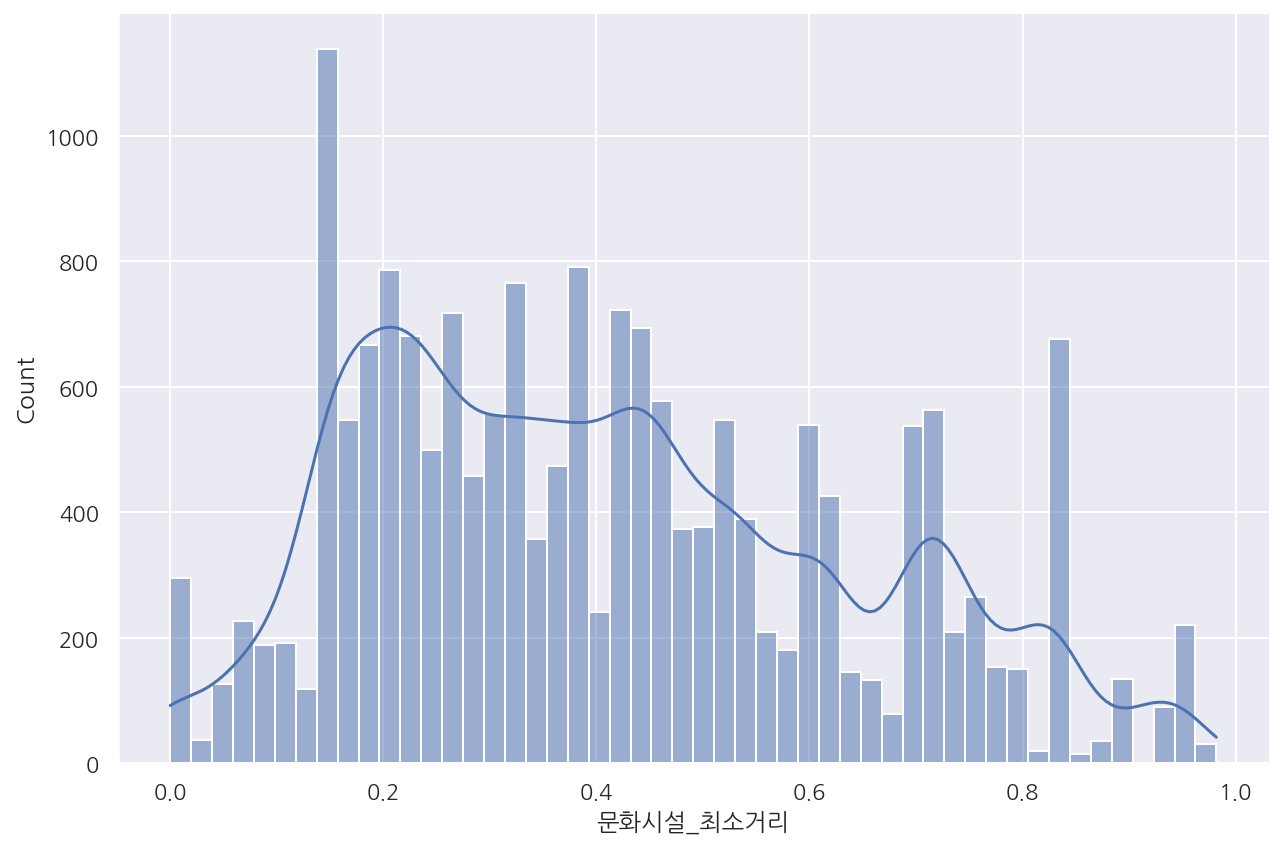

In [60]:
sns.displot(df['문화시설_최소거리'], bins=50,  kde=True, height = 6, aspect=1.5)

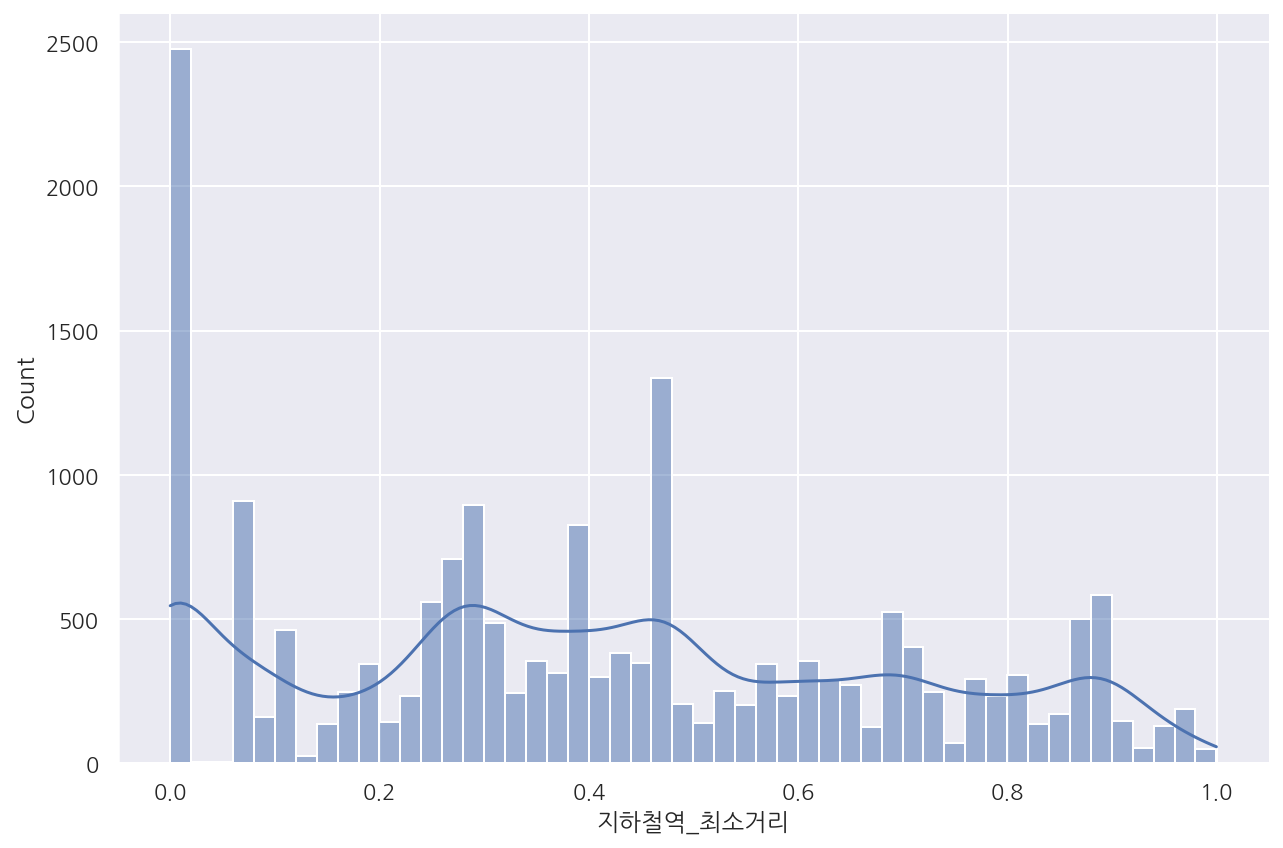

In [61]:
sns.displot(df['지하철역_최소거리'], bins=50,  kde=True, height = 6, aspect=1.5)

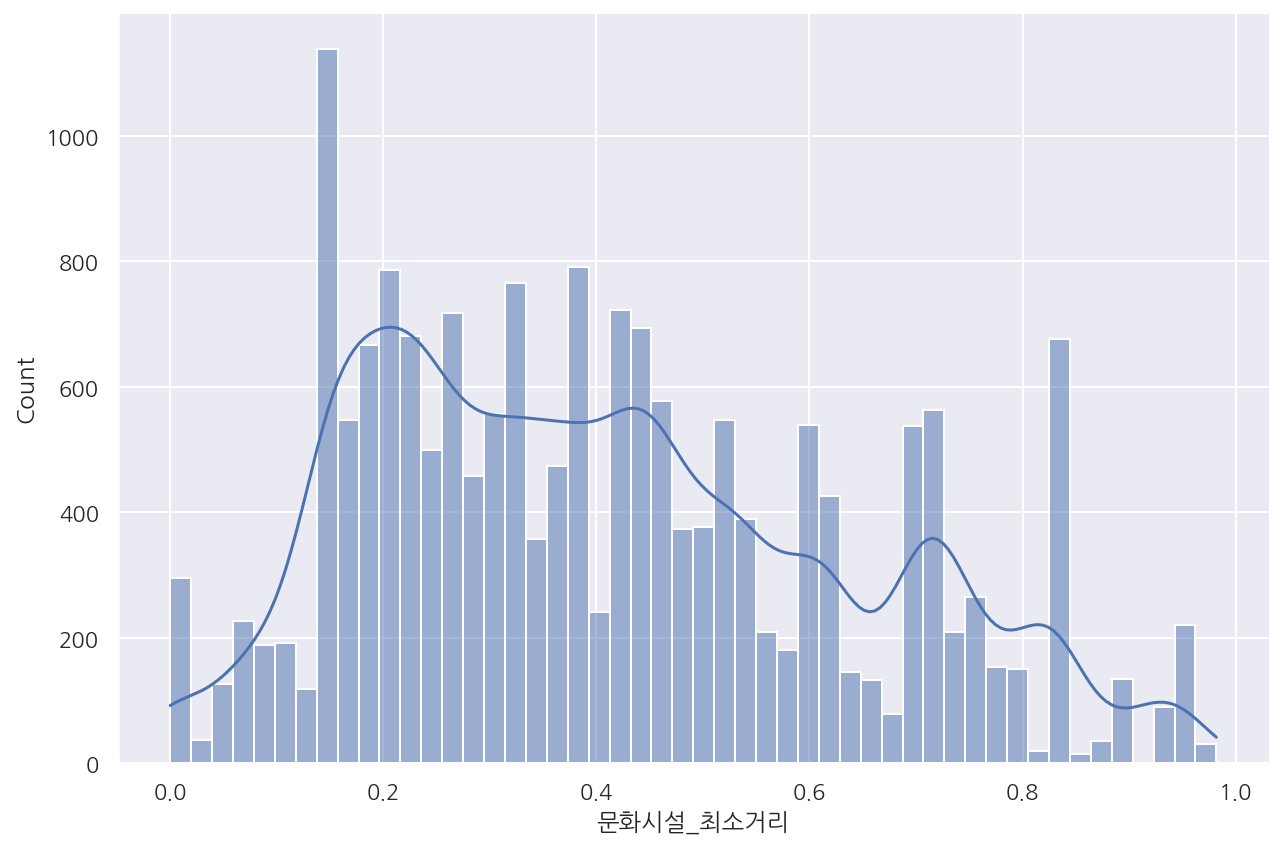

In [62]:
sns.displot(df['문화시설_최소거리'], bins=50,  kde=True, height = 6, aspect=1.5)

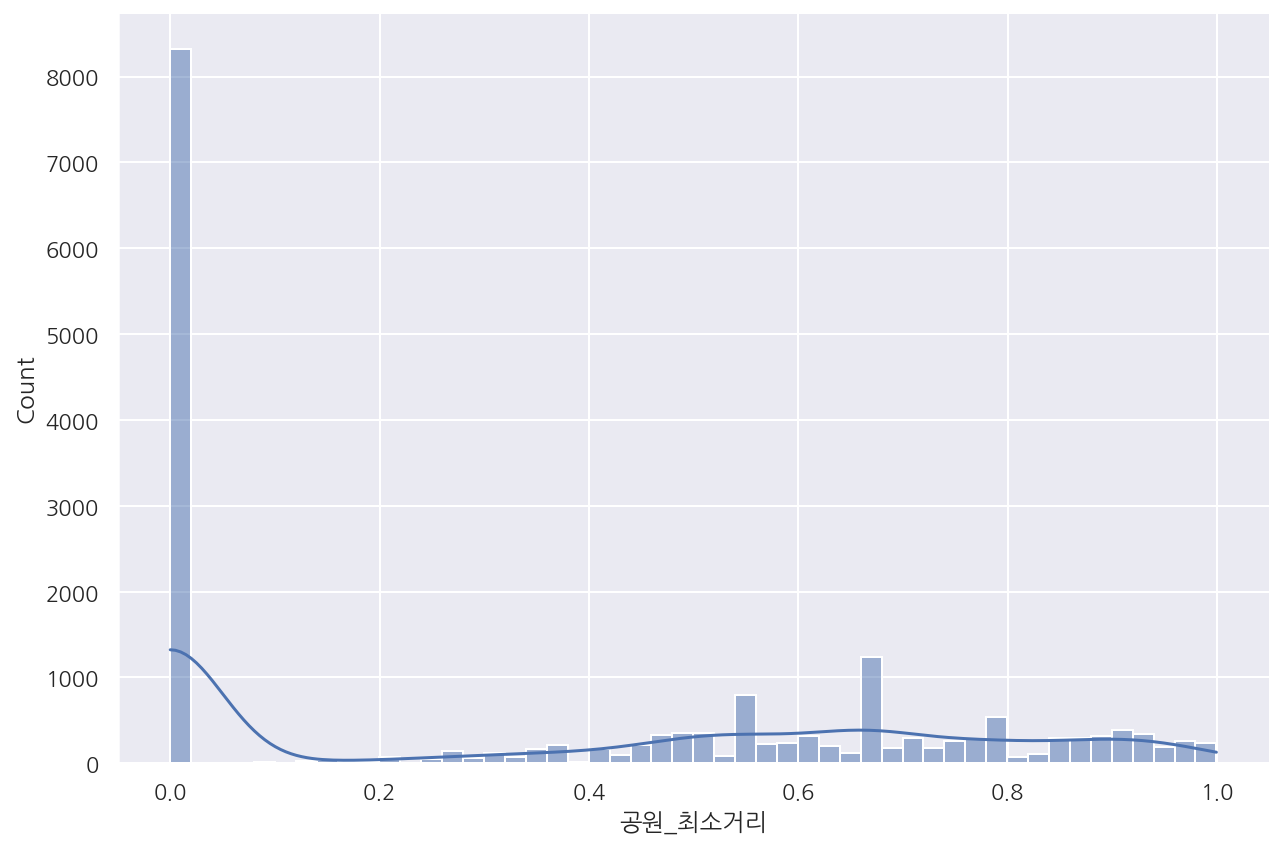

In [63]:
sns.displot(df['공원_최소거리'], bins=50,  kde=True, height = 6, aspect=1.5)

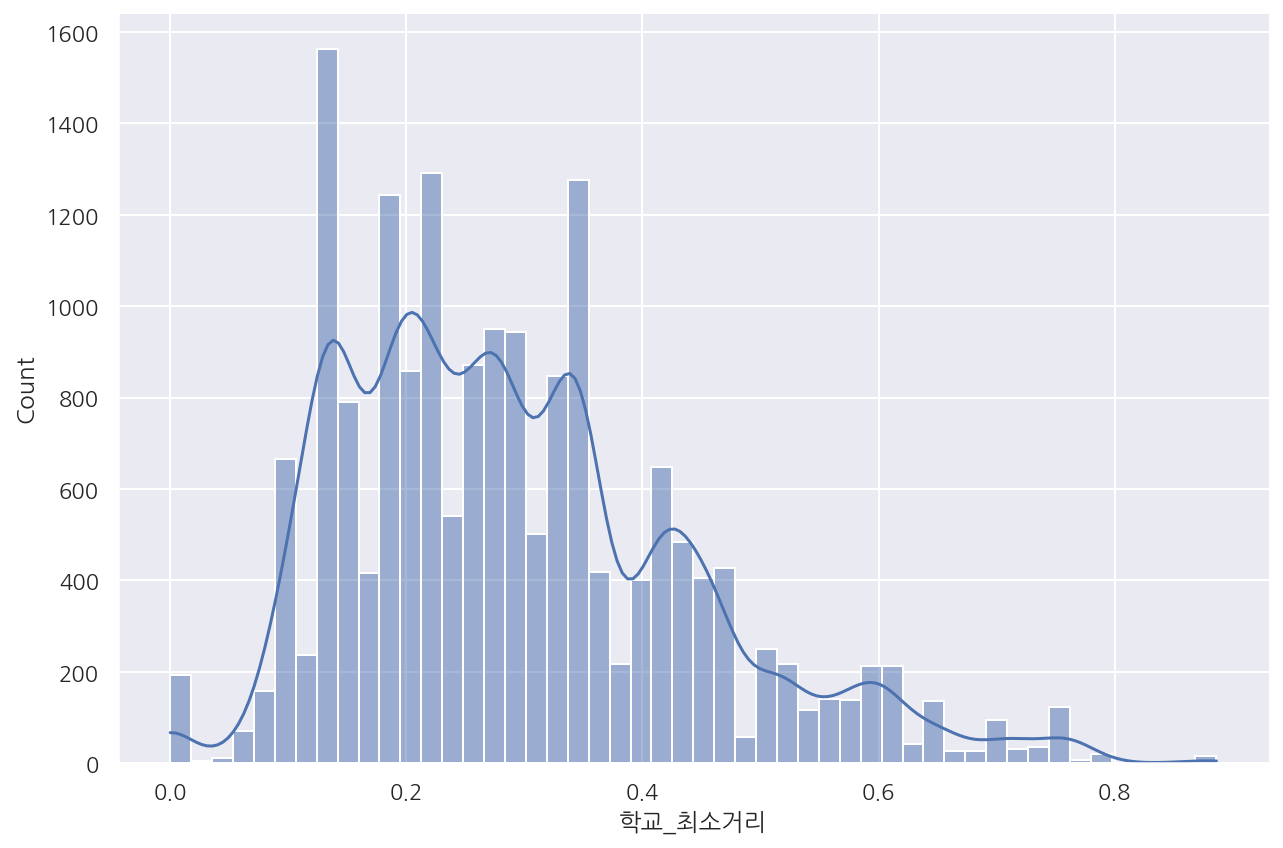

In [64]:
sns.displot(df['학교_최소거리'], bins=50,  kde=True, height = 6, aspect=1.5)

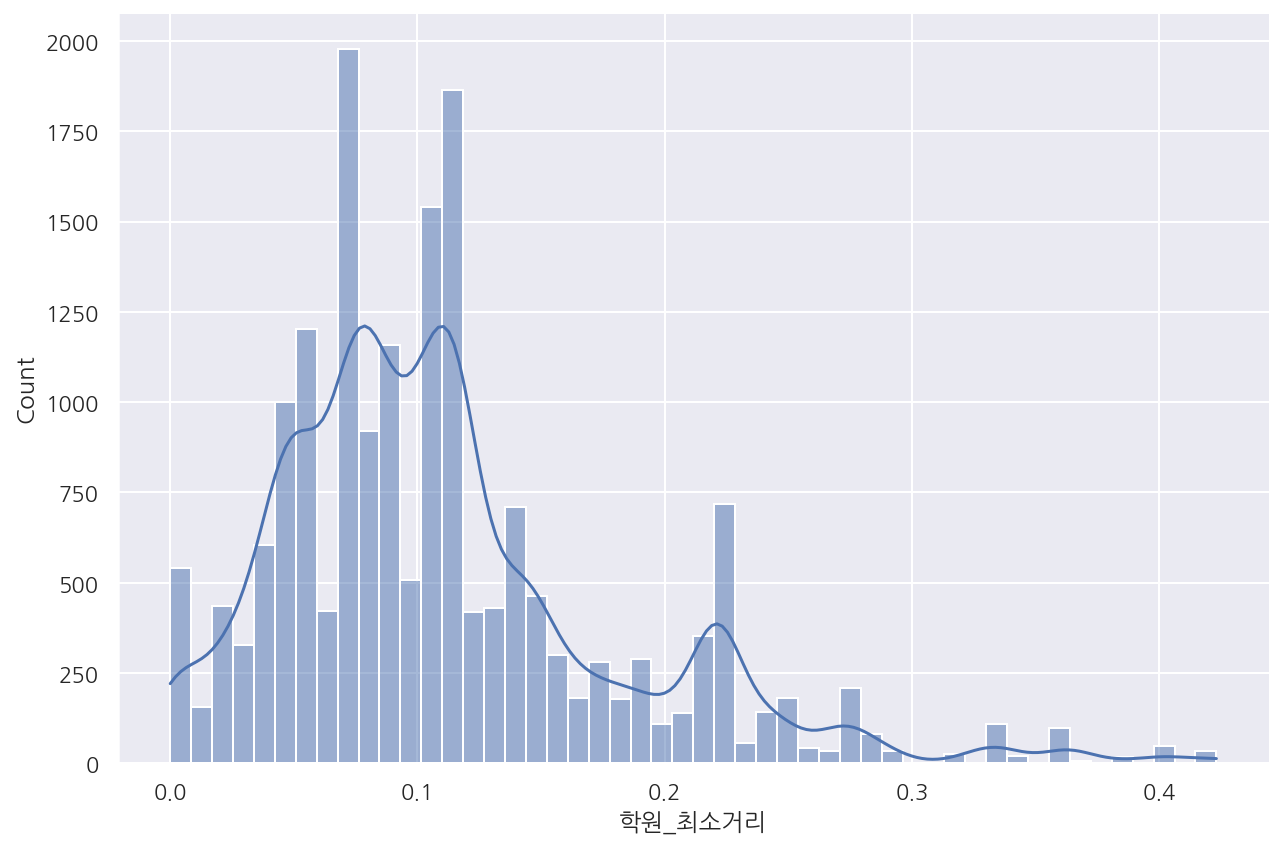

In [65]:
sns.displot(df['학원_최소거리'], bins=50,  kde=True, height = 6, aspect=1.5)

### 강남구 동에 따른 지리정보 변화

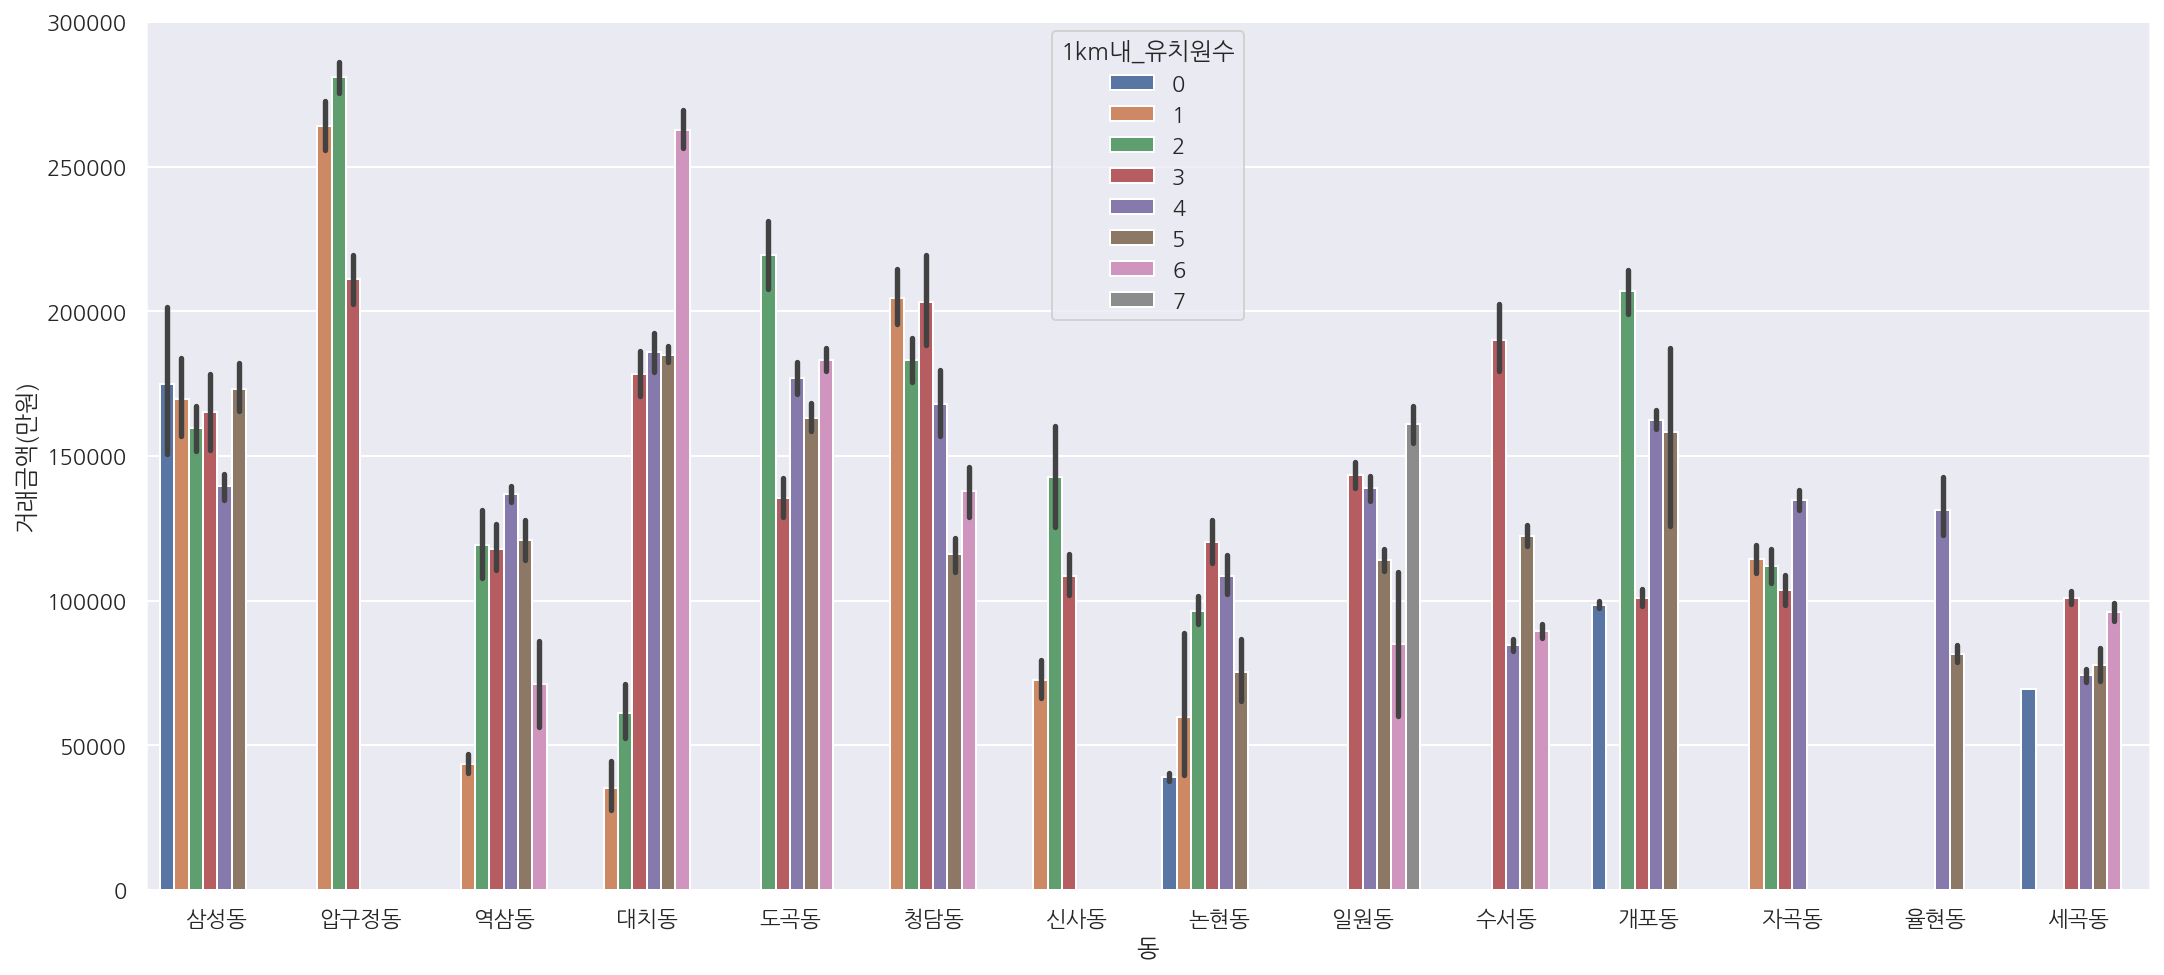

In [66]:
fig, ax = plt.subplots(figsize = (16,8))
g = sns.barplot(x='동', y='거래금액(만원)', hue='1km내_유치원수', data=df)

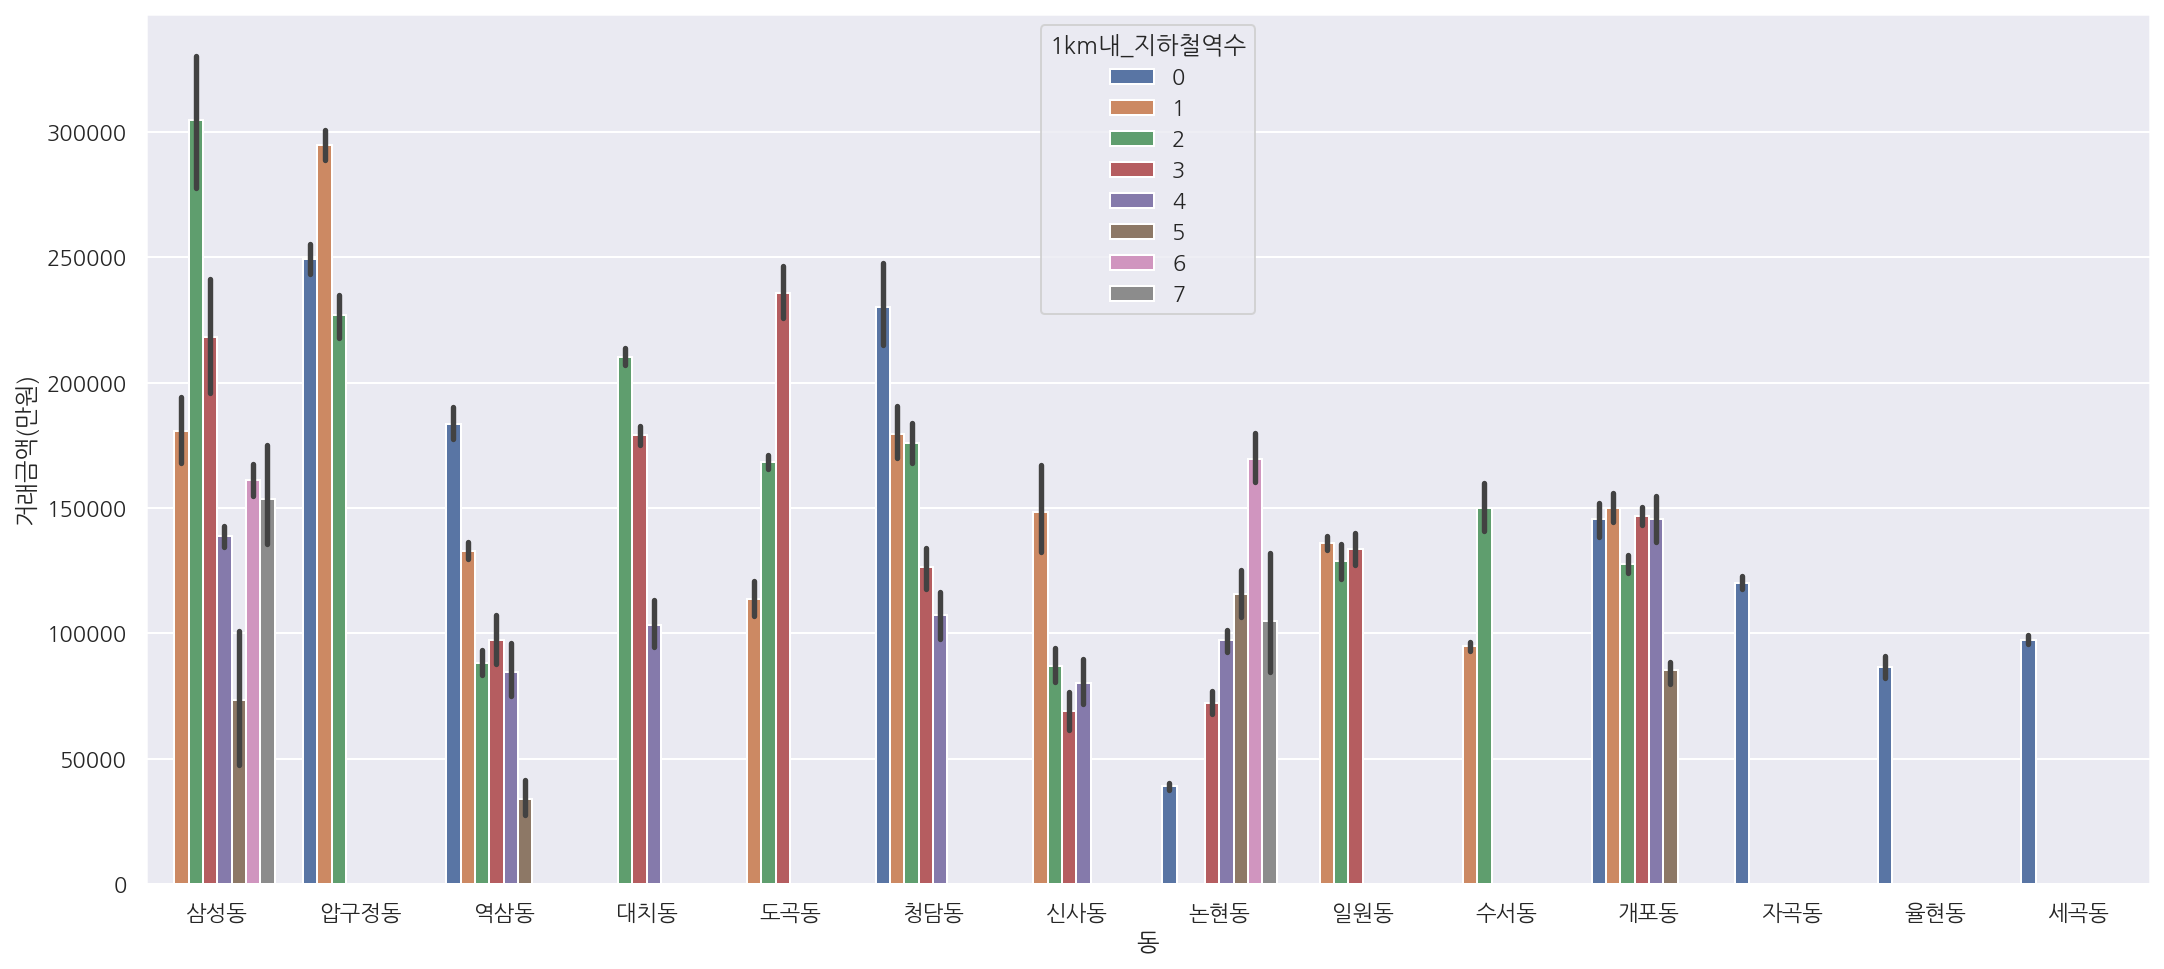

In [67]:
fig, ax = plt.subplots(figsize = (16,8))
g = sns.barplot(x='동', y='거래금액(만원)', hue='1km내_지하철역수', data=df)

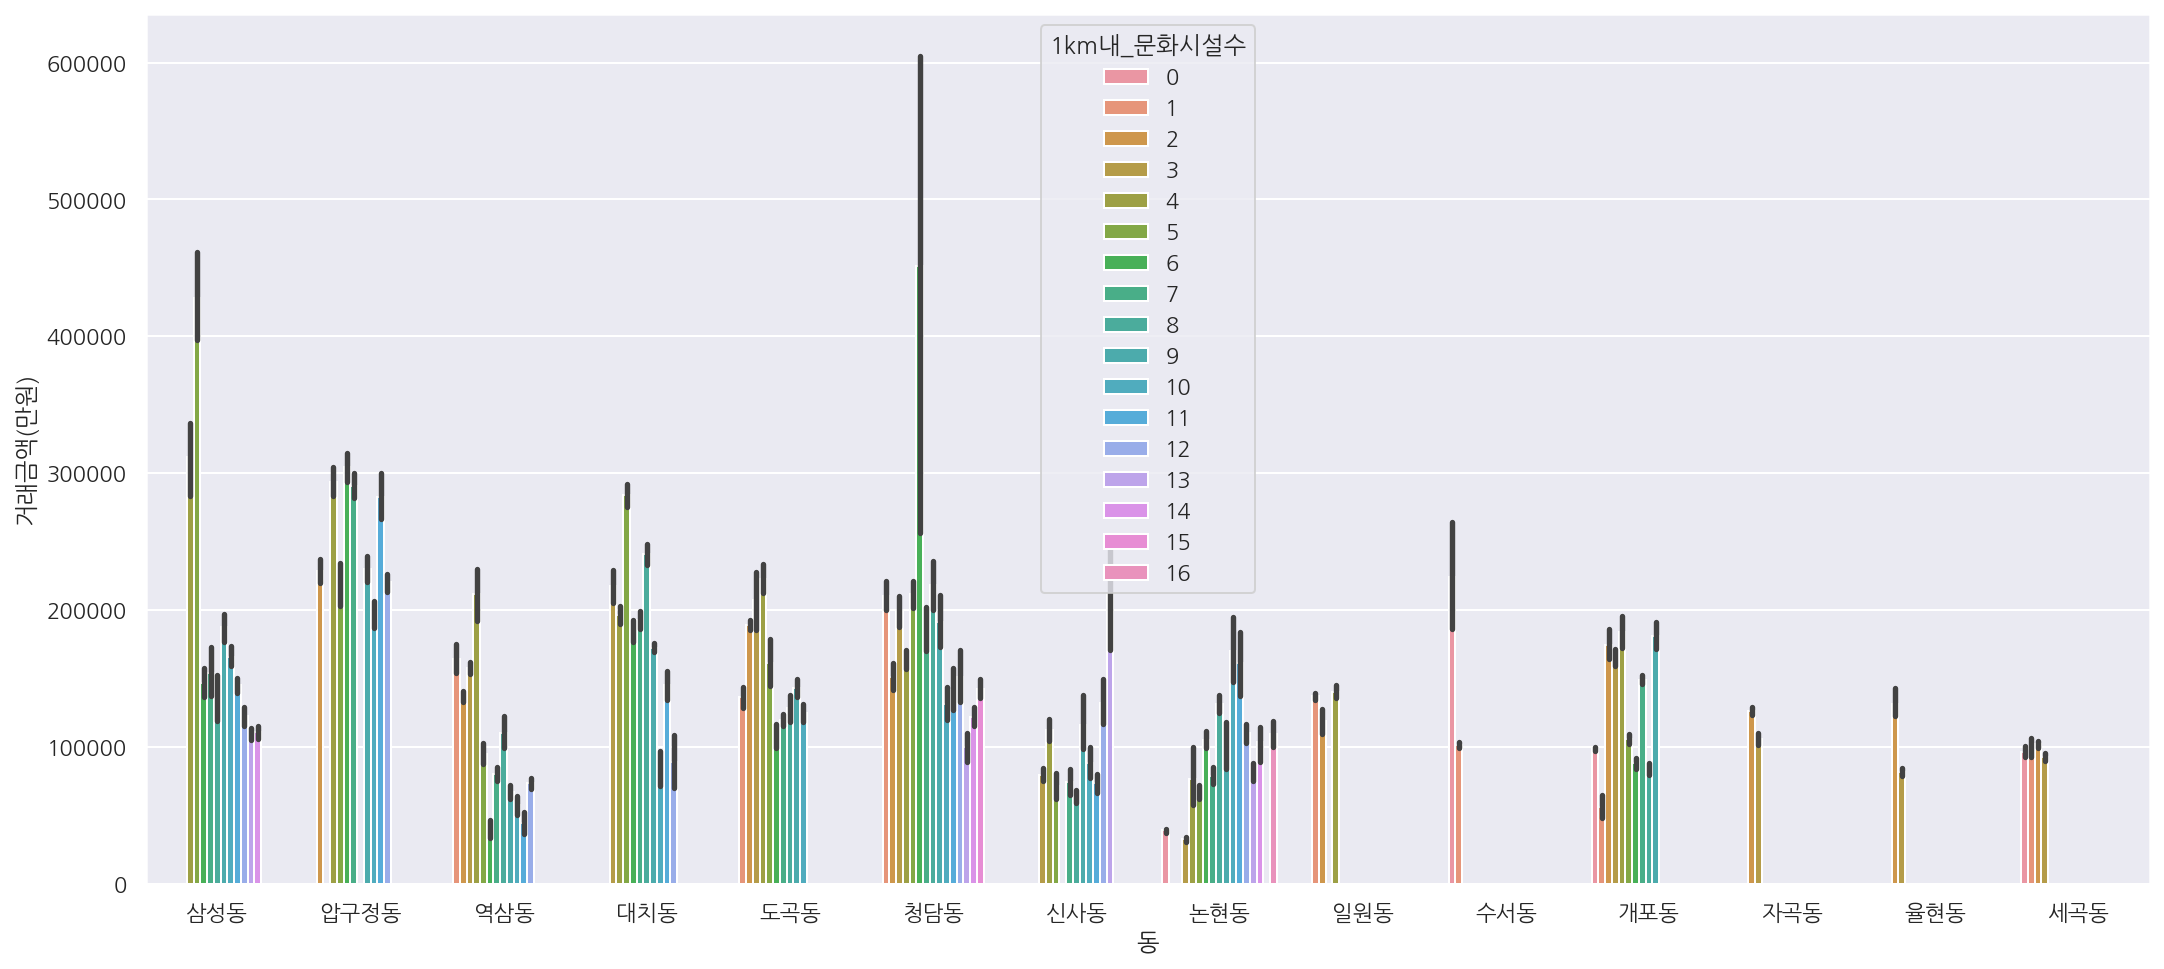

In [68]:
fig, ax = plt.subplots(figsize = (16,8))
g = sns.barplot(x='동', y='거래금액(만원)', hue='1km내_문화시설수', data=df)

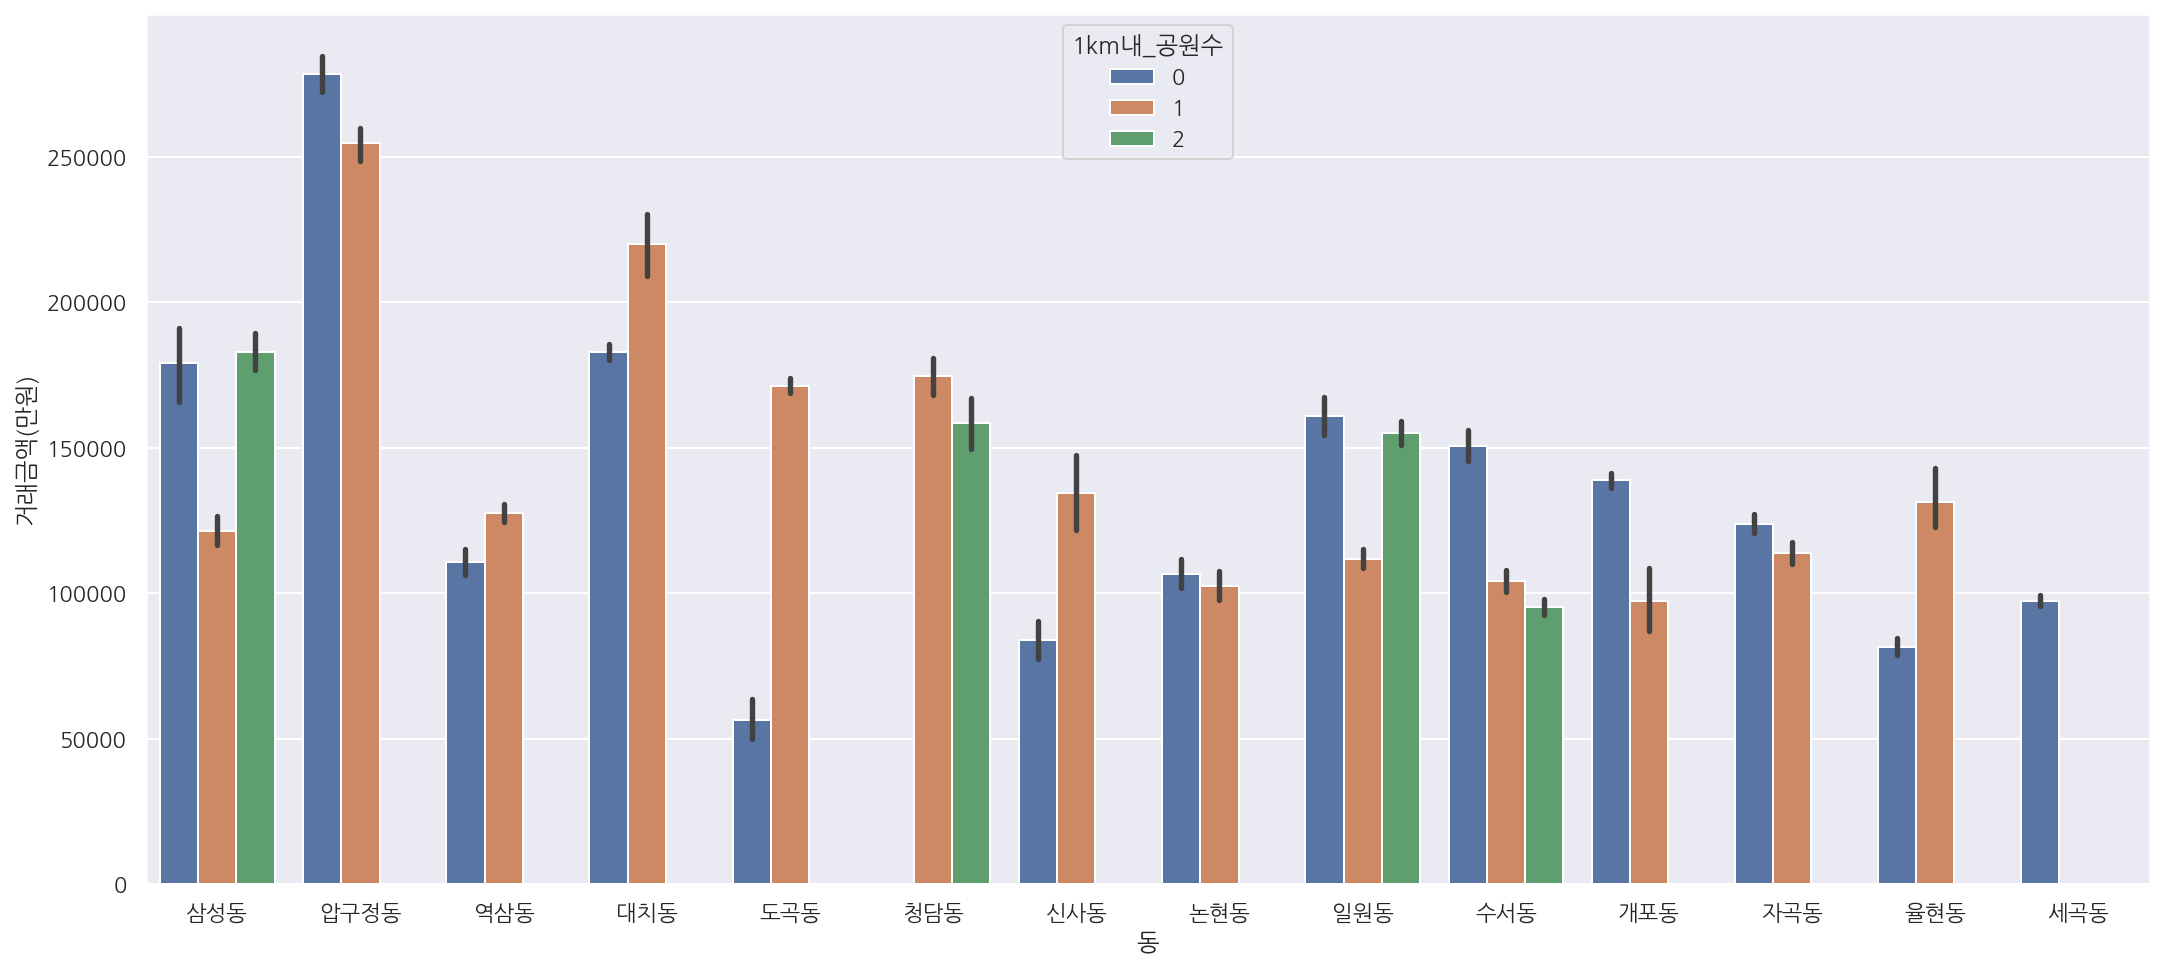

In [69]:
fig, ax = plt.subplots(figsize = (16,8))
g = sns.barplot(x='동', y='거래금액(만원)', hue='1km내_공원수', data=df)

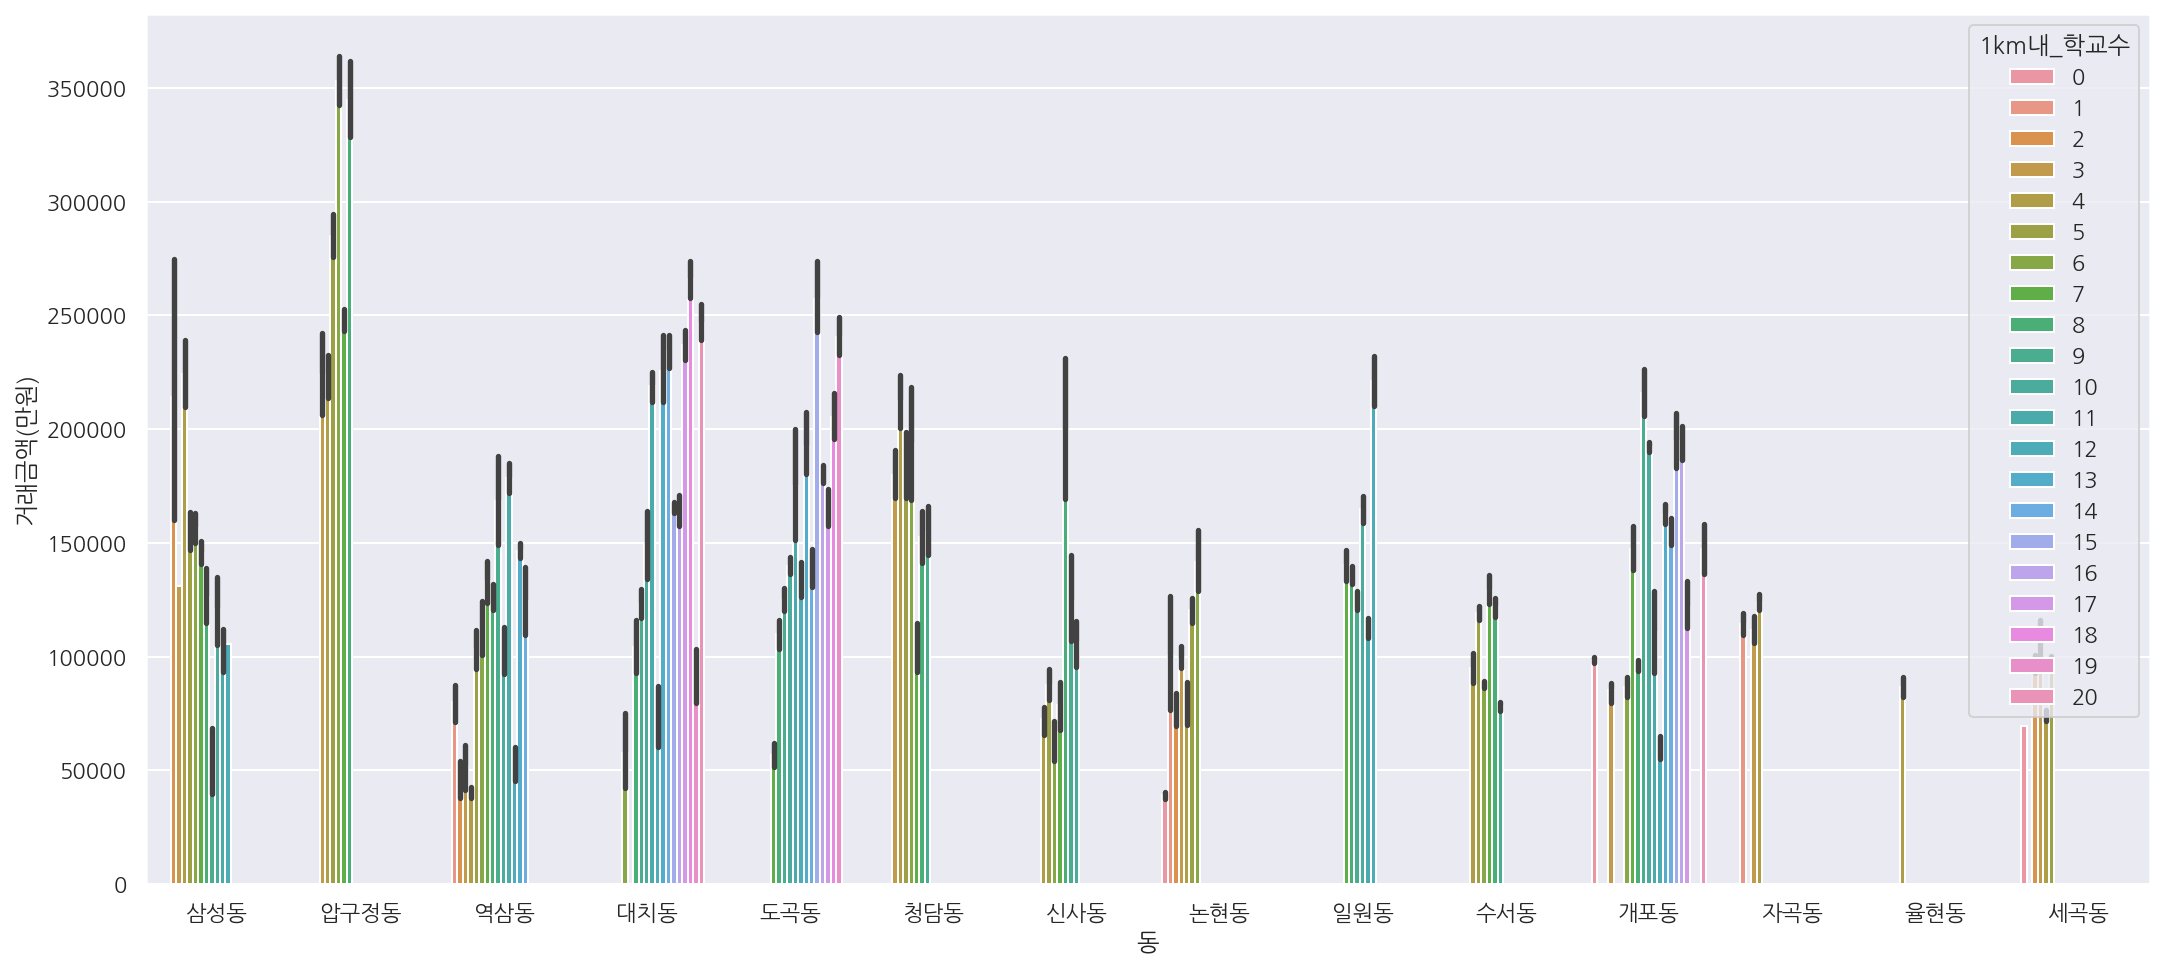

In [70]:
fig, ax = plt.subplots(figsize = (16,8))
g = sns.barplot(x='동', y='거래금액(만원)', hue='1km내_학교수', data=df)

## correlation

In [83]:
#필요없는 column은 드롭합니다
df2=df.drop(columns = ['번지','본번','부번','도로명','계약년월','계약일','X좌표','Y좌표','경도','위도','아파트_거래건수','층','건축년도','전용면적(㎡)'])
df2.reset_index(inplace=True)

In [84]:
df2.columns

Index(['index', '구', '동', '단지명', '거래금액(만원)', '혼인건수', '인구밀도', '소비자물가지수',
       '가계대출_십억원', '기준금리', '1km내_유치원수', '유치원_최소거리', '1km내_지하철역수', '지하철역_최소거리',
       '1km내_문화시설수', '문화시설_최소거리', '1km내_공원수', '공원_최소거리', '1km내_학교수', '학교_최소거리',
       '1km내_학원수', '학원_최소거리', '계약일자', 'top10', 'construction_year_group',
       'area_range', 'area_range_group', 'floor_group'],
      dtype='object')

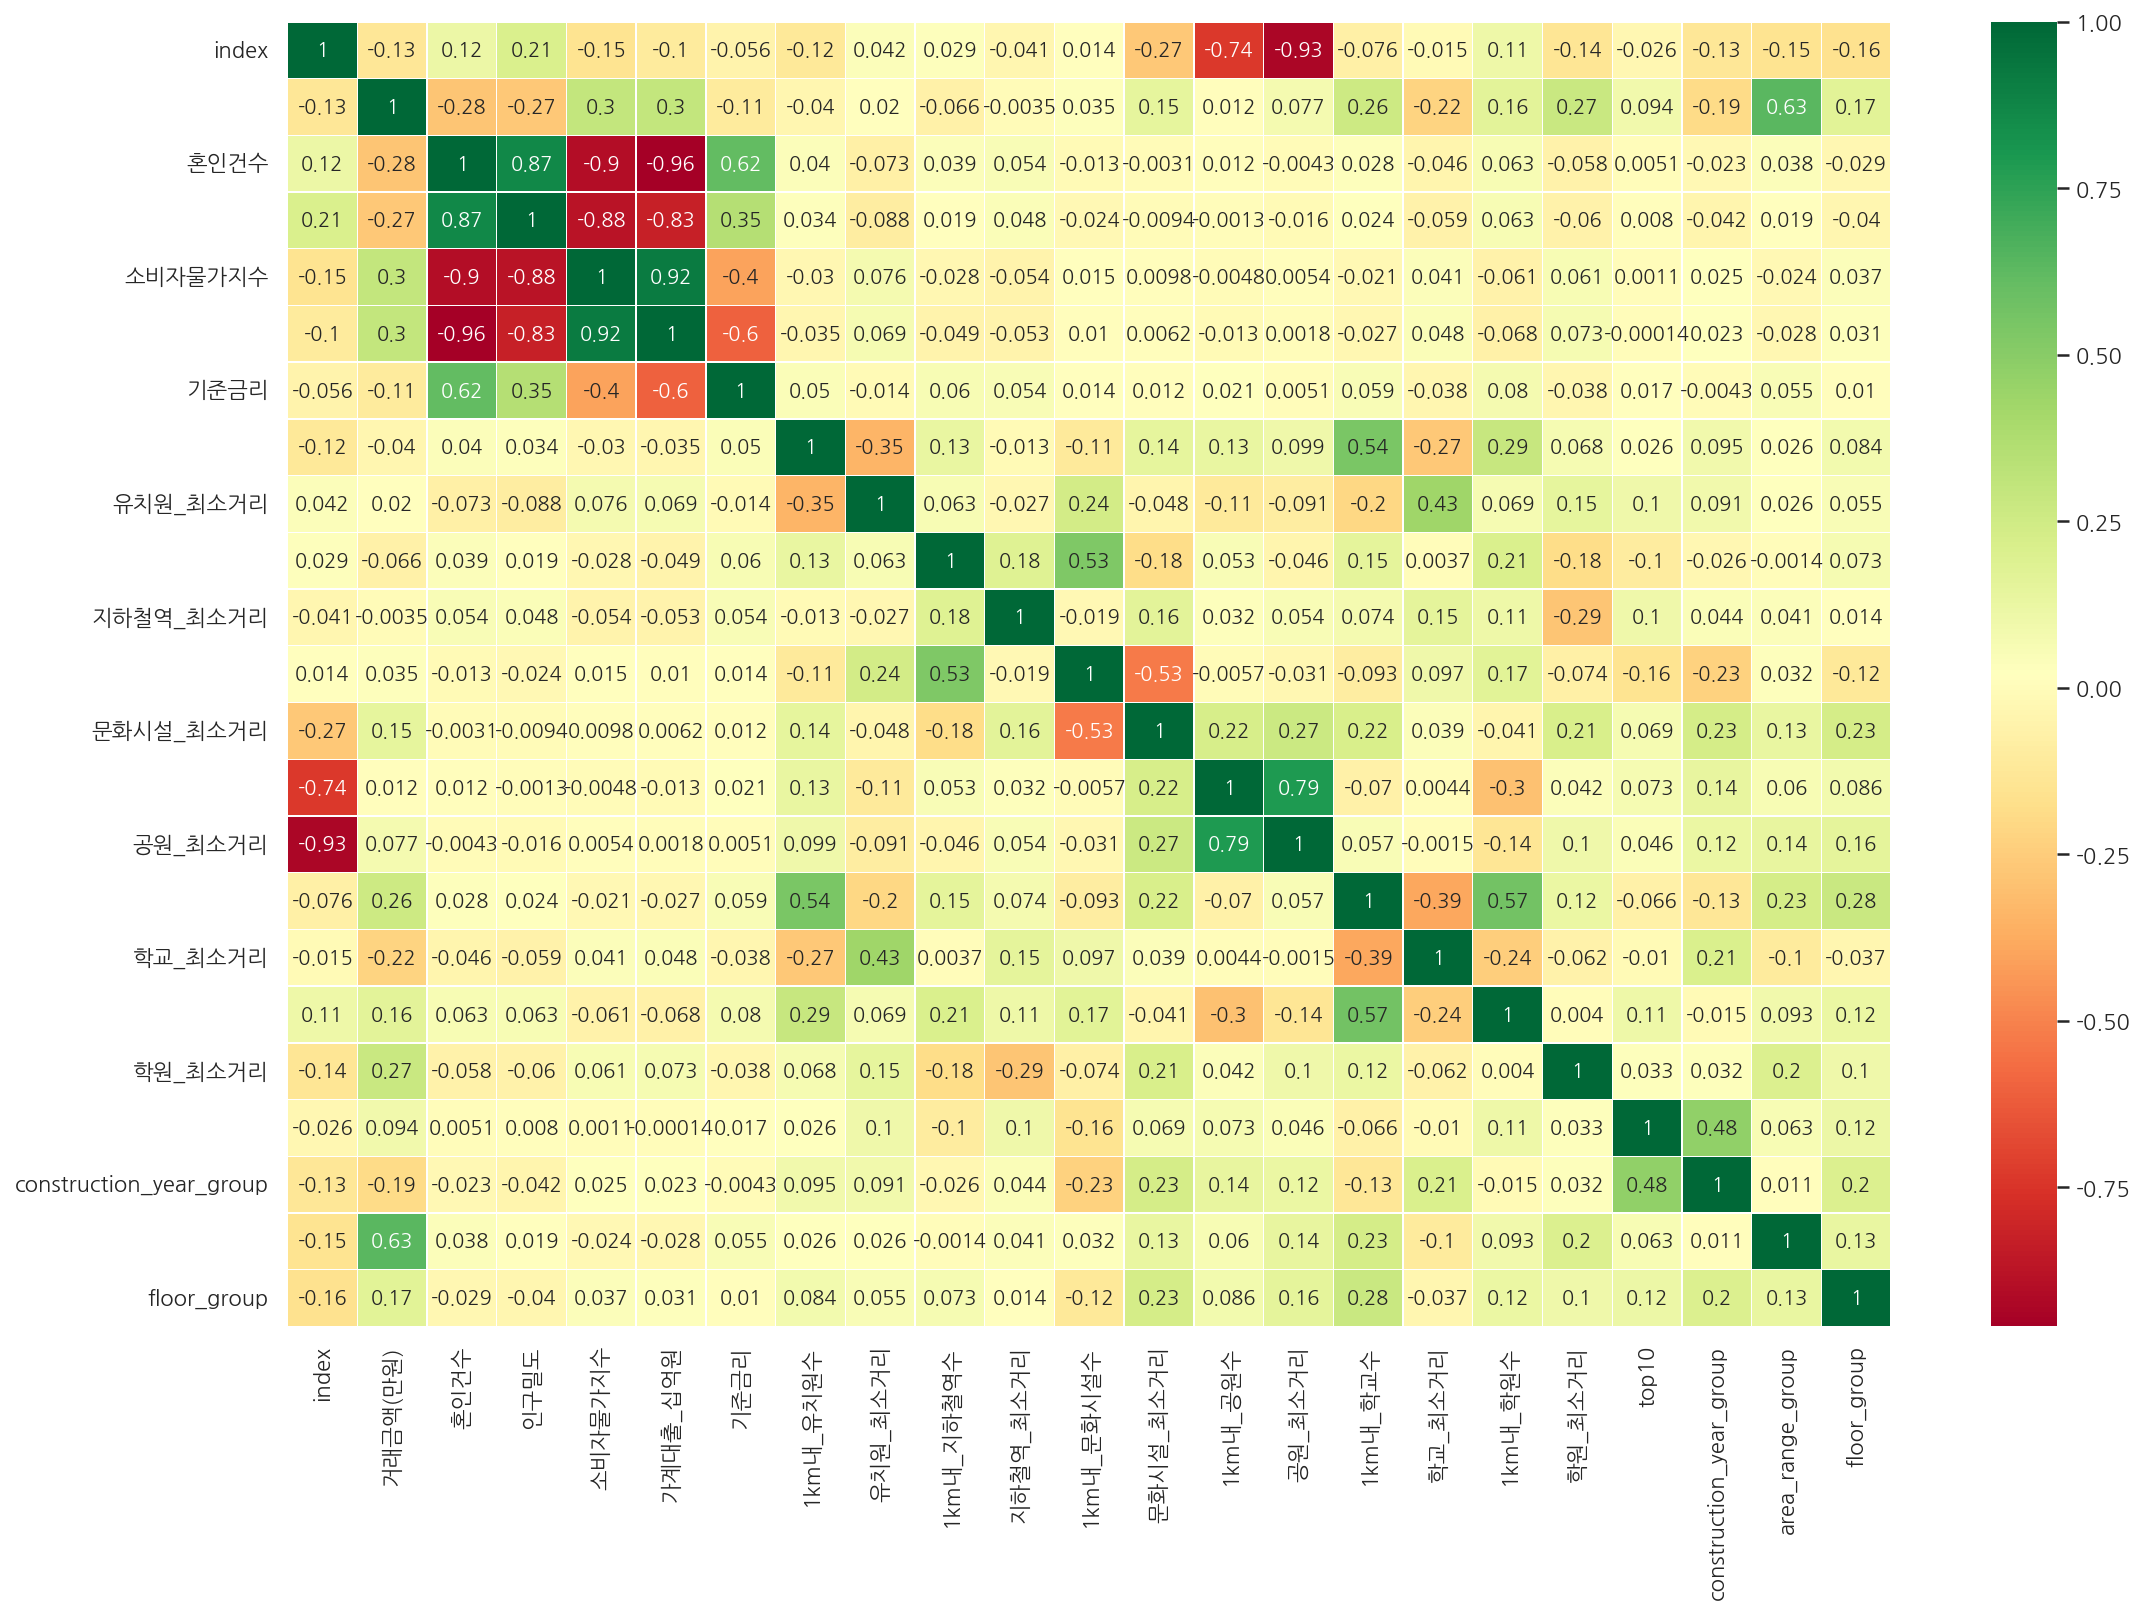

In [87]:
sns.heatmap(df2.corr(), annot=True, cmap='RdYlGn', linewidths=0.2) # data.corr() -> correlation matrix
fig = plt.gcf()
fig.set_size_inches(16, 12)
plt.show()

- 경제지수와 인구학적 정보의 상관관계가 나타난다.
- 아파트 근처 유치원과 학교의 수는 연관되어 있다.
- 학교와 학원에 관련된 정보가 서로 연관되어 있다
- 문화시설 최소거리는 아파트 층수, 건축년도, 전용면적과 연관되어 있다.

<br>

- 강남은 교육에 관심이 많다고 일반적으로 알려져 있는데, 이를 반영하듯 학교와 학원과 관련된 정보가 아파트 거래 가격과 상관관계를 보인다.
- 유치원 시설, 문화시설, 공원, 지하철역과는 관계가 낮다.

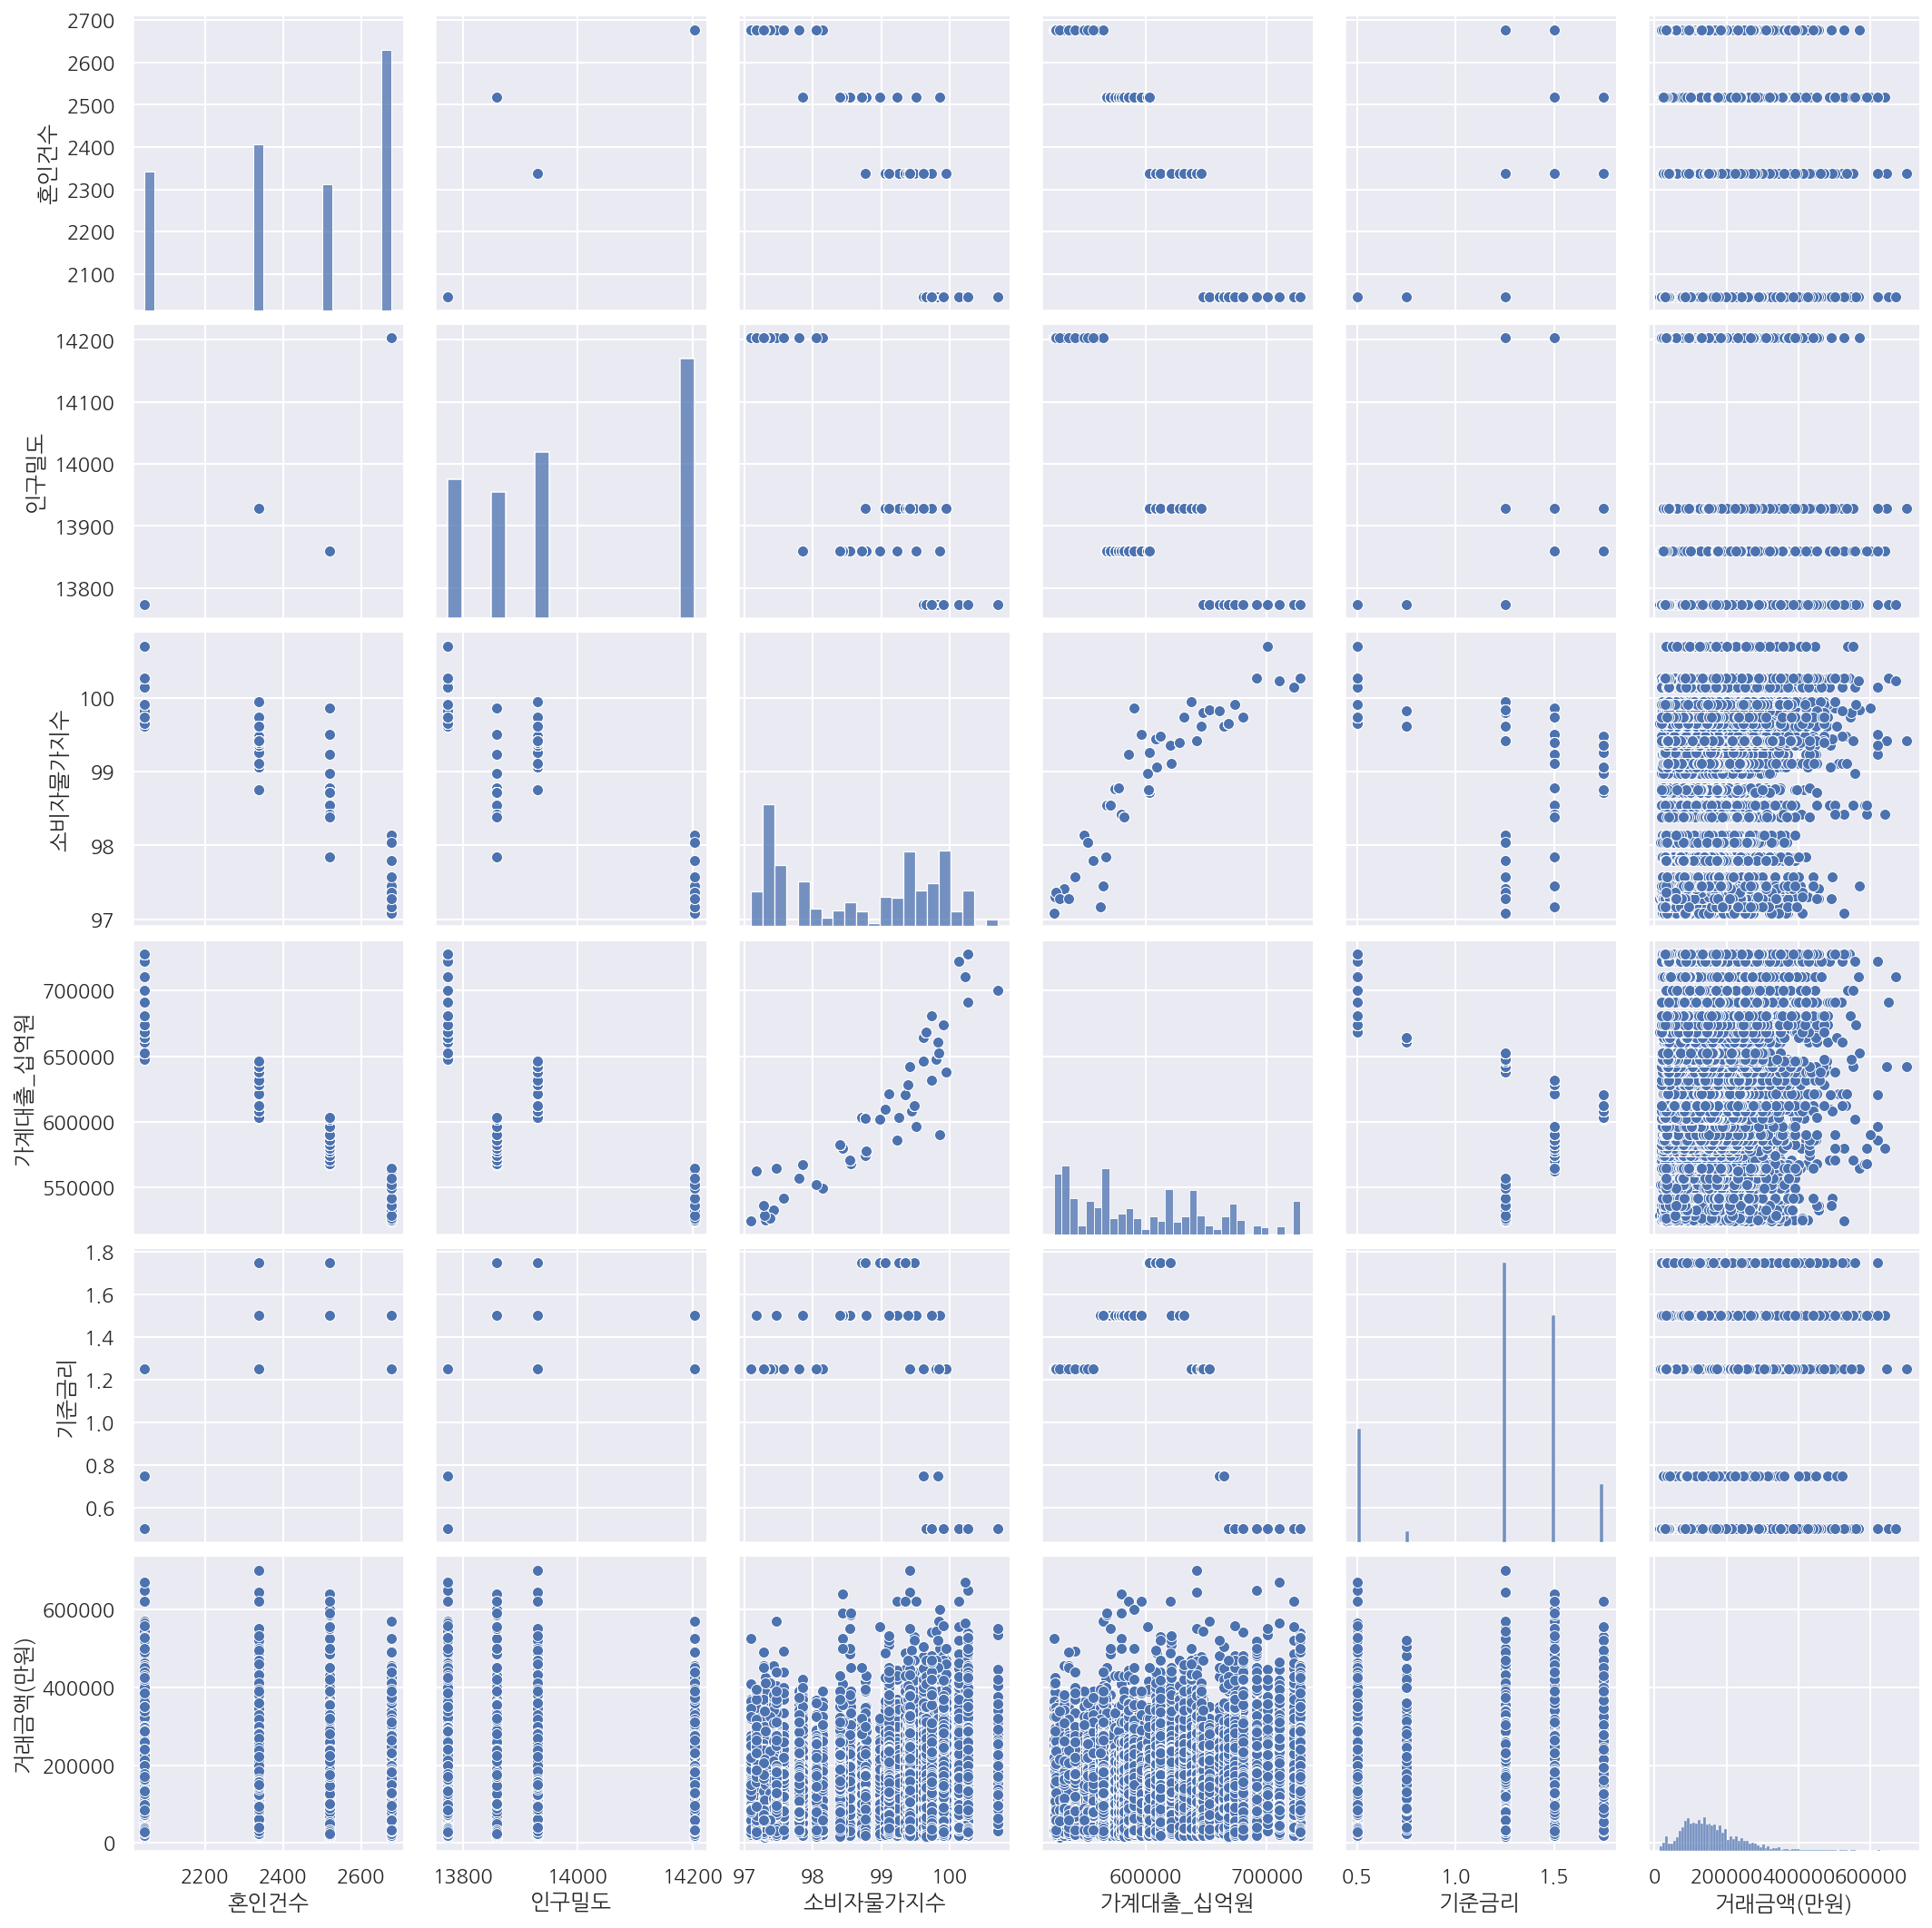

In [88]:
sns.pairplot(df2, vars = ['혼인건수', '인구밀도', '소비자물가지수','가계대출_십억원','기준금리', '거래금액(만원)'])

# PCA

다음 5개의 특성들이 서로 연관관계가 강했던 것(특성간의 상관계수가 0.6 이상)을 기준으로 하여, `혼인건수`, `인구밀도`, `소비자물가지수`, `가계대출_십억원`, `기준금리` 의 PCA를 진행함   
> Target인 거래금액과 특성들간의 상관계수가 약 0.3으로 미약한 연관관계가 확인됨  
> 따라서 특성들을 제거하기 보다는, PCA를 이용해 새로운 특성을 만드는 방향으로 진행함

In [89]:
# PCA를 진행하기 전, 특성들의 표준화가 필요함
X = df2[['혼인건수', '인구밀도', '소비자물가지수', '가계대출_십억원', '기준금리']]
scaler = StandardScaler()
Z = scaler.fit_transform(X)

pca = PCA(n_components=5)
pca_array = pca.fit_transform(Z)
print('각 component의 기여율: ', pca.explained_variance_ratio_)

각 component의 기여율:  [0.80031062 0.1501429  0.02960962 0.01350229 0.00643458]


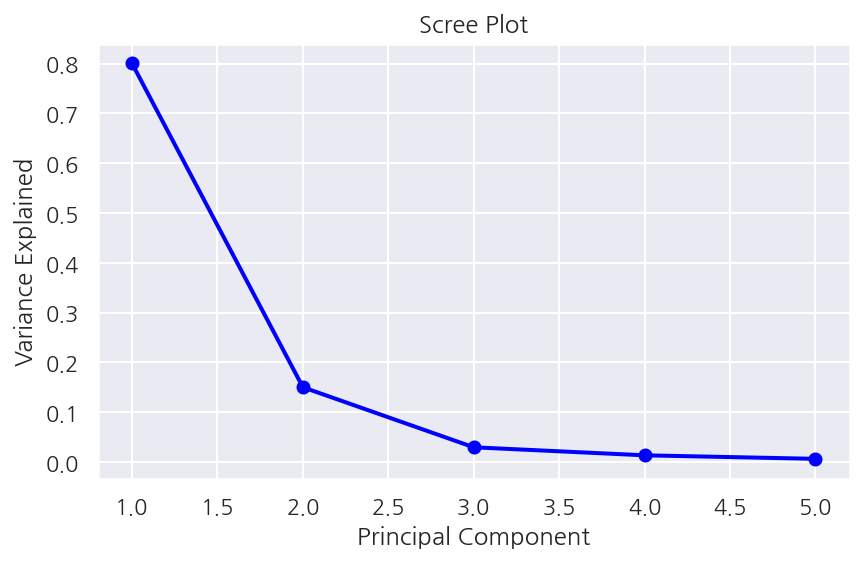

In [90]:
# Scree plot
PC_values = [1, 2, 3, 4, 5]
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-',
                linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

- component를 5로 설정하였을때, pca1의 기여율이 80% 이므로, component를 1로 설정하여 PCA를 수행함
- 누적 기여율이 80% 이상이 넘어가는 지점을 기준으로 함 ([참고링크](https://techblog-history-younghunjo1.tistory.com/134))

In [91]:
pca_df = pd.DataFrame(pca_array, columns=['pca1', 'pca2', 'pca3', 'pca4','pca5'])
df2['popul_pca'] = pca_df['pca1']

# pca에 활용한 특성들 drop
df2.drop(columns=['혼인건수', '인구밀도', '소비자물가지수', '가계대출_십억원', '기준금리'], inplace=True)

# 값 확인
df2['popul_pca']

0       -0.677153
1       -0.677153
2       -0.677153
3       -0.365096
4       -0.313550
           ...   
18346   -2.012081
18347   -1.698130
18348   -1.698130
18349   -1.720924
18350   -1.786661
Name: popul_pca, Length: 18351, dtype: float64

# 데이터 변환 (log, boxcox)

In [92]:
# target -> boxcox 변환
# 유치원,학교,학원,문화시설, 공원,지하철역 최소거리 -> 로그변환
df2['boxcox_amount'] = pd.Series(stats.boxcox(df2["거래금액(만원)"]))[0]

df2['log_kinder']= np.log1p(df2['유치원_최소거리'])
df2['log_school']= np.log1p(df2['학교_최소거리'])
df2['log_study']= np.log1p(df2['학원_최소거리'])
df2['log_culture']= np.log1p(df2['문화시설_최소거리'])
df2['log_park']= np.log1p(df2['공원_최소거리'])
df2['log_subway']= np.log1p(df2['지하철역_최소거리'])

In [93]:
# '동' => Dong_Group으로 변환
df2['Dong_Group'] = 0
df2.loc[df2[df2['동'] =='도곡동'].index, 'Dong_Group'] = 1
df2.loc[df2[df2['동'] =='대치동'].index, 'Dong_Group'] = 2
df2.loc[df2[df2['동'] =='역삼동'].index, 'Dong_Group'] = 3
df2.loc[df2[df2['동'] =='개포동'].index, 'Dong_Group'] = 4
df2.loc[df2[df2['동'] =='압구정동'].index, 'Dong_Group'] = 5
df2.loc[df2[df2['동'] =='삼성동'].index, 'Dong_Group'] = 6
df2.loc[df2[df2['동'] =='수서동'].index, 'Dong_Group'] = 7
df2.loc[df2[df2['동'] =='청담동'].index, 'Dong_Group'] = 8
df2.loc[df2[df2['동'] =='일원동'].index, 'Dong_Group'] = 9
df2.loc[df2[df2['동'] =='논현동'].index, 'Dong_Group'] = 10
df2.loc[df2[df2['동'] =='세곡동'].index, 'Dong_Group'] = 11
df2.loc[df2[df2['동'] =='자곡동'].index, 'Dong_Group'] = 12
df2.loc[df2[df2['동'] =='신사동'].index, 'Dong_Group'] = 13
df2.loc[df2[df2['동'] =='율현동'].index, 'Dong_Group'] = 14
df2['Dong_Group'].value_counts()

1     2914
2     2878
3     2124
4     2037
5     1473
6     1465
7     1231
8     1161
9      971
10     814
11     539
12     455
13     217
14      72
Name: Dong_Group, dtype: int64

## 변환 후 확인

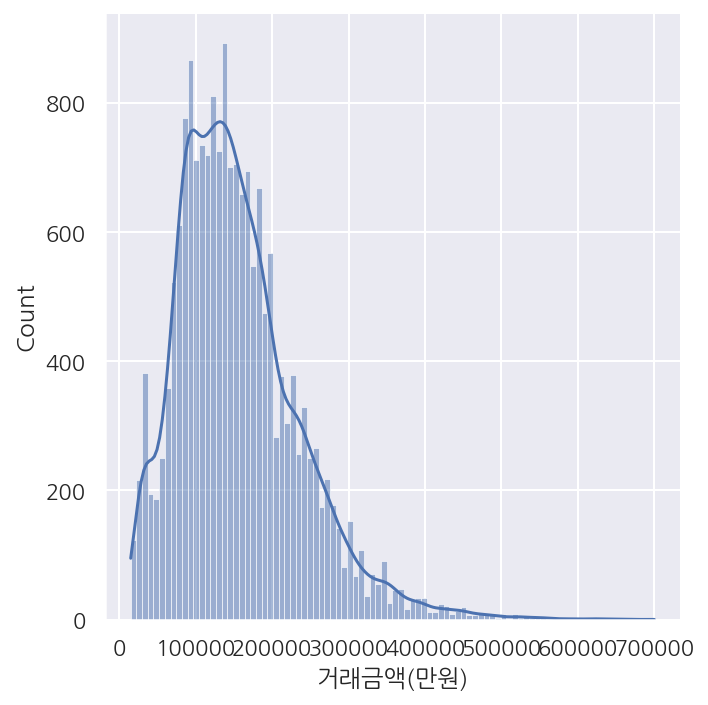

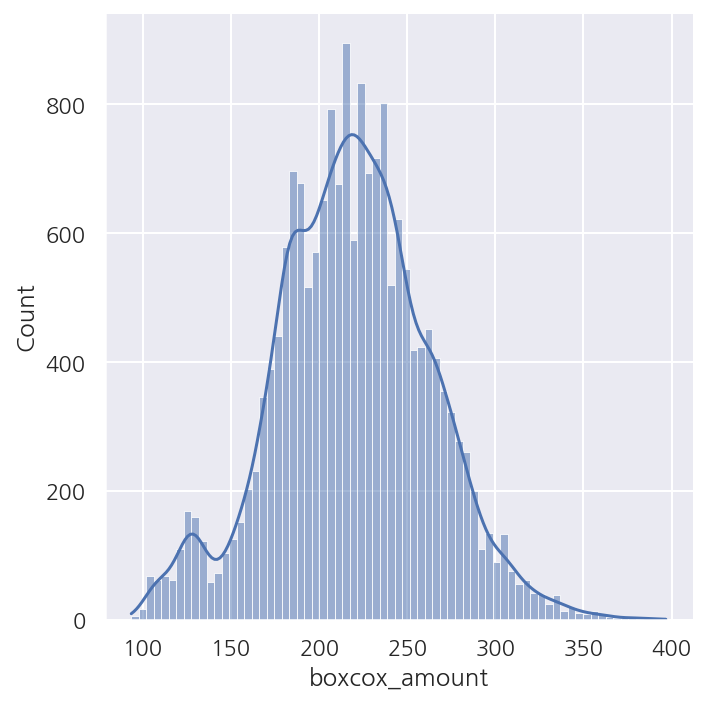

In [94]:
sns.displot(df2['거래금액(만원)'],kde=True)
sns.displot(df2['boxcox_amount'],kde=True)
plt.show()

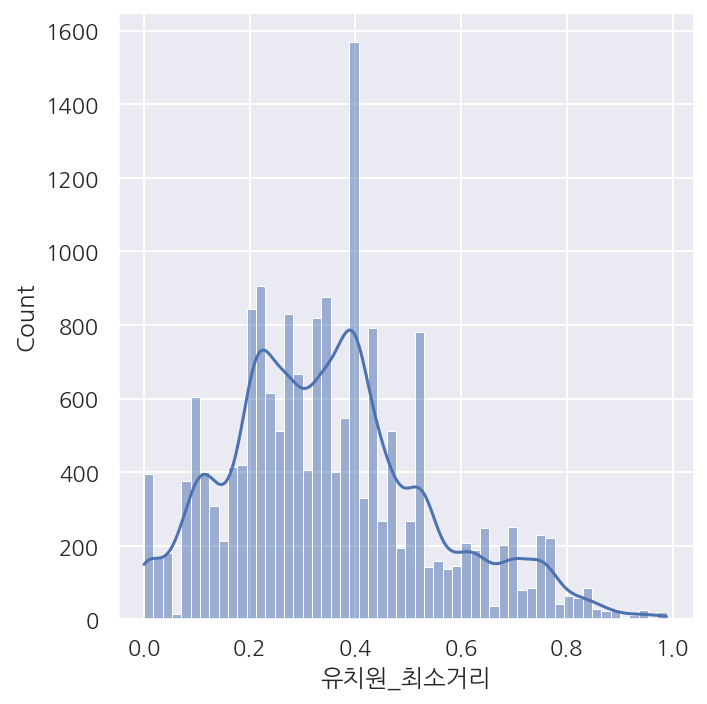

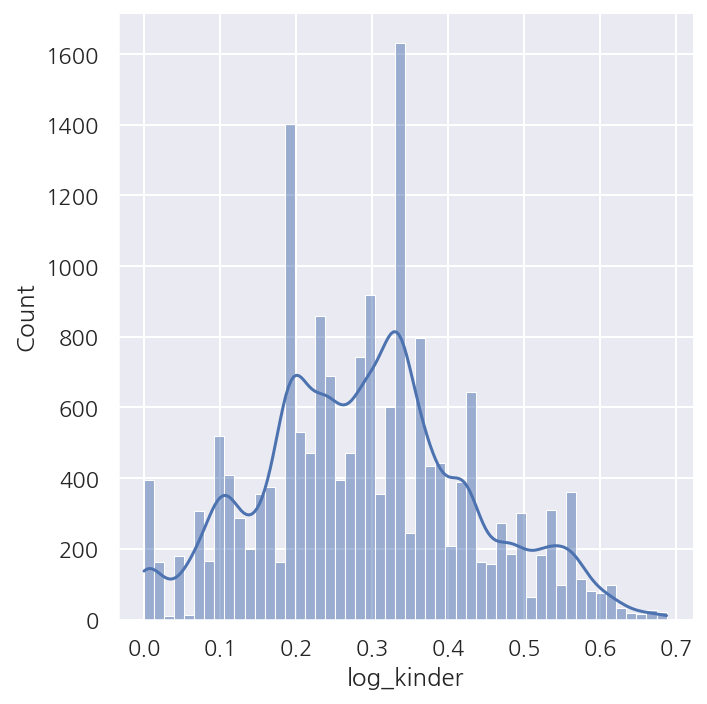

In [95]:
sns.displot(df2['유치원_최소거리'],kde=True)
sns.displot(df2['log_kinder'],kde=True)
plt.show()

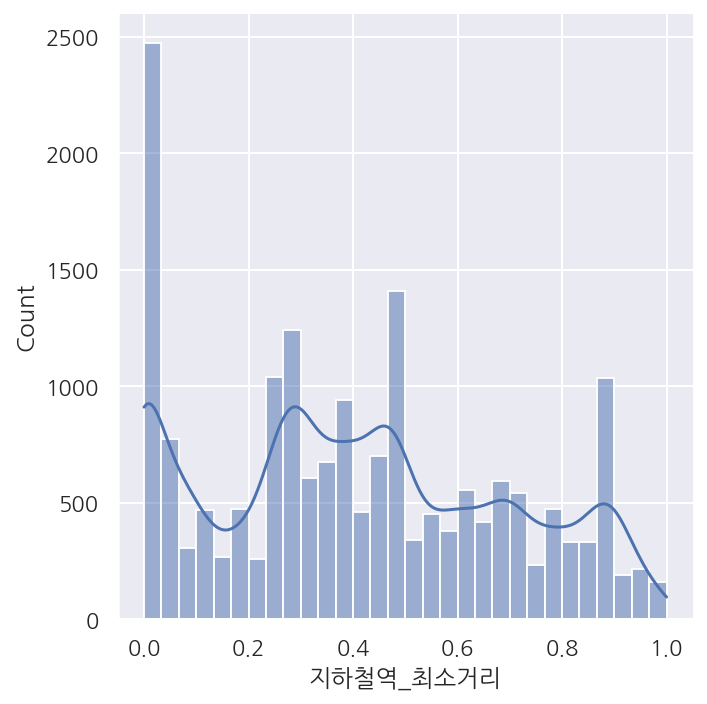

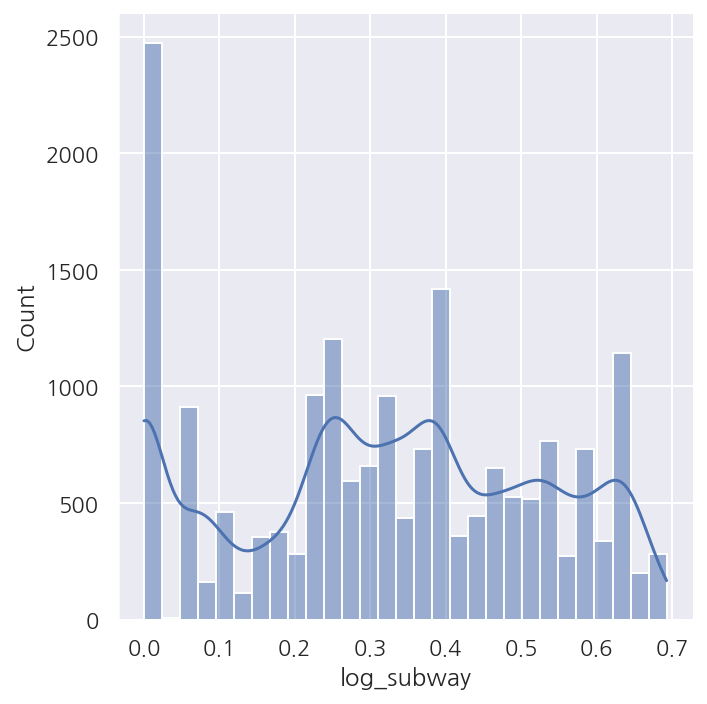

In [96]:
sns.displot(df2['지하철역_최소거리'],kde=True)
sns.displot(df2['log_subway'],kde=True)
plt.show()

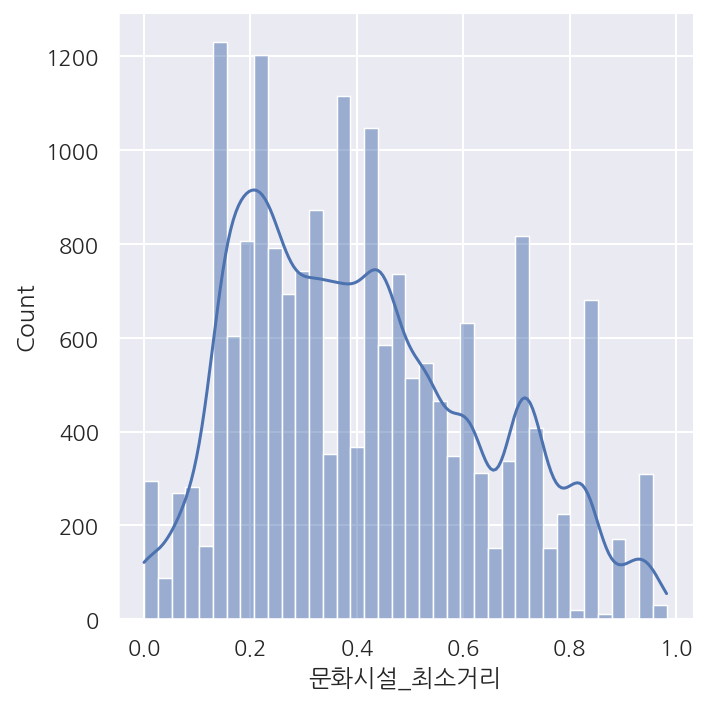

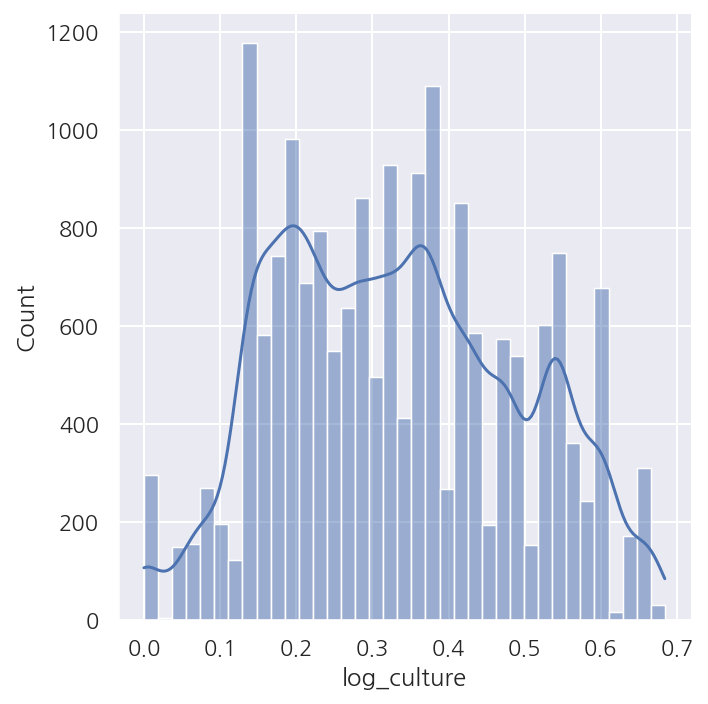

In [97]:
sns.displot(df2['문화시설_최소거리'],kde=True)
sns.displot(df2['log_culture'],kde=True)
plt.show()

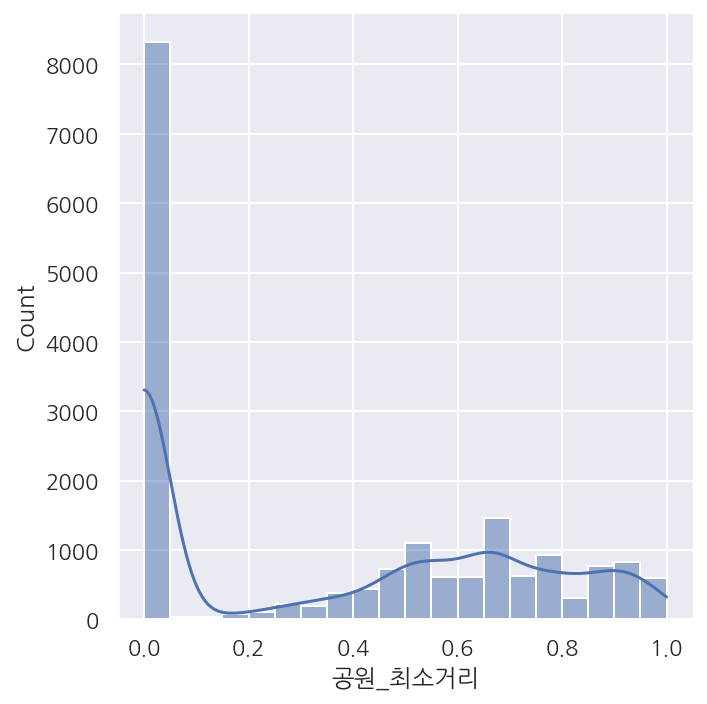

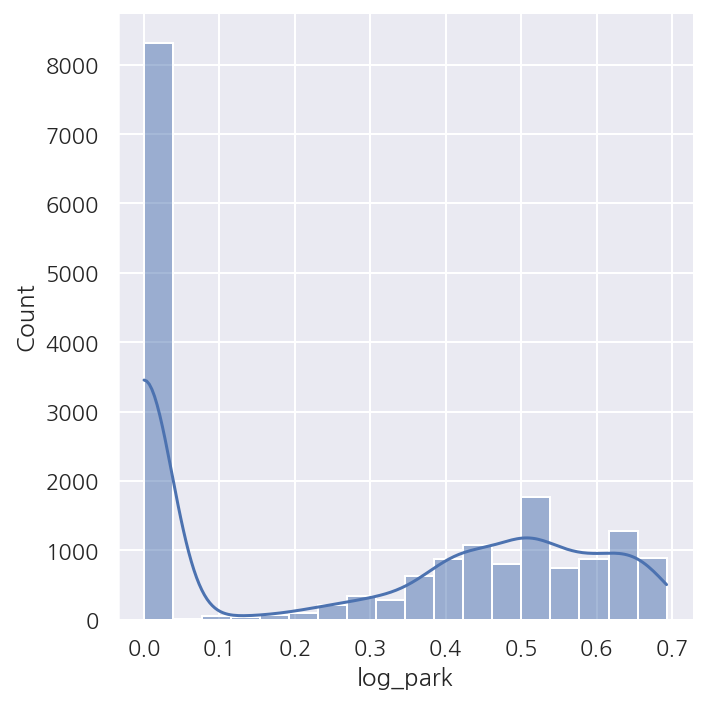

In [98]:
sns.displot(df2['공원_최소거리'],kde=True)
sns.displot(df2['log_park'],kde=True)
plt.show()

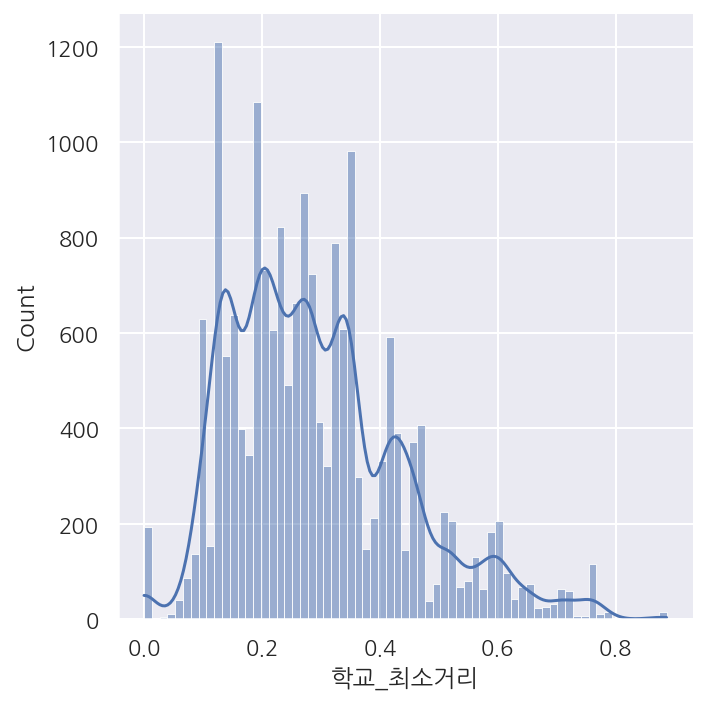

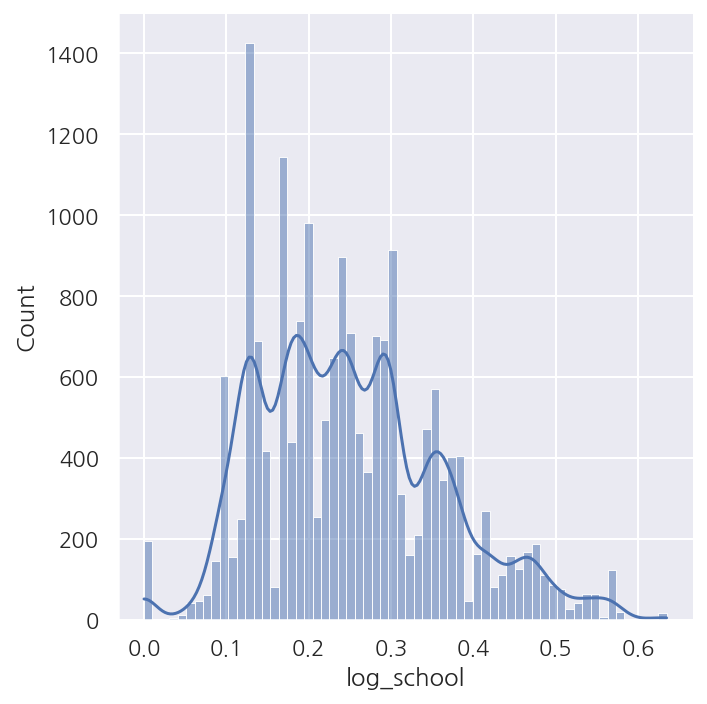

In [99]:
sns.displot(df2['학교_최소거리'],kde=True)
sns.displot(df2['log_school'],kde=True)
plt.show()

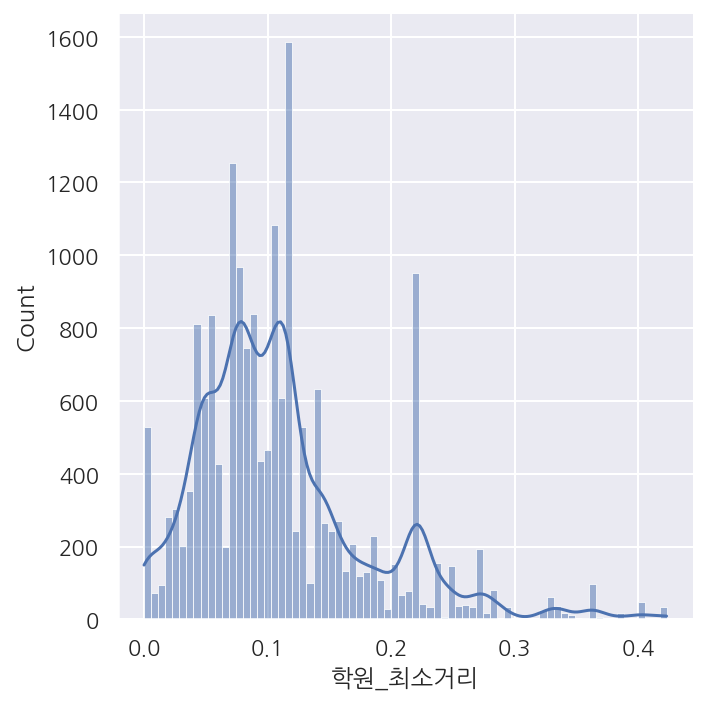

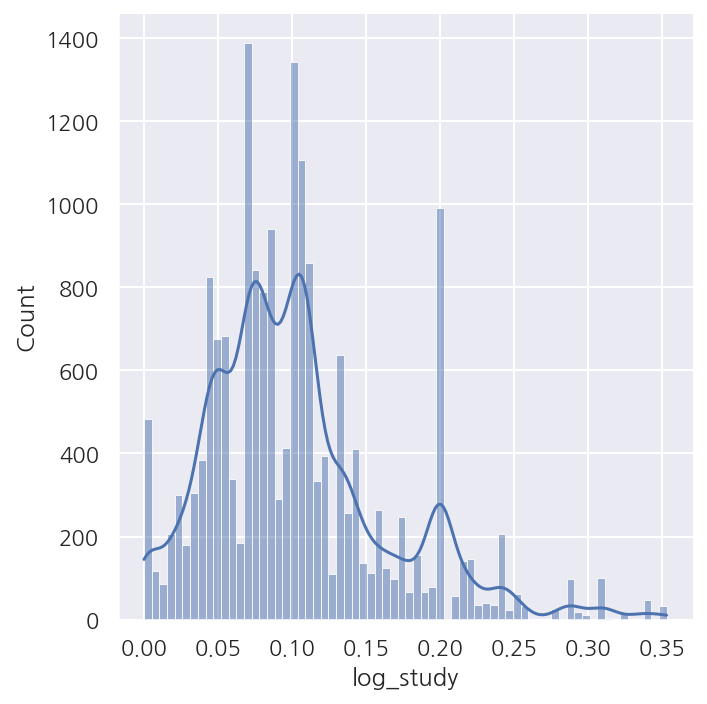

In [100]:
sns.displot(df2['학원_최소거리'],kde=True)
sns.displot(df2['log_study'],kde=True)
plt.show()

# 수정 후 결과 저장

In [101]:
df2.to_csv('/content/gdrive/MyDrive/CodeStates/CP1/데이터_병합_수정/강남_아파트_실거래가예측_for_modeling_2017_2020.csv',encoding='utf-8-sig')